In [1]:
import numpy as np
from matplotlib import *
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
from matplotlib.colors import LogNorm
from matplotlib.legend_handler import HandlerLine2D


import scipy
from scipy import stats
from astropy import constants as const
from scipy import optimize
import scipy.integrate as integrate
from scipy.integrate import quad 
from scipy.special import *
import math
from ReadFile import Read
import pandas as pd


In [2]:
# plt.rcParams.update({
#                     "text.usetex": True,
#                     "font.family": "sans-serif",
#                     "font.sans-serif": ["Helvetica"]})

#font.serif         : Times, Palatino, New Century Schoolbook, Bookman, Computer Modern Roman
#font.sans-serif    : Helvetica, Avant Garde, Computer Modern Sans serif
#font.cursive       : Zapf Chancery
#font.monospace     : Courier, Computer Modern Typewriter

In [3]:
Mgsol = 5.08 #banda g
Misol = 4.53 #banda i
Mrsol = 4.64 #banda r 

In [4]:
#################### READ CATALOGUE ########################

# col_names = ["objid", "specobjid", "z", "nsersic_g", "Re_g", "L_g", "ba_g", "Mg", "nsersic_r", "Re_r", "L_r", "ba_r", "Mr", "nsersic_i", "Re_i", "L_i", "ba_i", "Mi", "Vol_max", "P_early"]
# catalog = pd.read_csv("SDSS_DR7_sersic_photometric_catalog2.txt", dtype= None, sep='\s+', names=col_names)

In [5]:
# catalog
catalog =  Read('SDSS_DR7_sersic_photometric_catalog.txt')


In [6]:
catalog_diamond =  Read('SDSS_DR7_sersic_photometric_catalog_diamond_sfrs.txt')

In [7]:
catalog_full = Read('SDSS_DR7_sersic_photometric_full_catalog.txt')

In [8]:
# catalog.to_csv('SDSS_DR7.csv')
#catalog

In [9]:
########## LUMINOSITES INTENSITIES AND MAGNITUDES ##################


# Sersic general equation for any n. Eq. 2.22 from Galaxy Formation & Evolution 
# Need to define Reff first
# Bn 2n-0.324 (but only for n=>1) (B beta)
# To write I(R) in terms of L_tot instead of I0:
#         I(R)= {(L_tot*bn**2n)/(2*pi*Re**2*G(2n))} exp[-bn(R/Re)**(1/n)]
# To write I(R) in terms of L_tot instead of Ie:
#         I(R)= {(L_tot*bn**2n)/(2*pi*Re**2*G(2n)*exp(bn))} exp[-bn{(R/Re)**(1/n)-1}]


def I0_to_Ie(I0):
    #units Lsun / kpc**2
    
    Bn = 1.9992*n - 0.3271
    
    return I0/np.exp(Bn)

def Ie_to_I0(Ie):
    #units Lsun / kpc**2
    
    Bn = 1.9992*n-0.3271
    
    return Ie*np.exp(Bn)
    
    

def Ltot_to_I0(Ltot, Re, n):
    # Function that transform a given luminosity to I0 from eq 2.22 and 2.24
    # Takes in total luminosity, effective radius and sersic index
    # Returns I0
    # Ltot*(Bn)**(2n) / Re**2/(2*np.pi*n)/gamma
    #units Lsun / kpc**2
    
    Bn = 1.9992*n-0.3271
    
    gm = gamma(2*n)  #gamma function
    
    I0 = Ltot*(Bn)**(2*n) / Re**2/(2*np.pi*n)/gm
    
    return I0

def Ltot_to_Ie(Ltot, Re, n):
    # Function that transform a given luminosity to I0 from eq 2.22 and 2.24
    # Takes in total luminosity, effective radius and sersic index
    # Returns Ie
    # Ltot*(Bn)**(2n) / Re**2/(2*np.pi*n)/gamma/np.exp(Bn)
    
    Bn = 1.9992*n-0.3271
    
    gm = math.gamma(2*n)  #gamma function
    
    Ie = Ltot*(Bn)**(2*n) / Re**2/(2*np.pi*n)/gm/np.exp(Bn)
    
    return Ie
    

def sersic_profile(r, Ie, n, Re):
    # I0 puede ser L_tot
    # The surface brightness profile of spheroidal galaxies is generally well fit by the Sersic profile
    # Compare to sersic mass density 
    # I(R) = I0*exp[-Bn(R/Re)**(1/n)] = Ie*exp[-Bn{(R/Re)**(1/n)-1}]
    # Ie = I0/exp(Bn)
    # Inputs: radius, Intesity, sersic index, Reff
    # units are Lsun / kpc**2
    # Eq 2.22 from Galaxy Formation & Evolution
   
    Bn = 1.9992*n-0.3271
    ratio = (r/Re)**(1/n)
    exponent = -Bn*(ratio-1)
    
    return Ie*np.exp(exponent)



def L_profile(r, Ie, n, Re):
    # Total luminosity. Eq. 2.24 from Galaxy Formation & Evolution 
    # The total luminosity of a spherical system but as a function of radius. 
    # Compare to mass_prof_disk/sph from old code 
    # L = 2*pi*integral(I(R)RdR)
    # integrate sersic profile from 0 to R
    # inputs:
    #        radius, Intensity(e), sersic index, R eff
    
    def L(r, Ie, n, Re):
        
        return 2*np.pi*sersic_profile(r, Ie, n, Re)*r
    
    I = integrate.quad(L, 0 ,r, args=(Ie, n, Re), epsabs=1e-03, epsrel=1e-03, limit=15, maxp1=20, limlst=20)

    
    
    ansI = I[0]
    
    return ansI

def L_tot(Ie, n, Re):
    # Total luminosity. Eq. 2.24 from Galaxy Formation & Evolution 
    # The total luminosity of a spherical system with a Sersic profile is given by this equation.
    # Compare to mass_prof_disk/sph from old code 
    # Inputs :
    #         Intensity(e), sersic index, Eff rad
    # L = 2*pi*integral(I(R)RdR) = (2*pi*G(2n)/(Bn)**(2*n))*I0*Re**2
    # integrate sersic profile from 0 to inf
    # Returns the total Luminosity
    "units of Lsun?"
    
    Bn = 2*n-0.324
    
    gm = math.gamma(2*n)  #gamma function buscar funcion completa
    
    I0 = Ie*np.exp(Bn)    
    
    L = (2*np.pi*n*gm/(Bn)**(2*n))*I0*Re**2
    
    return L

def abs_mag_to_log10Lx(Mabs_x, Mabs_xsol):
#     Input: x = band, Mx = absolute magnitude of a given object at a given band
#     Returns the total luminosity at a given band of the galaxy
#     M_gsol = 5.11 #banda g 
#     M_isol = 4.53 #banda i
#     Log(L_x/L_xsol) = -0.4* (M_x - M_xsol) 
#     Eq 2.6 from Galaxy Formation & Evolution
#     This returns the LOG of the luminosity!
    
    return -0.4*(Mabs_x-Mabs_xsol) #### Log(Lx/L_xsol)


def Lx_to_abs_mag(Lx, Mabs_xsol):
    # M_x  =  -2.5 *log(L_x/L_xsol) + M_xsol
    # It takes L_profile as input to make it an absolute magnited as a function of radius
    # Substract two different bands to get the color
    

    return -2.5 * np.log10(Lx) + Mabs_xsol #### Absolute Magnitude

In [10]:
 ################ MASS PROFILES #########################   
    
    
def stellar_mass_profile(func, r, Ie_x, Ie_y, n_x, n_y, Re_x, Re_y, Mabs_xsol, Mabs_ysol):
    
##llamar una funcion cualquier (ie func en el input) func puede ser Stellar_mass_from_gi
# To make it a function of radius
# Inputs:
#       radius, Intensity(e), sersic index, Magnitudes of the g and i bands
   
   
    Lr_x = L_profile(r, Ie_x, n_x, Re_x)
    Lr_y = L_profile(r, Ie_y, n_y, Re_y)
    Mr_x = Lx_to_abs_mag(Lr_x, Mabs_xsol)
    Mr_y = Lx_to_abs_mag(Lr_y, Mabs_ysol)
   # We need the luminosity profile of the i band to make it a function of radius 
   
    return func(Lr_y, Mr_x, Mr_y) 



def Stellar_mass_from_gi(LtI, Mxg, Mxi):
# Log(Ms/Msol) = -0.68 + 0.73 * (g-i)  + log10(L_i/L_isol)
# Total stellar mass 
# Instead of the Luminosity profile, we use the total luminosity
#"only units of solar mass?"
   
    color = Mxg - Mxi 
   
    logMs =  -0.68 + 0.73 * color  + np.log10(LtI)
    
   
    return 10**logMs


def Stellar_mass_Bell_gr(LtR, Mxg, Mxr):
   #log10Mste_Bell_r = -0.406 + 1.097 * (g-r) + log10(L_r) 
   
    color = Mxg - Mxr
   
    logMs = -0.406 + 1.097 * color + np.log10(LtR) 
   
    return 10**logMs

def Stellar_mass_Bell_gi(LtI, Mxg, Mxi):
   #log10Mste_Bell_i = - 0.252 + 0.518*(g-i)+log10(L_i)
   
    color = Mxg - Mxi
   
    logMs = - 0.252 + 0.518* color + np.log10(LtI)
   
    return 10**logMs

def Stellar_mass_Zibetti_gr(LtR, Mxg, Mxr):
   #log10Mste_Zibetti_r = -0.840 + 1.654 * (g-r) + log10(L_r)
   
    color = Mxg - Mxr
   
    logMs = -0.840 + 1.654 * color + np.log10(LtR) 
   
    return 10**logMs

def Stellar_mass_Zibetti_gi(LtI, Mxg, Mxi):
   #log10Mste_Zibetti_i = -0.963 + 1.032*(g-i) + log10(L_i)
   
    color = Mxg - Mxi
   
    logMs = -0.963 + 1.032 * color + np.log10(LtI)
   
    return 10**logMs


def r_effective(func, Mstot,Ie_x, Ie_y, n_x, n_y, Re_x, Re_y, Mabs_xsol, Mabs_ysol):
   # Computes the effective (mass) radius. Where half of the total mass is located
   #  total_stellar_mass/2 = stellar_mass_profile 

    def f(r, func, Mstot, Ie_x, Ie_y, n_x, n_y, Re_x, Re_y, Mabs_xsol, Mabs_ysol):
        
       
        return 0.5* Mstot - stellar_mass_profile(func, r, Ie_x, Ie_y, n_x, n_y, Re_x, Re_y, Mabs_xsol, Mabs_ysol)
    
    fa = f(Re_y/6, func, Mstot, Ie_x, Ie_y, n_x, n_y, Re_x, Re_y, Mabs_xsol, Mabs_ysol)
    
    fb = f(Re_y*6, func, Mstot, Ie_x, Ie_y, n_x, n_y, Re_x, Re_y, Mabs_xsol, Mabs_ysol)
     
    if fa > 0 and fb < 0:
        
        
        r_m2 = optimize.bisect(f, Re_y/6, Re_y*6, xtol = 1e-4, rtol=1e-4, args=(func, Mstot, Ie_x, Ie_y, n_x, n_y, Re_x, Re_y, Mabs_xsol, Mabs_ysol), maxiter = 20)
    elif fa < 0 and fb > 0:
        
       
        r_m2 = optimize.bisect(f, Re_y/6, Re_y*6, xtol = 1e-4, rtol=1e-4, args=(func, Mstot, Ie_x, Ie_y, n_x, n_y, Re_x, Re_y, Mabs_xsol, Mabs_ysol), maxiter = 20)
    else:
        
        r_m2 = - 99 ## not a physical number. means its not calculating 
           
  
    return r_m2

def Sigma_1(func, Ie_x, Ie_y, n_x, n_y, Re_x, Re_y, Mabs_xsol, Mabs_ysol):
    
    r = 1 
    
    return stellar_mass_profile(func, r, Ie_x, Ie_y, n_x, n_y, Re_x, Re_y, Mabs_xsol, Mabs_ysol) / np.pi






In [11]:
##### exctracting the values I need from the table 

n_g = catalog['nsersic_g']
Re_g = catalog['Re_g']
Ltot_g = catalog['L_g']
Mg = catalog['Mg']

n_i = catalog['nsersic_i']
Re_i = catalog['Re_i']
Ltot_i = catalog['L_i']
Mi = catalog['Mi']

n_r = catalog['nsersic_r']
Re_r = catalog['Re_r']
Ltot_r = catalog['L_r']
Mr = catalog['Mr']



In [12]:
# # First we need Ie from Ltot on each band, then evaluate the stellar mass for each function, then the mass
# # profile evaluated at each stellar mass profile

# # Uncomment to calculate again. Not needed anymore


# myFile = open("tabla.txt","w")
# myFile.write("num" + "," + "Ie_g" + "," + "Ie_i" + "," + "Ie_r" + "," + "Ms_gi"+ "," + "Ms_gr_B" + "," + "Ms_gi_B" + "," + "Ms_gr_Z" + "," \
#              + "Ms_gi_Z" + "," + "Re_ste_gi" + "," + "Re_ste_gr_B" + "," + "Re_ste_gi_B" + "," + "Re_ste_gr_Z" + "," + "Re_ste_gi_Z" + "," \
#              + "S1_gi" + "," + "S1_grB" + "," + "S1_giB"+ ","  + "S1_grZ"+ ","  + "S1_giZ"+"\n") 



# for i in range(0, 603864):
# # for i in range(0, 100):

#     ID = [i]

#     Ie_g=Ltot_to_Ie(Ltot_g[i], Re_g[i], n_g[i])

#     Ie_i=Ltot_to_Ie(Ltot_i[i], Re_i[i], n_i[i])

#     Ie_r=Ltot_to_Ie(Ltot_r[i], Re_r[i], n_r[i])

    

#     Ms_gi=Stellar_mass_from_gi(Ltot_i[i], Mg[i], Mi[i])

#     Ms_gr_B=Stellar_mass_Bell_gr(Ltot_r[i], Mg[i], Mr[i])

#     Ms_gi_B=Stellar_mass_Bell_gi(Ltot_i[i], Mg[i], Mi[i])

#     Ms_gr_Z=Stellar_mass_Zibetti_gr(Ltot_r[i], Mg[i], Mr[i])

#     Ms_gi_Z=Stellar_mass_Zibetti_gi(Ltot_i[i], Mg[i], Mi[i])

    

#     Re_ste_gi=r_effective(Stellar_mass_from_gi, Ms_gi, Ie_g, Ie_i, n_g[i], n_i[i], Re_g[i], Re_i[i], Mgsol, Misol)

#     Re_ste_gr_B=r_effective(Stellar_mass_Bell_gr, Ms_gr_B, Ie_g, Ie_r, n_g[i], n_r[i], Re_g[i], Re_r[i], Mgsol, Mrsol)

#     Re_ste_gi_B=r_effective(Stellar_mass_Bell_gi, Ms_gi_B, Ie_g, Ie_i, n_g[i], n_i[i], Re_g[i], Re_i[i], Mgsol, Misol)

#     Re_ste_gr_Z=r_effective(Stellar_mass_Zibetti_gr, Ms_gr_Z, Ie_g, Ie_r, n_g[i], n_r[i], Re_g[i], Re_r[i], Mgsol, Mrsol)

#     Re_ste_gi_Z=r_effective(Stellar_mass_Zibetti_gi, Ms_gi_Z, Ie_g, Ie_i, n_g[i], n_i[i], Re_g[i], Re_i[i], Mgsol, Misol)
    
#     S1_gi = Sigma_1(Stellar_mass_from_gi, Ie_g, Ie_i, n_g[i], n_i[i], Re_g[i], Re_i[i], Mgsol, Misol)
#     S1_grB = Sigma_1(Stellar_mass_Bell_gr, Ie_g, Ie_r, n_g[i], n_r[i], Re_g[i], Re_r[i], Mgsol, Mrsol)
#     S1_giB = Sigma_1(Stellar_mass_Bell_gi, Ie_g, Ie_i, n_g[i], n_i[i], Re_g[i], Re_i[i], Mgsol, Misol)
#     S1_grZ = Sigma_1(Stellar_mass_Zibetti_gr, Ie_g, Ie_r, n_g[i], n_r[i], Re_g[i], Re_r[i], Mgsol, Mrsol)
#     S1_giZ = Sigma_1(Stellar_mass_Zibetti_gi, Ie_g, Ie_i, n_g[i], n_i[i], Re_g[i], Re_i[i], Mgsol, Misol)    
   
  
#     myFile.write(str(ID) + "" + str(np.format_float_scientific(Ie_g, unique=False, precision=5)) + " " + str(np.format_float_scientific(Ie_i, unique=False, precision=5)) + " " + str(np.format_float_scientific(Ie_r, unique=False, precision=5))\
#                  + " " + str(np.format_float_scientific(Ms_gi, unique=False, precision=5)) + " " + str(np.format_float_scientific(Ms_gr_B, unique=False, precision=5)) + " " + str(np.format_float_scientific(Ms_gi_B, unique=False, precision=5)) \
#                  + " " + str(np.format_float_scientific(Ms_gr_Z, unique=False, precision=5)) + " " + str(np.format_float_scientific(Ms_gi_Z, unique=False, precision=5)) + " " + str(np.format_float_scientific(Re_ste_gi, unique=False, precision=5)) \
#                  + " " + str(np.format_float_scientific(Re_ste_gr_B, unique=False, precision=5)) + " " + str(np.format_float_scientific(Re_ste_gi_B, unique=False, precision=5)) + " " + str(np.format_float_scientific(Re_ste_gr_Z, unique=False, precision=5)) \
#                  + " " + str(np.format_float_scientific(Re_ste_gi_Z, unique=False, precision=5)) + " " + str(np.format_float_scientific(S1_gi, unique=False, precision=5))+ " " + str(np.format_float_scientific(S1_grB, unique=False, precision=5)) \
#                  + " " + str(np.format_float_scientific(S1_giB, unique=False, precision=5))+ " " + str(np.format_float_scientific(S1_grZ, unique=False, precision=5))+ " " + str(np.format_float_scientific(S1_giZ, unique=False, precision=5))+"\n")
# myFile.close() 


    

In [13]:
# Reading the five catalogs for different color-to-mass ratios.

catalog_T =  Read('SDSS_DR7_sersic_photometric_catalog_Taylor_gi.txt')
catalog_Bgr =  Read('SDSS_DR7_sersic_photometric_catalog_Bell_gr.txt')
catalog_Bgi =  Read('SDSS_DR7_sersic_photometric_catalog_Bell_gi.txt')
catalog_Zgr =  Read('SDSS_DR7_sersic_photometric_catalog_Zibetti_gr.txt')
catalog_Zgi =  Read('SDSS_DR7_sersic_photometric_catalog_Zibetti_gi.txt')


In [14]:
# I don't need to exctract these so far. The code calculates these to calculae the masses and the effective radii
# Ie_g= catalog['Ie_g']
# Ie_i= catalog['Ie_i']
# Ie_r= catalog['Ie_r']

# Ms = catalog['Ms']
Ms_gi= catalog_T['Ms'] 
Ms_gr_B= catalog_Bgr['Ms']
Ms_gi_B= catalog_Bgi['Ms']
Ms_gr_Z= catalog_Zgr['Ms']
Ms_gi_Z= catalog_Zgi['Ms']
Ms_d = catalog_diamond['Ms']
Ms_gi_full = catalog_full['Ms_gi']

Re_ste_gi= catalog_T['Re']
Re_ste_gr_B= catalog_Bgr['Re']
Re_ste_gi_B= catalog_Bgi['Re']
Re_ste_gr_Z= catalog_Zgr['Re']
Re_ste_gi_Z= catalog_Zgi['Re']
Re_ste_d = catalog_diamond['Re']

S1_gi = catalog_T['Sigma_1']     
S1_grB = catalog_Bgr['Sigma_1']       
S1_giB = catalog_Bgi['Sigma_1']       
S1_grZ = catalog_Zgr['Sigma_1']       
S1_giZ = catalog_Zgi['Sigma_1'] 
S1_d = catalog_diamond['Sigma_1']


disk_gi = catalog_T['P_early'] < 0.65
disk_grB = catalog_Bgr['P_early'] < 0.65
disk_giB = catalog_Bgi['P_early'] < 0.65
disk_grZ = catalog_Zgr['P_early'] < 0.65
disk_giZ = catalog_Zgi['P_early'] < 0.65
disk_d = catalog_diamond['P_early'] < 0.65
sphr_gi = catalog_T['P_early'] >= 0.65
sphr_grB = catalog_Bgr['P_early'] >= 0.65
sphr_giB = catalog_Bgi['P_early'] >= 0.65
sphr_grZ = catalog_Zgr['P_early'] >= 0.65
sphr_giZ = catalog_Zgi['P_early'] >= 0.65
sphr_d = catalog_diamond['P_early'] >= 0.65


Re_r_gi = catalog_T['Re_r']
Re_r_grB = catalog_Bgr['Re_r']
Re_r_giB = catalog_Bgi['Re_r']
Re_r_grZ = catalog_Zgr['Re_r']
Re_r_giZ = catalog_Zgi['Re_r']
Re_r_d = catalog_diamond['Re_r']
Re_r_full = catalog_full['Re_r']

Re_g_gi = catalog_T['Re_g']
Re_g_grB = catalog_Bgr['Re_g']
Re_g_giB = catalog_Bgi['Re_g']
Re_g_grZ = catalog_Zgr['Re_g']
Re_g_giZ = catalog_Zgi['Re_g']
Re_g_d = catalog_diamond['Re_g']
Re_g_full = catalog_full['Re_g']


z_d = catalog_diamond['z'] 
z_full = catalog_full['z']


# 3D
Ms_gi_3d = catalog_T['Ms3D_at_Re']
Re_ste_gi_3d = catalog_T['re3D']
    
# For figure 5 Suess

n_r_d = catalog_diamond['nsersic_r']
log_sSFR = catalog_diamond['log10sSFR']


# Color profile diamond

L_i_d = catalog_diamond['L_i']
L_g_d = catalog_diamond['L_g']
L_r_d = catalog_diamond['L_r']
Ie_i_d = catalog_diamond['Ie_i']
Ie_g_d = catalog_diamond['Ie_g']
Ie_r_d = catalog_diamond['Ie_r']
ni_d = catalog_diamond['nsersic_i']
ng_d = catalog_diamond['nsersic_g']
nr_d = catalog_diamond['nsersic_r']
Re_i_d = catalog_diamond['Re_i']
Re_g_d = catalog_diamond['Re_g']
Re_r_d = catalog_diamond['Re_r']



In [210]:
# color


# L_p_g = np.zeros(37486)
# L_p_i = np.zeros(37486)
# L_p_r = np.zeros(37486)
# Mag_g =  np.zeros(37486)
# Mag_i =  np.zeros(37486)
# Mag_r =  np.zeros(37486)
# Color_gi =  np.zeros(37486)
# Color_gr =  np.zeros(37486)
    
    
    
w, h = 37486, 20
r=np.linspace(0.01, 7, 20) # Diving the radius in 20 bins 

L_p_g = [[0 for x in range(w)] for y in range(h)] 
L_p_i = [[0 for x in range(w)] for y in range(h)] 
L_p_r = [[0 for x in range(w)] for y in range(h)] 
Mag_g = [[0 for x in range(w)] for y in range(h)] 
Mag_i = [[0 for x in range(w)] for y in range(h)] 
Mag_r = [[0 for x in range(w)] for y in range(h)] 
Color_gi= [[0 for x in range(w)] for y in range(h)] 
Color_gr= [[0 for x in range(w)] for y in range(h)]

for i in range(0, 37486):
    R_g = Re_g_d[i] * r
    R_i = Re_i_d[i] * r
    R_r = Re_r_d[i] * r # Radius in units of effective radius 
    
    
    for j in range(0, 20):
        L_p_g[j][i] = L_profile(Re_g[j], Ie_g_d[i], ng_d[i], Re_g_d[i])
        L_p_i[j][i] = L_profile(Re_i[j], Ie_i_d[i], ni_d[i], Re_i_d[i])
        L_p_r[j][i] = L_profile(Re_r[j], Ie_r_d[i], nr_d[i], Re_r_d[i])
        Mag_g[j][i] = (Lx_to_abs_mag(L_p_g[j][i], Mgsol))
        Mag_i[j][i] = (Lx_to_abs_mag(L_p_i[j][i], Misol))
        Mag_r[j][i] = (Lx_to_abs_mag(L_p_r[j][i], Mrsol))
        Color_gr[j][i] = (Mag_g[j][i] - Mag_r[j][i])
        Color_gi[j][i] = (Mag_g[j][i] - Mag_i[j][i])
        



In [228]:
type(Color_gi)

numpy.ndarray

In [217]:
L_p_g = np.array(L_p_g)
L_p_i = np.array(L_p_i)
L_p_r = np.array(L_p_r)
Mag_g =  np.array(Mag_g)
Mag_i =  np.array(Mag_i)
Mag_r =  np.array(Mag_r)
Color_gi =  np.array(Color_gi)
Color_gr =  np.array(Color_gr)


In [229]:
print(Color_gi)

[[0.71376057 1.21860933 1.08330013 ... 0.71535404 0.97520677 0.71477679]
 [0.70484444 1.23207329 1.10643506 ... 0.73872198 0.94936593 0.74420862]
 [0.96896591 1.34943672 1.18195939 ... 0.8328545  1.23422525 0.79888401]
 ...
 [0.81347134 1.2626609  1.11101059 ... 0.74345135 1.0838622  0.72855388]
 [0.81617138 1.25544635 1.10150773 ... 0.73147595 1.09043398 0.71493452]
 [1.0295929  1.40607133 1.23214686 ... 0.87385145 1.29564709 0.83750556]]


In [221]:
    
    
w, h = 2, 20;

L_p_g = [[0 for x in range(w)] for y in range(h)] 
L_p_r = [[0 for x in range(w)] for y in range(h)] 
Mag_g = [[0 for x in range(w)] for y in range(h)] 
Mag_r = [[0 for x in range(w)] for y in range(h)] 
Color_gr= [[0 for x in range(w)] for y in range(h)] 

for i in range(0, 2):
    R = Re_r_d[i] * r
    
    for j in range(0, 20):
        L_p_g[j][i] = L_profile(R[j], Ie_g_d[i], ng_d[i], Re_g_d[i])
        L_p_r[j][i] = L_profile(R[j], Ie_r_d[i], nr_d[i], Re_r_d[i])
        Mag_g[j][i] = (Lx_to_abs_mag(L_p_g[j][i], Mgsol))
        Mag_r[j][i] = (Lx_to_abs_mag(L_p_r[j][i], Mrsol))
        Color_gr[j][i] = (Mag_g[j][i] - Mag_r[j][i])

In [231]:
np.size(Color_gi[:1])

37486

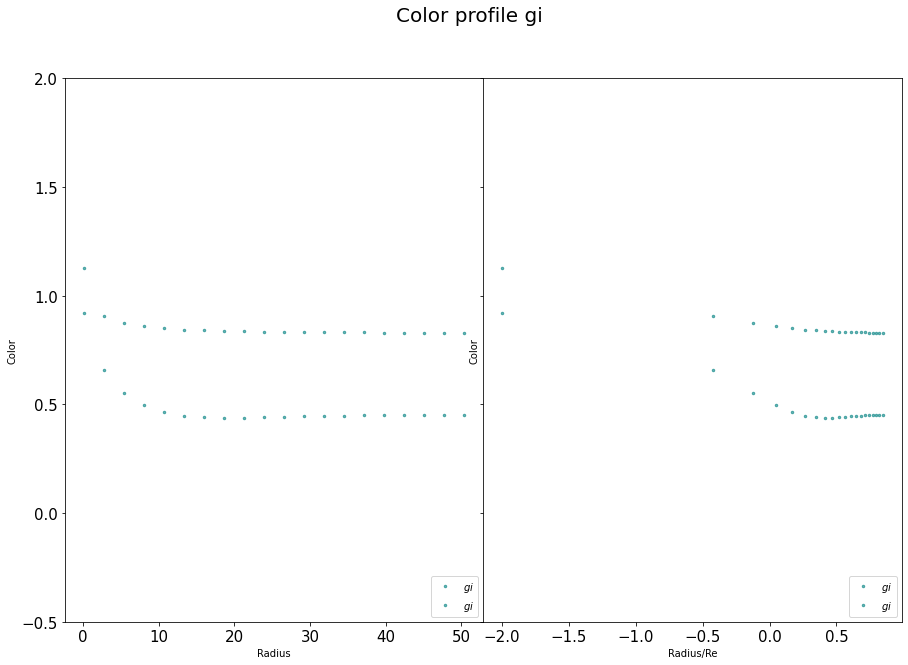

In [222]:

fig, ax = plt.subplots(1, 2, figsize=(15,10), sharey='row', squeeze=False)
fig.subplots_adjust(wspace=0)
fig.suptitle('Color profile gi', fontsize=20)


ax[0][0].set_xlabel('Radius')
ax[0][0].set_ylabel('Color')
ax[0][0].set_ylim(-0.5, 2)
ax[0][0].plot(R, Color_gr ,'.', color='teal' ,  markersize=5, alpha=0.6, label='$gi$')
ax[0][0].legend(loc='lower right')
# ax[0][0].set_xlim(0,15)

ax[0][1].set_xlabel('Radius/Re')
ax[0][1].set_ylabel('Color')
ax[0][1].set_ylim(-0.5, 2)
ax[0][1].plot(np.log10(r), Color_gr ,'.', color='teal' ,  markersize=5, alpha=0.6, label='$gi$')
ax[0][1].legend(loc='lower right')

In [232]:
# All this is using the diamond catalog 
# m1 = 9-9.5
# m2 = 9.5-10
# m3 = 10-10.5
# m4 = 10.5-11
# m5 = 11-11.5

# Selecting mass bins
m1 = (np.log10(Ms_d) >= 9.0) & (np.log10(Ms_d) <= 9.5)
m2 = (np.log10(Ms_d) >= 9.5) & (np.log10(Ms_d) <= 10.0)
m3 = (np.log10(Ms_d) >= 10.0) & (np.log10(Ms_d) <= 10.5)
m4 = (np.log10(Ms_d) >= 10.5) & (np.log10(Ms_d) <= 11.0)
m5 = (np.log10(Ms_d) >= 11.0) & (np.log10(Ms_d) <= 11.5)

# Color in mass bins all galaxies in the i band
Color_gi_m1 = Color_gi[:1][m1]
Color_gi_m2 = Color_gi[m2]
Color_gi_m3 = Color_gi[m3]
Color_gi_m4 = Color_gi[m4]
Color_gi_m5 = Color_gi[m5]

# Effective radius in mass bins all galaxies in the i band 
Re_i_m1 = Re_i_d[m1]
Re_i_m2 = Re_i_d[m2]
Re_i_m3 = Re_i_d[m3]
Re_i_m4 = Re_i_d[m4]
Re_i_m5 = Re_i_d[m5]

# Color in mass bins all galaxies in the r band
Color_gr_m1 = Color_gr[m1]
Color_gr_m2 = Color_gr[m2]
Color_gr_m3 = Color_gr[m3]
Color_gr_m4 = Color_gr[m4]
Color_gr_m5 = Color_gr[m5]

# Effective radius in mass bins all galaxies in the r band 
Re_r_m1 = Re_r_d[m1]
Re_r_m2 = Re_r_d[m2]
Re_r_m3 = Re_r_d[m3]
Re_r_m4 = Re_r_d[m4]
Re_r_m5 = Re_r_d[m5]

# Mass bins for late type
m1_late = (np.log10(Ms_d[disk_d]) >= 9.0) & (np.log10(Ms_d[disk_d]) <= 9.5)
m2_late = (np.log10(Ms_d[disk_d]) >= 9.5) & (np.log10(Ms_d[disk_d]) <= 10.0)
m3_late = (np.log10(Ms_d[disk_d]) >= 10.0) & (np.log10(Ms_d[disk_d]) <= 10.5)
m4_late = (np.log10(Ms_d[disk_d]) >= 10.5) & (np.log10(Ms_d[disk_d]) <= 11.0)
m5_late = (np.log10(Ms_d[disk_d]) >= 11.0) & (np.log10(Ms_d[disk_d]) <= 11.5)

# Mass bins for early type
m1_early = (np.log10(Ms_d[sphr_d]) >= 9.0) & (np.log10(Ms_d[sphr_d]) <= 9.5)
m2_early = (np.log10(Ms_d[sphr_d]) >= 9.5) & (np.log10(Ms_d[sphr_d]) <= 10.0)
m3_early = (np.log10(Ms_d[sphr_d]) >= 10.0) & (np.log10(Ms_d[sphr_d]) <= 10.5)
m4_early = (np.log10(Ms_d[sphr_d]) >= 10.5) & (np.log10(Ms_d[sphr_d]) <= 11.0)
m5_early = (np.log10(Ms_d[sphr_d]) >= 11.0) & (np.log10(Ms_d[sphr_d]) <= 11.5)

# Color in both bands for late type
Color_gi_late = Color_gi[disk_d]
Color_gr_late = Color_gr[disk_d]

# Color in both bands for early type
Color_gi_early = Color_gi[sphr_d]
Color_gr_early = Color_gr[sphr_d]

# Color in mass bins for late types in the i band 
Color_gi_m1_late = Color_gi_late[m1_late]
Color_gi_m2_late = Color_gi_late[m2_late]
Color_gi_m3_late = Color_gi_late[m3_late]
Color_gi_m4_late = Color_gi_late[m4_late]
Color_gi_m5_late = Color_gi_late[m5_late]

# Color in mass bins for early types in the i band 
Color_gi_m1_early = Color_gi_early[m1_early]
Color_gi_m2_early = Color_gi_early[m2_early]
Color_gi_m3_early = Color_gi_early[m3_early]
Color_gi_m4_early = Color_gi_early[m4_early]
Color_gi_m5_early = Color_gi_early[m5_early]

# Color in mass bins for late types in the r band 
Color_gr_m1_late = Color_gr_late[m1_late]
Color_gr_m2_late = Color_gr_late[m2_late]
Color_gr_m3_late = Color_gr_late[m3_late]
Color_gr_m4_late = Color_gr_late[m4_late]
Color_gr_m5_late = Color_gr_late[m5_late]

# Color in mass bins for early types in the r band 
Color_gr_m1_early = Color_gr_early[m1_early]
Color_gr_m2_early = Color_gr_early[m2_early]
Color_gr_m3_early = Color_gr_early[m3_early]
Color_gr_m4_early = Color_gr_early[m4_early]
Color_gr_m5_early = Color_gr_early[m5_early]

# Radii in i and r bands for late types
Re_i_late = Re_i_d[disk_d]
Re_r_late = Re_r_d[disk_d]

# Radii in i and r bands for early types
Re_i_early = Re_i_d[sphr_d]
Re_r_early = Re_r_d[sphr_d]

# Late radii in the i band in mass bins
Re_i_m1_late = Re_i_late[m1_late]
Re_i_m2_late = Re_i_late[m2_late]
Re_i_m3_late = Re_i_late[m3_late]
Re_i_m4_late = Re_i_late[m4_late]
Re_i_m5_late = Re_i_late[m5_late]

# Early radii in the i band in mass bins
Re_i_m1_early = Re_i_early[m1_early]
Re_i_m2_early = Re_i_early[m2_early]
Re_i_m3_early = Re_i_early[m3_early]
Re_i_m4_early = Re_i_early[m4_early]
Re_i_m5_early = Re_i_early[m5_early]

# Late radii in the r band in mass bins
Re_r_m1_late = Re_r_late[m1_late]
Re_r_m2_late = Re_r_late[m2_late]
Re_r_m3_late = Re_r_late[m3_late]
Re_r_m4_late = Re_r_late[m4_late]
Re_r_m5_late = Re_r_late[m5_late]

# Early radii in the r band in mass bins
Re_r_m1_early = Re_r_early[m1_early]
Re_r_m2_early = Re_r_early[m2_early]
Re_r_m3_early = Re_r_early[m3_early]
Re_r_m4_early = Re_r_early[m4_early]
Re_r_m5_early = Re_r_early[m5_early]


IndexError: boolean index did not match indexed array along dimension 0; dimension is 1 but corresponding boolean dimension is 37486

In [227]:
np.size(Color_gi)

749720

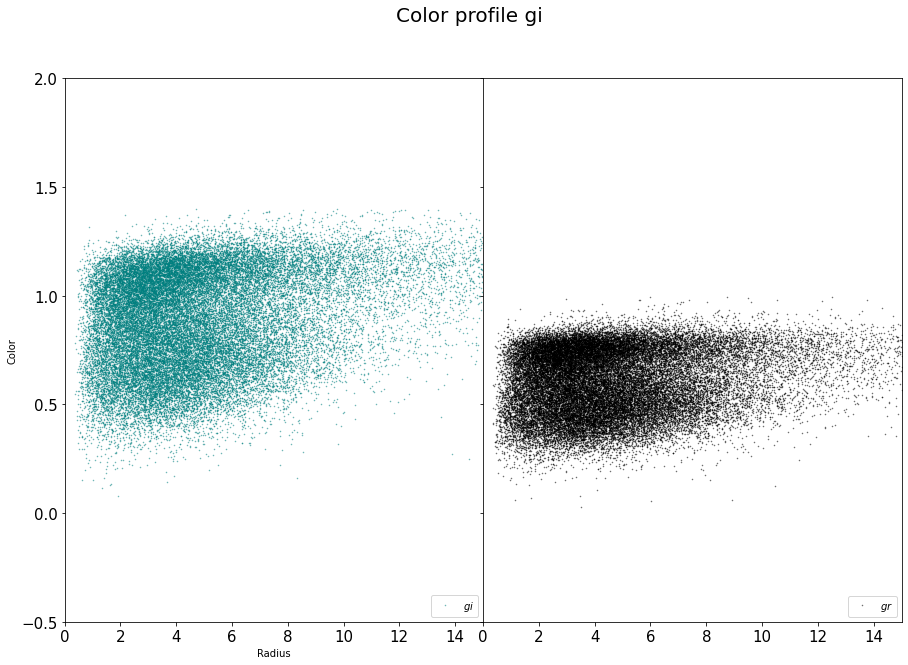

In [167]:
# Color profile for all galaxies in the i and r bands 
# r = np.logspace(-1, 1.2, 37486)

fig, ax = plt.subplots(1, 2, figsize=(15,10), sharey='row', squeeze=False)
fig.subplots_adjust(wspace=0)
fig.suptitle('Color profile gi', fontsize=20)


ax[0][0].set_xlabel('Radius')
ax[0][0].set_ylabel('Color')
ax[0][0].set_ylim(-0.5, 2)


ax[0][0].plot(Re_i_d, Color_gi ,'.', color='teal' , marker='.', markersize=1, alpha=0.6, label='$gi$')
ax[0][0].legend(loc='lower right')
ax[0][0].set_xlim(0,15)

ax[0][1].plot(Re_r_d, Color_gr ,'.', color='black' , marker='.', markersize=1, alpha=0.6, label='$gr$')
ax[0][1].legend(loc='lower right')
ax[0][1].set_xlim(0,15)


label_size = 15
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size


In [172]:
ng = catalog_diamond['nsersic_g']
nr = catalog_diamond['nsersic_r']
ng[:1]

array([0.9907])

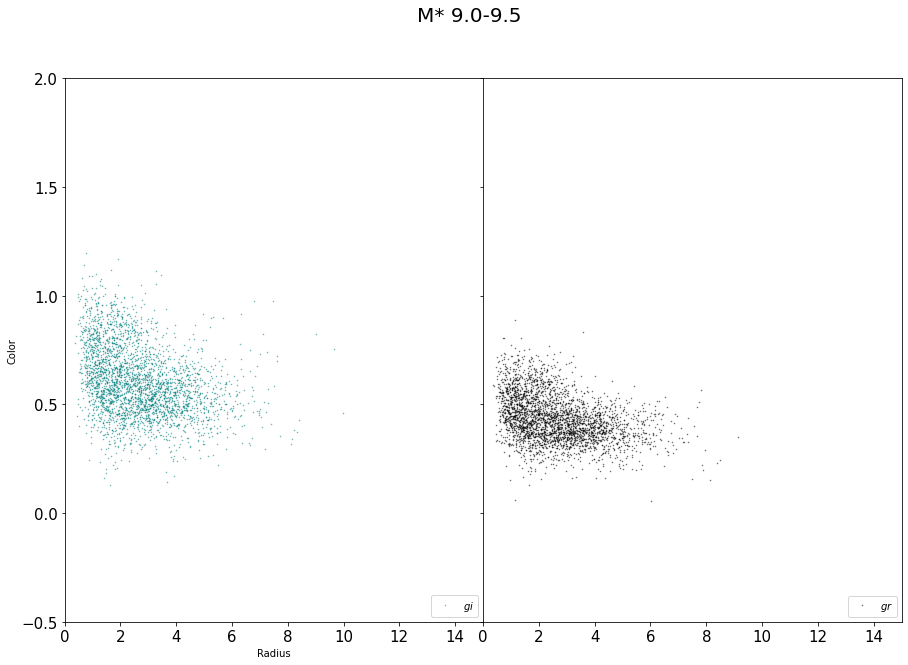

In [169]:
# Color profile for all galaxies in the i and r band for M* 9.0-9.5

fig, ax = plt.subplots(1, 2, figsize=(15,10), sharey='row', squeeze=False)
fig.subplots_adjust(wspace=0)
fig.suptitle('M* 9.0-9.5', fontsize=20)


ax[0][0].set_xlabel('Radius')
ax[0][0].set_ylabel('Color')
ax[0][0].set_ylim(-0.5, 2)


ax[0][0].plot(Re_i_m1, Color_gi_m1 ,'.', color='teal' , marker='.', markersize=1, alpha=0.6, label='$gi$')
ax[0][0].legend(loc='lower right')
ax[0][0].set_xlim(0,15)

ax[0][1].plot(Re_r_m1, Color_gr_m1 ,'.', color='black' , marker='.', markersize=1, alpha=0.6, label='$gr$')
ax[0][1].legend(loc='lower right')
ax[0][1].set_xlim(0,15)


label_size = 15
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size


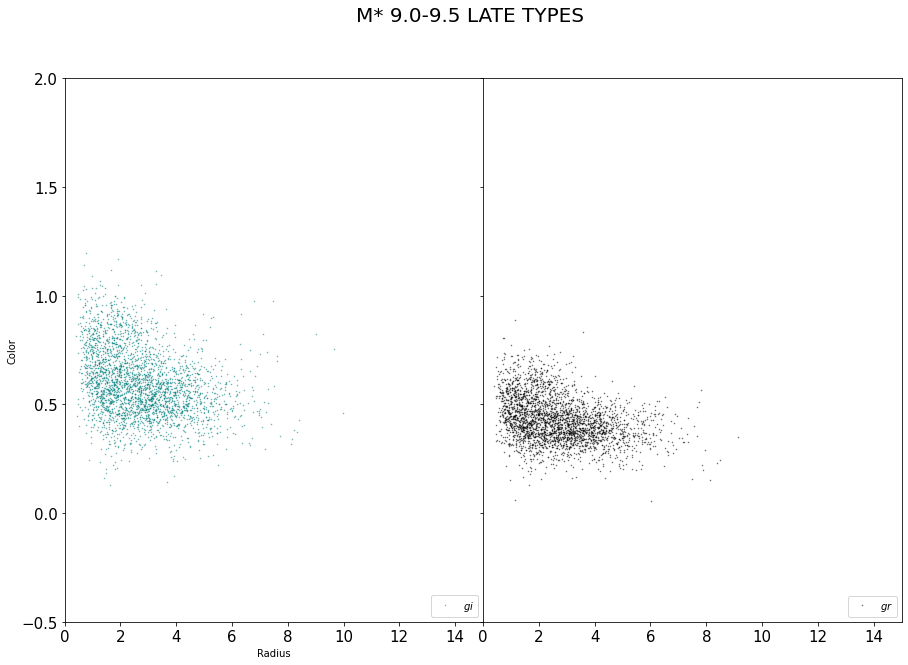

In [151]:
# Color profile for late galaxies in the i and r band for M* 9.0-9.5

fig, ax = plt.subplots(1, 2, figsize=(15,10), sharey='row', squeeze=False)
fig.subplots_adjust(wspace=0)
fig.suptitle('M* 9.0-9.5 LATE TYPES', fontsize=20)


ax[0][0].set_xlabel('Radius')
ax[0][0].set_ylabel('Color')
ax[0][0].set_ylim(-0.5, 2)


ax[0][0].plot(Re_i_m1_late, Color_gi_m1_late ,'.', color='teal' , marker='.', markersize=1, alpha=0.6, label='$gi$')
ax[0][0].legend(loc='lower right')
ax[0][0].set_xlim(0,15)

ax[0][1].plot(Re_r_m1_late, Color_gr_m1_late ,'.', color='black' , marker='.', markersize=1, alpha=0.6, label='$gr$')
ax[0][1].legend(loc='lower right')
ax[0][1].set_xlim(0,15)


label_size = 15
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

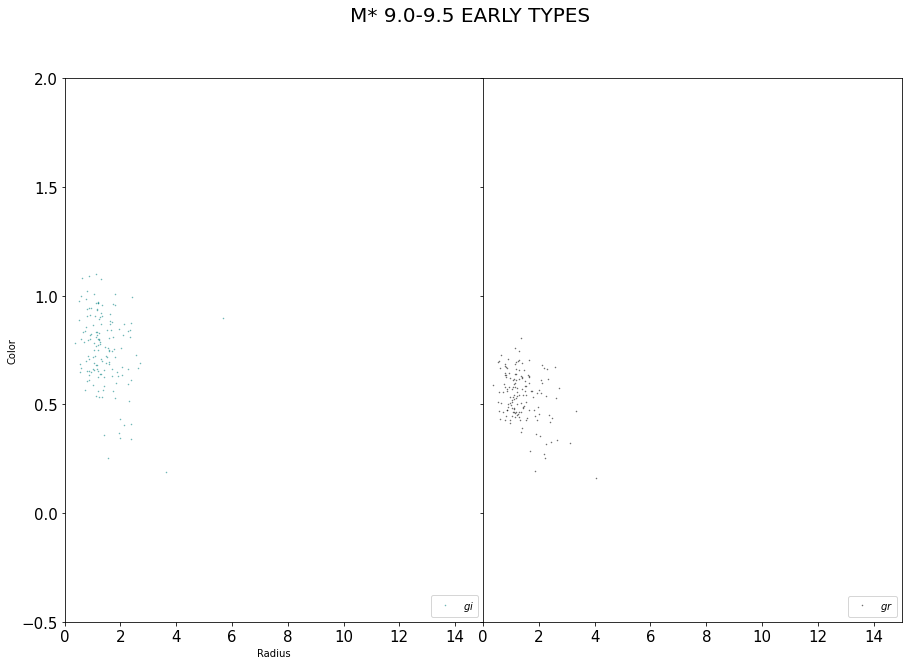

In [157]:
# Color profile for early galaxies in the i and r band for M* 9.0-9.5

fig, ax = plt.subplots(1, 2, figsize=(15,10), sharey='row', squeeze=False)
fig.subplots_adjust(wspace=0)
fig.suptitle('M* 9.0-9.5 EARLY TYPES', fontsize=20)


ax[0][0].set_xlabel('Radius')
ax[0][0].set_ylabel('Color')
ax[0][0].set_ylim(-0.5, 2)


ax[0][0].plot(Re_i_m1_early, Color_gi_m1_early ,'.', color='teal' , marker='.', markersize=1, alpha=0.6, label='$gi$')
ax[0][0].legend(loc='lower right')
ax[0][0].set_xlim(0,15)

ax[0][1].plot(Re_r_m1_early, Color_gr_m1_early ,'.', color='black' , marker='.', markersize=1, alpha=0.6, label='$gr$')
ax[0][1].legend(loc='lower right')
ax[0][1].set_xlim(0,15)


label_size = 15
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

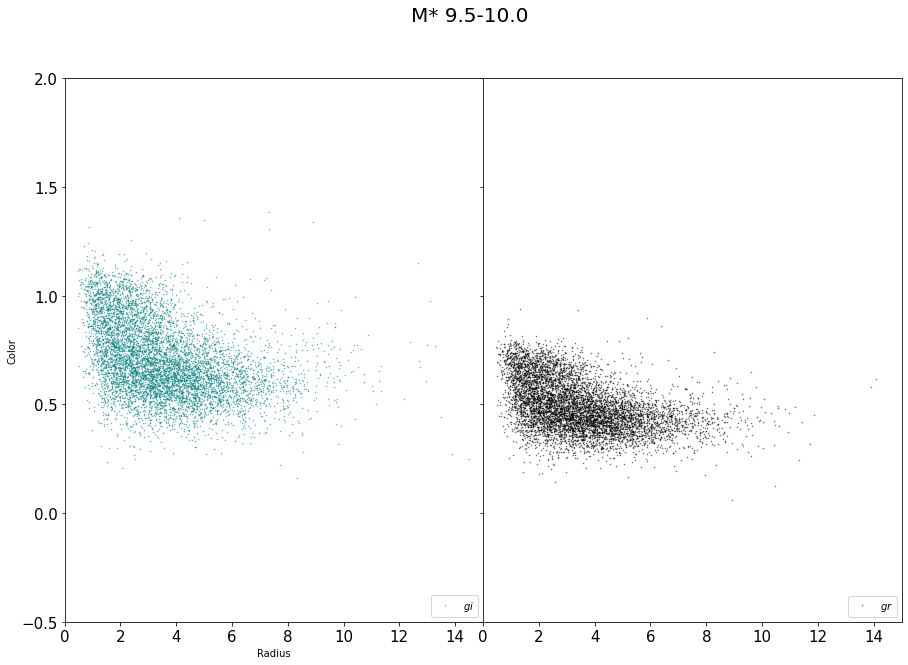

In [122]:
# Color profile for all galaxies in the i and r band for M* 9.5-10.0

fig, ax = plt.subplots(1, 2, figsize=(15,10), sharey='row', squeeze=False)
fig.subplots_adjust(wspace=0)
fig.suptitle('M* 9.5-10.0', fontsize=20)


ax[0][0].set_xlabel('Radius')
ax[0][0].set_ylabel('Color')
ax[0][0].set_ylim(-0.5, 2)


ax[0][0].plot(Re_i_m2, Color_gi_m2 ,'.', color='teal' , marker='.', markersize=1, alpha=0.6, label='$gi$')
ax[0][0].legend(loc='lower right')
ax[0][0].set_xlim(0,15)

ax[0][1].plot(Re_r_m2, Color_gr_m2 ,'.', color='black' , marker='.', markersize=1, alpha=0.6, label='$gr$')
ax[0][1].legend(loc='lower right')
ax[0][1].set_xlim(0,15)


label_size = 15
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

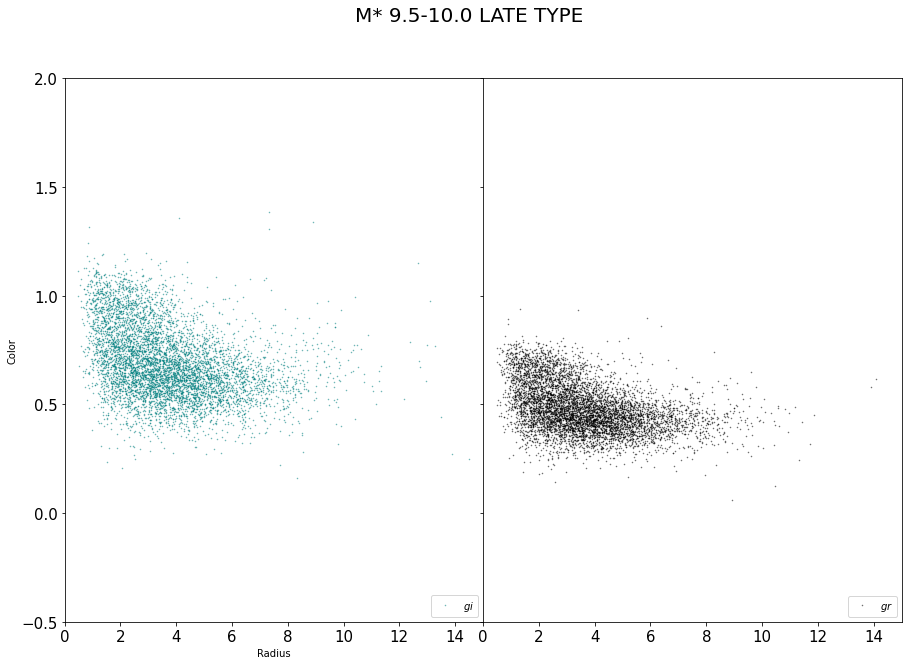

In [158]:
# Color profile for late galaxies in the i and r band for M* 9.5-10.0

fig, ax = plt.subplots(1, 2, figsize=(15,10), sharey='row', squeeze=False)
fig.subplots_adjust(wspace=0)
fig.suptitle('M* 9.5-10.0 LATE TYPE', fontsize=20)


ax[0][0].set_xlabel('Radius')
ax[0][0].set_ylabel('Color')
ax[0][0].set_ylim(-0.5, 2)


ax[0][0].plot(Re_i_m2_late, Color_gi_m2_late ,'.', color='teal' , marker='.', markersize=1, alpha=0.6, label='$gi$')
ax[0][0].legend(loc='lower right')
ax[0][0].set_xlim(0,15)

ax[0][1].plot(Re_r_m2_late, Color_gr_m2_late ,'.', color='black' , marker='.', markersize=1, alpha=0.6, label='$gr$')
ax[0][1].legend(loc='lower right')
ax[0][1].set_xlim(0,15)


label_size = 15
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

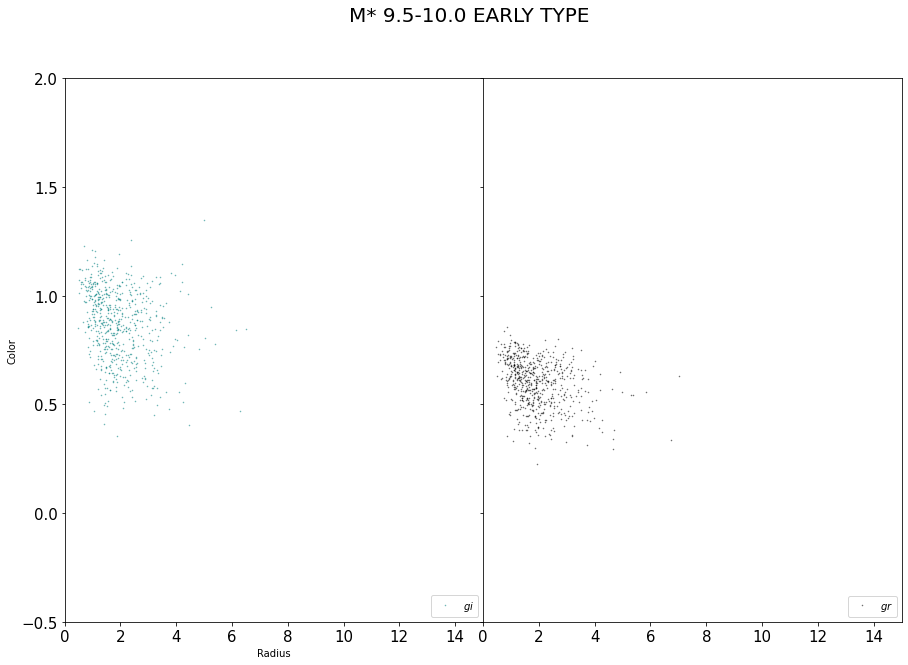

In [159]:
# Color profile for early galaxies in the i and r band for M* 9.5-10.0

fig, ax = plt.subplots(1, 2, figsize=(15,10), sharey='row', squeeze=False)
fig.subplots_adjust(wspace=0)
fig.suptitle('M* 9.5-10.0 EARLY TYPE', fontsize=20)


ax[0][0].set_xlabel('Radius')
ax[0][0].set_ylabel('Color')
ax[0][0].set_ylim(-0.5, 2)


ax[0][0].plot(Re_i_m2_early, Color_gi_m2_early ,'.', color='teal' , marker='.', markersize=1, alpha=0.6, label='$gi$')
ax[0][0].legend(loc='lower right')
ax[0][0].set_xlim(0,15)

ax[0][1].plot(Re_r_m2_early, Color_gr_m2_early ,'.', color='black' , marker='.', markersize=1, alpha=0.6, label='$gr$')
ax[0][1].legend(loc='lower right')
ax[0][1].set_xlim(0,15)


label_size = 15
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

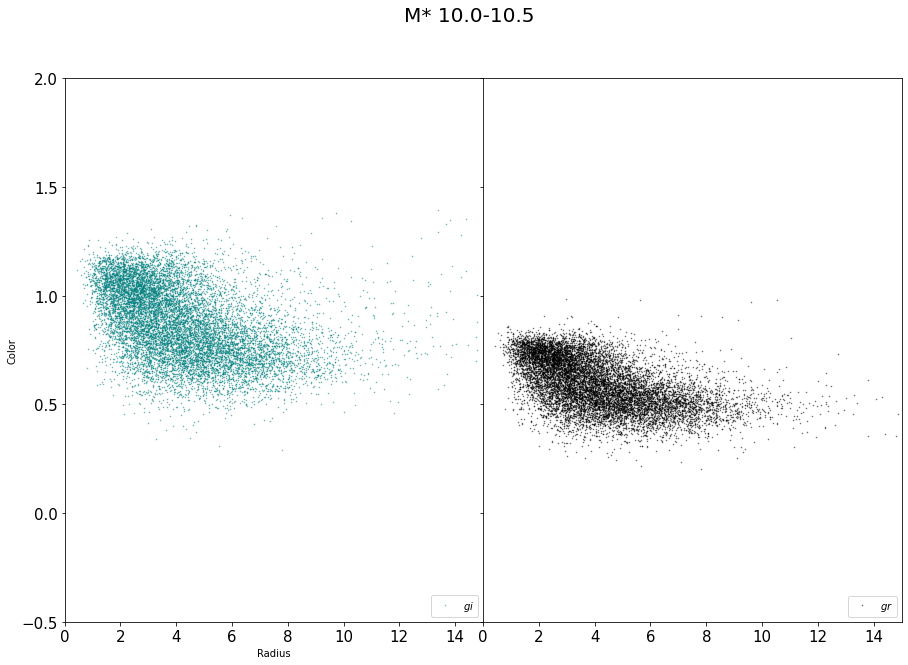

In [121]:
# Color profile for all galaxies in the i and r band for M* 10.0-10.5

fig, ax = plt.subplots(1, 2, figsize=(15,10), sharey='row', squeeze=False)
fig.subplots_adjust(wspace=0)
fig.suptitle('M* 10.0-10.5', fontsize=20)


ax[0][0].set_xlabel('Radius')
ax[0][0].set_ylabel('Color')
ax[0][0].set_ylim(-0.5, 2)


ax[0][0].plot(Re_i_m3, Color_gi_m3 ,'.', color='teal' , marker='.', markersize=1, alpha=0.6, label='$gi$')
ax[0][0].legend(loc='lower right')
ax[0][0].set_xlim(0,15)

ax[0][1].plot(Re_r_m3, Color_gr_m3 ,'.', color='black' , marker='.', markersize=1, alpha=0.6, label='$gr$')
ax[0][1].legend(loc='lower right')
ax[0][1].set_xlim(0,15)


label_size = 15
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

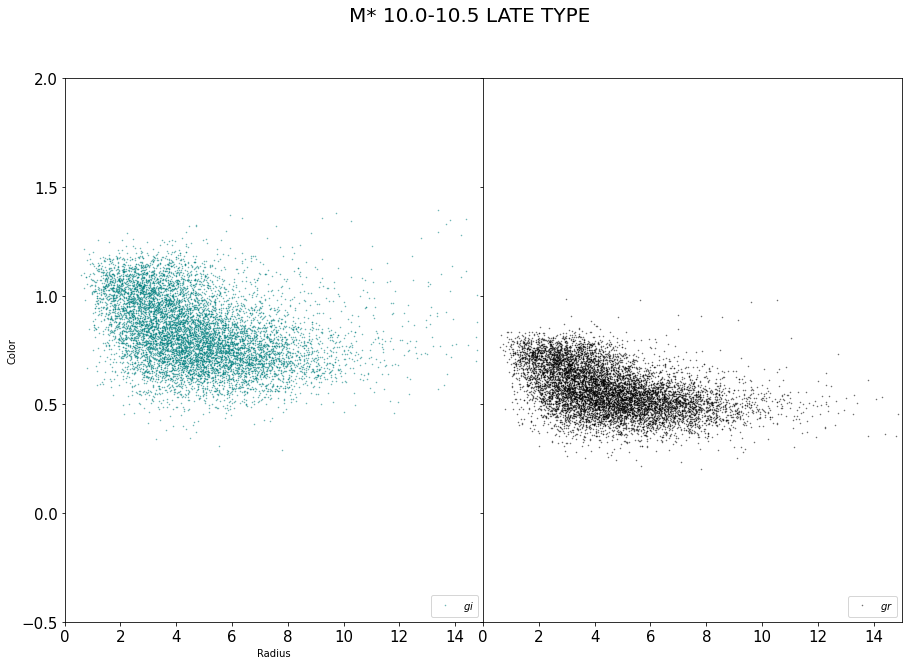

In [160]:
# Color profile for late galaxies in the i and r band for M* 10.0-10.5

fig, ax = plt.subplots(1, 2, figsize=(15,10), sharey='row', squeeze=False)
fig.subplots_adjust(wspace=0)
fig.suptitle('M* 10.0-10.5 LATE TYPE', fontsize=20)


ax[0][0].set_xlabel('Radius')
ax[0][0].set_ylabel('Color')
ax[0][0].set_ylim(-0.5, 2)


ax[0][0].plot(Re_i_m3_late, Color_gi_m3_late ,'.', color='teal' , marker='.', markersize=1, alpha=0.6, label='$gi$')
ax[0][0].legend(loc='lower right')
ax[0][0].set_xlim(0,15)

ax[0][1].plot(Re_r_m3_late, Color_gr_m3_late ,'.', color='black' , marker='.', markersize=1, alpha=0.6, label='$gr$')
ax[0][1].legend(loc='lower right')
ax[0][1].set_xlim(0,15)


label_size = 15
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

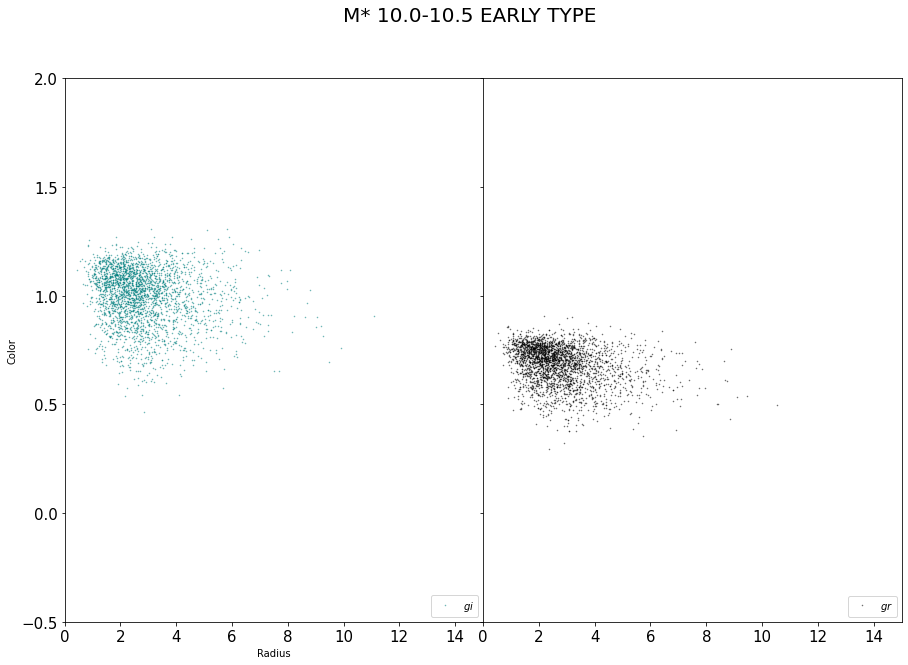

In [162]:
# Color profile for early galaxies in the i and r band for M* 10.0-10.5

fig, ax = plt.subplots(1, 2, figsize=(15,10), sharey='row', squeeze=False)
fig.subplots_adjust(wspace=0)
fig.suptitle('M* 10.0-10.5 EARLY TYPE', fontsize=20)


ax[0][0].set_xlabel('Radius')
ax[0][0].set_ylabel('Color')
ax[0][0].set_ylim(-0.5, 2)


ax[0][0].plot(Re_i_m3_early, Color_gi_m3_early ,'.', color='teal' , marker='.', markersize=1, alpha=0.6, label='$gi$')
ax[0][0].legend(loc='lower right')
ax[0][0].set_xlim(0,15)

ax[0][1].plot(Re_r_m3_early, Color_gr_m3_early ,'.', color='black' , marker='.', markersize=1, alpha=0.6, label='$gr$')
ax[0][1].legend(loc='lower right')
ax[0][1].set_xlim(0,15)


label_size = 15
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

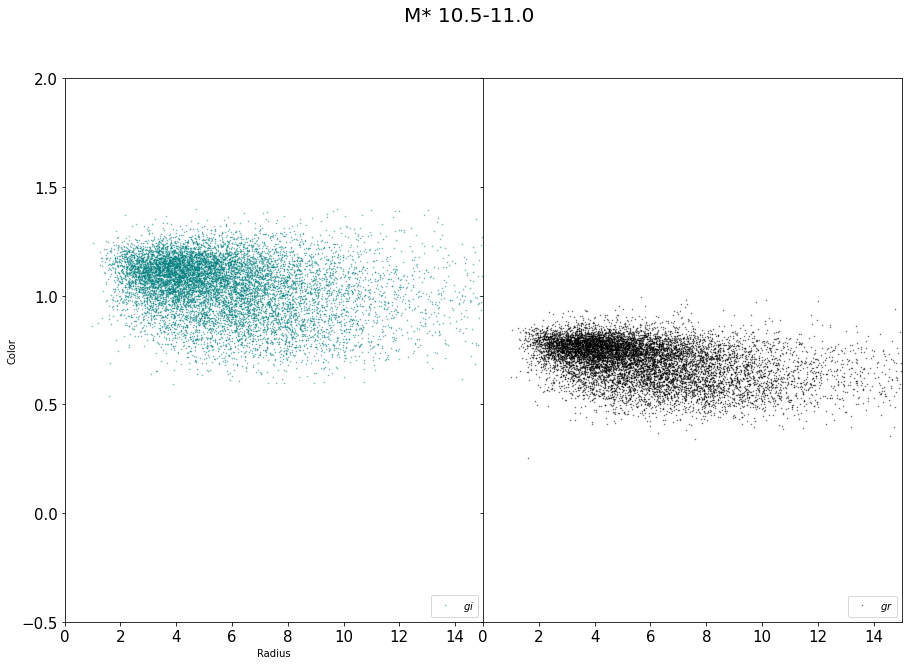

In [156]:
# Color profile for all galaxies in the i and r band for M* 10.5-11.0

fig, ax = plt.subplots(1, 2, figsize=(15,10), sharey='row', squeeze=False)
fig.subplots_adjust(wspace=0)
fig.suptitle('M* 10.5-11.0', fontsize=20)


ax[0][0].set_xlabel('Radius')
ax[0][0].set_ylabel('Color')
ax[0][0].set_ylim(-0.5, 2)


ax[0][0].plot(Re_i_m4, Color_gi_m4 ,'.', color='teal' , marker='.', markersize=1, alpha=0.6, label='$gi$')
ax[0][0].legend(loc='lower right')
ax[0][0].set_xlim(0,15)

ax[0][1].plot(Re_i_m4, Color_gr_m4 ,'.', color='black' , marker='.', markersize=1, alpha=0.6, label='$gr$')
ax[0][1].legend(loc='lower right')
ax[0][1].set_xlim(0,15)


label_size = 15
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

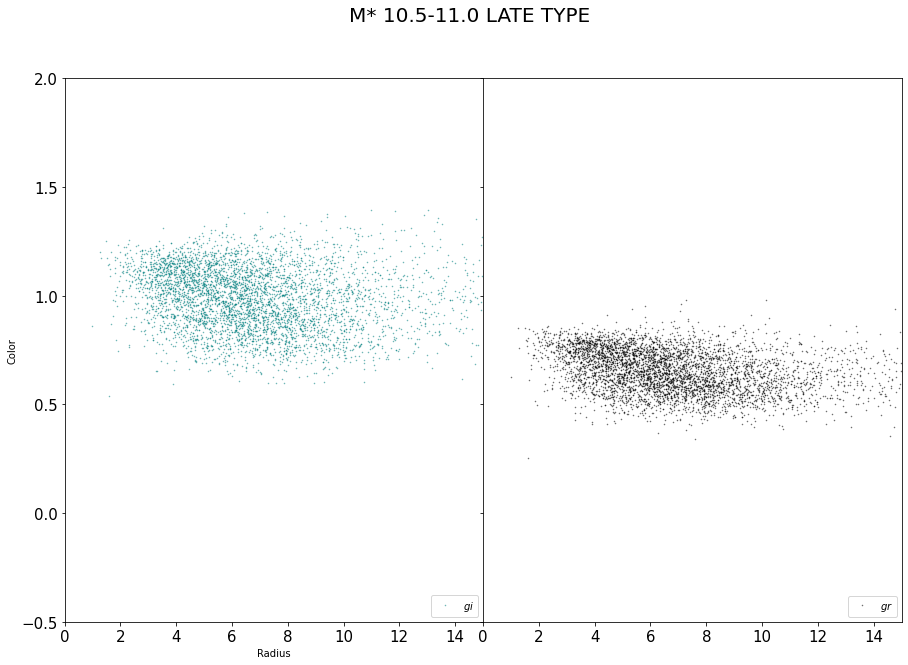

In [163]:
# Color profile for late galaxies in the i and r band for M* 10.5-11.0

fig, ax = plt.subplots(1, 2, figsize=(15,10), sharey='row', squeeze=False)
fig.subplots_adjust(wspace=0)
fig.suptitle('M* 10.5-11.0 LATE TYPE', fontsize=20)


ax[0][0].set_xlabel('Radius')
ax[0][0].set_ylabel('Color')
ax[0][0].set_ylim(-0.5, 2)


ax[0][0].plot(Re_i_m4_late, Color_gi_m4_late ,'.', color='teal' , marker='.', markersize=1, alpha=0.6, label='$gi$')
ax[0][0].legend(loc='lower right')
ax[0][0].set_xlim(0,15)

ax[0][1].plot(Re_i_m4_late, Color_gr_m4_late ,'.', color='black' , marker='.', markersize=1, alpha=0.6, label='$gr$')
ax[0][1].legend(loc='lower right')
ax[0][1].set_xlim(0,15)


label_size = 15
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

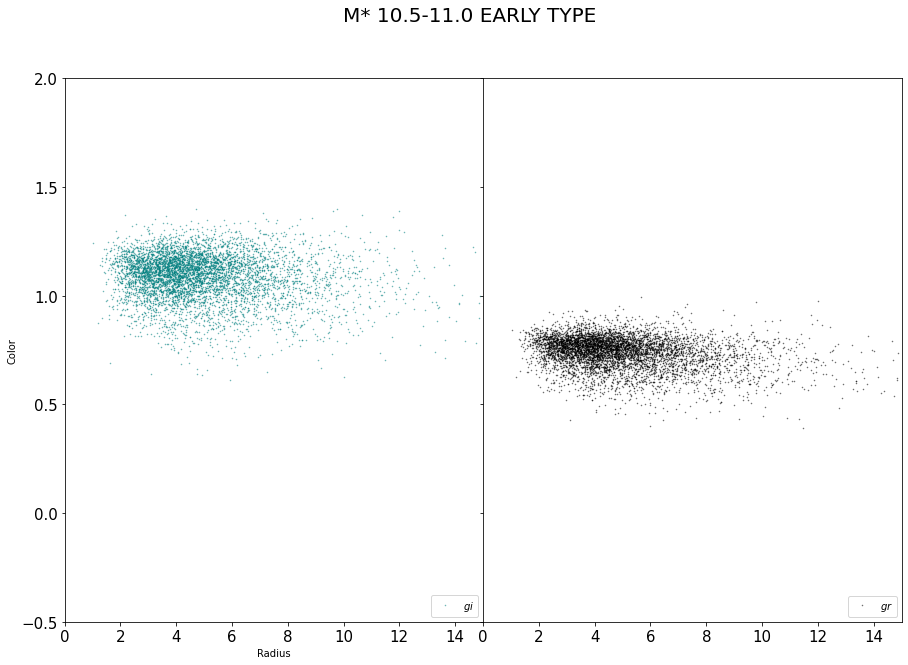

In [164]:
# Color profile for early galaxies in the i and r band for M* 10.5-11.0

fig, ax = plt.subplots(1, 2, figsize=(15,10), sharey='row', squeeze=False)
fig.subplots_adjust(wspace=0)
fig.suptitle('M* 10.5-11.0 EARLY TYPE', fontsize=20)


ax[0][0].set_xlabel('Radius')
ax[0][0].set_ylabel('Color')
ax[0][0].set_ylim(-0.5, 2)


ax[0][0].plot(Re_i_m4_early, Color_gi_m4_early ,'.', color='teal' , marker='.', markersize=1, alpha=0.6, label='$gi$')
ax[0][0].legend(loc='lower right')
ax[0][0].set_xlim(0,15)

ax[0][1].plot(Re_i_m4_early, Color_gr_m4_early ,'.', color='black' , marker='.', markersize=1, alpha=0.6, label='$gr$')
ax[0][1].legend(loc='lower right')
ax[0][1].set_xlim(0,15)


label_size = 15
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

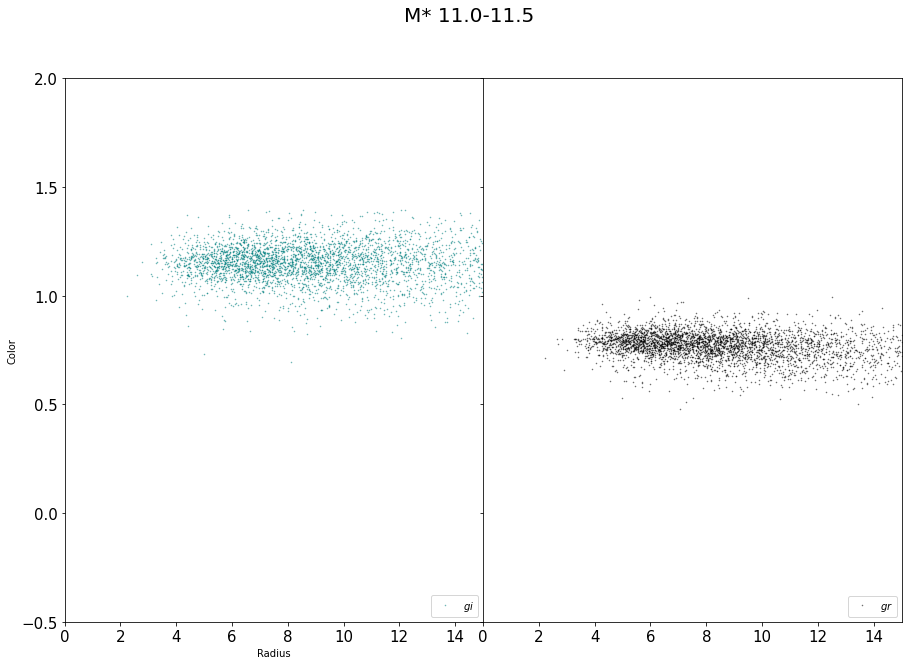

In [118]:
# Color profile for all galaxies in the i and r band for M* 11.0-11.5

fig, ax = plt.subplots(1, 2, figsize=(15,10), sharey='row', squeeze=False)
fig.subplots_adjust(wspace=0)
fig.suptitle('M* 11.0-11.5', fontsize=20)


ax[0][0].set_xlabel('Radius')
ax[0][0].set_ylabel('Color')
ax[0][0].set_ylim(-0.5, 2)


ax[0][0].plot(Re_i_m5, Color_gi_m5 ,'.', color='teal' , marker='.', markersize=1, alpha=0.6, label='$gi$')
ax[0][0].legend(loc='lower right')
ax[0][0].set_xlim(0,15)

ax[0][1].plot(Re_r_m5, Color_gr_m5 ,'.', color='black' , marker='.', markersize=1, alpha=0.6, label='$gr$')
ax[0][1].legend(loc='lower right')
ax[0][1].set_xlim(0,15)


label_size = 15
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size


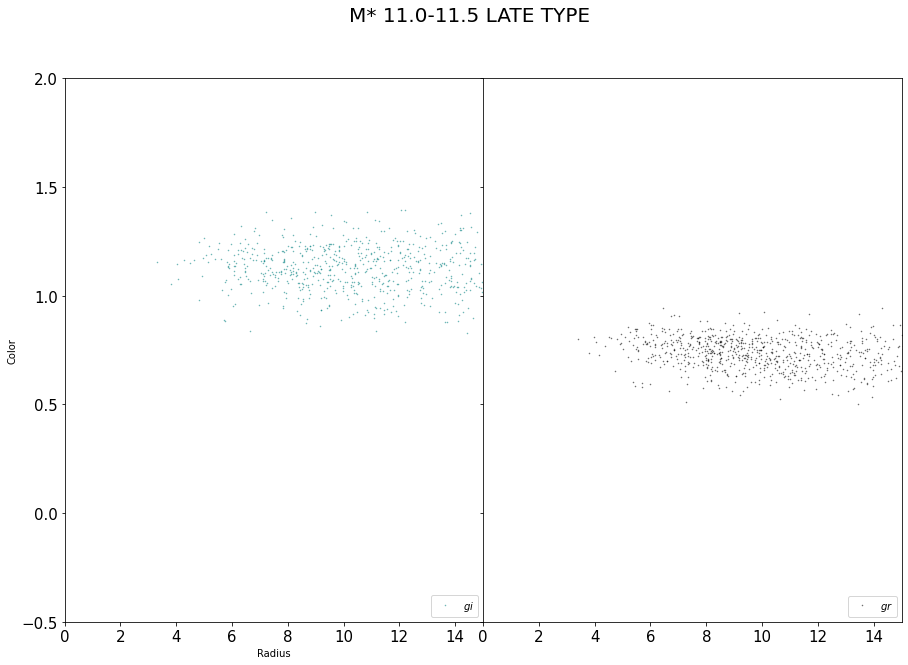

In [165]:
# Color profile for late galaxies in the i and r band for M* 11.0-11.5

fig, ax = plt.subplots(1, 2, figsize=(15,10), sharey='row', squeeze=False)
fig.subplots_adjust(wspace=0)
fig.suptitle('M* 11.0-11.5 LATE TYPE', fontsize=20)


ax[0][0].set_xlabel('Radius')
ax[0][0].set_ylabel('Color')
ax[0][0].set_ylim(-0.5, 2)


ax[0][0].plot(Re_i_m5_late, Color_gi_m5_late ,'.', color='teal' , marker='.', markersize=1, alpha=0.6, label='$gi$')
ax[0][0].legend(loc='lower right')
ax[0][0].set_xlim(0,15)

ax[0][1].plot(Re_r_m5_late, Color_gr_m5_late ,'.', color='black' , marker='.', markersize=1, alpha=0.6, label='$gr$')
ax[0][1].legend(loc='lower right')
ax[0][1].set_xlim(0,15)


label_size = 15
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size


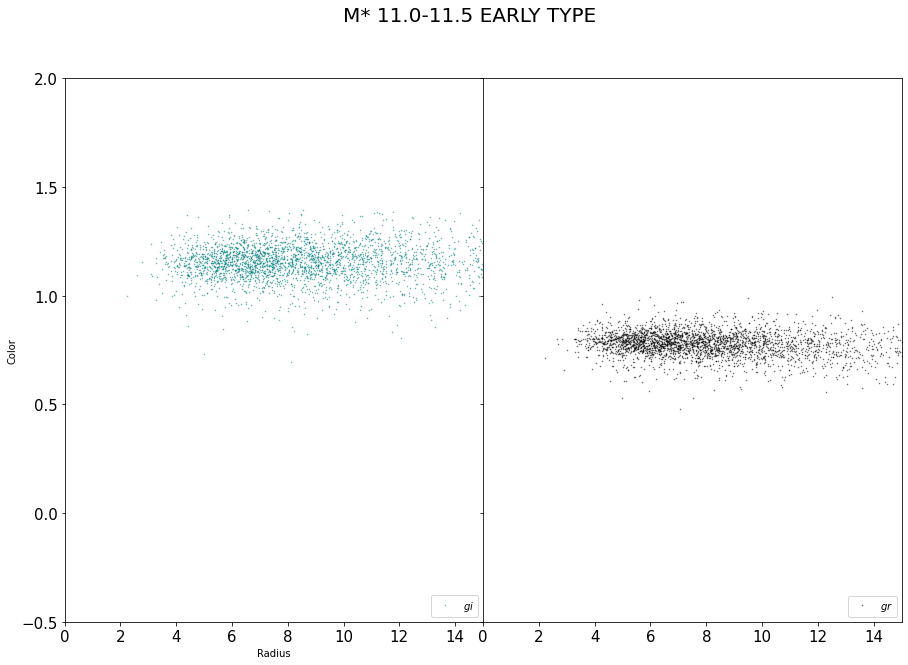

In [166]:
# Color profile for early galaxies in the i and r band for M* 11.0-11.5

fig, ax = plt.subplots(1, 2, figsize=(15,10), sharey='row', squeeze=False)
fig.subplots_adjust(wspace=0)
fig.suptitle('M* 11.0-11.5 EARLY TYPE', fontsize=20)


ax[0][0].set_xlabel('Radius')
ax[0][0].set_ylabel('Color')
ax[0][0].set_ylim(-0.5, 2)


ax[0][0].plot(Re_i_m5_early, Color_gi_m5_early ,'.', color='teal' , marker='.', markersize=1, alpha=0.6, label='$gi$')
ax[0][0].legend(loc='lower right')
ax[0][0].set_xlim(0,15)

ax[0][1].plot(Re_r_m5_early, Color_gr_m5_early ,'.', color='black' , marker='.', markersize=1, alpha=0.6, label='$gr$')
ax[0][1].legend(loc='lower right')
ax[0][1].set_xlim(0,15)


label_size = 15
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

In [124]:

# Making variables of the radii ratios in the r band

ratio_gi = Re_ste_gi/Re_r_gi
ratio_gr_B = Re_ste_gr_B/Re_r_grB
ratio_gi_B = Re_ste_gi_B/Re_r_giB
ratio_gr_Z = Re_ste_gr_Z/Re_r_grZ
ratio_gi_Z = Re_ste_gi_Z/Re_r_giZ
ratio_d = Re_ste_d/Re_r_d

# Making variables of the radii ratio in the g band

ratio_g_gi = Re_ste_gi/Re_g_gi
ratio_g_gr_B = Re_ste_gr_B/Re_g_grB
ratio_g_gi_B = Re_ste_gi_B/Re_g_giB
ratio_g_gr_Z = Re_ste_gr_Z/Re_g_grZ
ratio_g_gi_Z = Re_ste_gi_Z/Re_g_giZ
ratio_g_d = Re_ste_d/Re_g_d


# Late radii ratios r band
r_gi_late = ratio_gi[disk_gi]
r_gr_B_late = ratio_gr_B[disk_grB]
r_gi_B_late = ratio_gi_B[disk_giB]
r_gr_Z_late = ratio_gr_Z[disk_grZ]
r_gi_Z_late = ratio_gi_Z[disk_giZ]
r_d_late = ratio_d[disk_d]

# Late radii ratios g band
r_g_gi_late = ratio_g_gi[disk_gi]
r_g_gr_B_late = ratio_g_gr_B[disk_grB]
r_g_gi_B_late = ratio_g_gi_B[disk_giB]
r_g_gr_Z_late = ratio_g_gr_Z[disk_grZ]
r_g_gi_Z_late = ratio_g_gi_Z[disk_giZ]
r_g_d_late = ratio_g_d[disk_d]

# Early radii ratios r band
r_gi_early = ratio_gi[sphr_gi]
r_gr_B_early = ratio_gr_B[sphr_grB]
r_gi_B_early = ratio_gi_B[sphr_giB]
r_gr_Z_early = ratio_gr_Z[sphr_grZ]
r_gi_Z_early = ratio_gi_Z[sphr_giZ]
r_d_early = ratio_d[sphr_d]

# Early radii ratios g band
r_g_gi_early = ratio_g_gi[sphr_gi]
r_g_gr_B_early = ratio_g_gr_B[sphr_grB]
r_g_gi_B_early = ratio_g_gi_B[sphr_giB]
r_g_gr_Z_early = ratio_g_gr_Z[sphr_grZ]
r_g_gi_Z_early = ratio_g_gi_Z[sphr_giZ]
r_g_d_early = ratio_g_d[sphr_d]


# ### These are only for Taylor radii, no ratio, in the r band 
re_gi_early = Re_ste_gi[sphr_gi]
re_gi_late = Re_ste_gi[disk_gi]
re_r_early = Re_r_gi[sphr_gi]
re_r_late = Re_r_gi[disk_gi]

# ### These are only for diamond radii, no ratio, in the r band
re_d_early = Re_ste_d[sphr_d]
re_d_late = Re_ste_d[disk_d]
re_r_d_early = Re_r_d[sphr_d]
re_r_d_late = Re_r_d[disk_d]

# Late masses

Ms_gi_late = Ms_gi[disk_gi]
Ms_gr_B_late = Ms_gr_B[disk_grB]
Ms_gi_B_late = Ms_gi_B[disk_giB]
Ms_gr_Z_late = Ms_gr_Z[disk_grZ]
Ms_gi_Z_late = Ms_gi_Z[disk_giZ]
Ms_d_late = Ms_d[disk_d]

# Early masses

Ms_gi_early = Ms_gi[sphr_gi]
Ms_gr_B_early = Ms_gr_B[sphr_grB]
Ms_gi_B_early = Ms_gi_B[sphr_giB]
Ms_gr_Z_early = Ms_gr_Z[sphr_grZ]
Ms_gi_Z_early = Ms_gi_Z[sphr_giZ]
Ms_d_early = Ms_d[sphr_d]


# Sigma1 Taylor early late

S1_gi_late = S1_gi[disk_gi]
S1_gi_early = S1_gi[sphr_gi]

# Sigma1 Taylor early late

S1_d_late = S1_d[disk_d]
S1_d_early = S1_d[sphr_d]

# 3D ratios Taylor in the r band

ratio_gi_3d = Re_ste_gi_3d/Re_r_gi

# 3D early masses for Taylor

Ms_gi_early_3d = Ms_gi_3d[sphr_gi]

# 3D late masses for Taylor 

Ms_gi_late_3d = Ms_gi_3d[disk_gi]

# 3D early radii for Taylor 

re_gi_early_3d = Re_ste_gi_3d[sphr_gi]

# 3D late radii For Taylor

re_gi_late_3d = Re_ste_gi_3d[disk_gi]

# Early 3D ratios in the r band for Taylor

r_gi_early_3d = ratio_gi_3d[sphr_gi]

# Late 3D ratios in the r band for Taylor

r_gi_late_3d = ratio_gi_3d[disk_gi]



In [19]:
# Mass > 10.8 for Figure 2 Suess in the r band

Ms_d_S = Ms_d > (np.log10(10.8))
Re_ste_d_S = Re_ste_d[Ms_d_S]
Re_r_d_S = Re_r_d[Ms_d_S]

late_S = Ms_d_S & disk_d
early_S = Ms_d_S & sphr_d
z_d_late_S = z_d[late_S]
z_d_early_S = z_d[early_S]

ratio_S = Re_ste_d_S / Re_r_d_S

ratio_late_S = ratio_S[disk_d]
ratio_early_S = ratio_S[sphr_d]

# Mass > 10.8 for Figure 2 Suess in the g band

Ms_d_S = Ms_d > (np.log10(10.8))
Re_ste_d_S = Re_ste_d[Ms_d_S]
Re_g_d_S = Re_g_d[Ms_d_S]

late_S = Ms_d_S & disk_d
early_S = Ms_d_S & sphr_d
z_d_late_S = z_d[late_S]
z_d_early_S = z_d[early_S]

ratio_g_S = Re_ste_d_S / Re_g_d_S

ratio_g_late_S = ratio_g_S[disk_d]
ratio_g_early_S = ratio_g_S[sphr_d]

# Fuigure 5 Suess
n_r_d_late = n_r_d[disk_d]
n_r_d_early = n_r_d[sphr_d]
log_sSFR_late = log_sSFR[disk_d]
log_sSFR_early = log_sSFR[sphr_d]


In [20]:
# Suess data

Suess_q = Read('Suess_19_Qched.txt')
Suess_sf = Read('Suess_19_SFing.txt')

In [21]:
# Reading points from Suess data for Figure 2 Suess

Re_Suess_q = Suess_q['Re_mass_Re_light']
z_Suess_q = Suess_q['z']
Re_Suess_sf = Suess_sf['Re_mass_Re_light']
z_Suess_sf = Suess_sf['z']

In [22]:
# Average stellar mass. Ratio effective radii in the r band. 20 bins All galaxies
# Object count
# Stabdard deviation 

stat_gi_mean, gi_means_bins, binnum_gi_mean = scipy.stats.binned_statistic(np.log10(Ms_gi), np.log10(ratio_gi), statistic='mean', bins=20, range=(9,11.6))
stat_gr_B_mean, gr_B_means_bins, binnum_grB_mean = scipy.stats.binned_statistic(np.log10(Ms_gr_B), np.log10(ratio_gr_B), statistic='mean', bins=20, range=(9,11.6))
stat_gi_B_mean, gi_B_means_bins, binnum_giB_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_B), np.log10(ratio_gi_B), statistic='mean', bins=20, range=(9,11.6))
stat_gr_Z_mean, gr_Z_means_bins, binnum_grZ_mean = scipy.stats.binned_statistic(np.log10(Ms_gr_Z), np.log10(ratio_gr_Z), statistic='mean', bins=20, range=(9,11.6))
stat_gi_Z_mean, gi_Z_means_bins, binnum_giZ_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_Z), np.log10(ratio_gi_Z), statistic='mean', bins=20, range=(9,11.6))
stat_d_mean, d_means_bins, binnum_d_mean = scipy.stats.binned_statistic(np.log10(Ms_d), np.log10(ratio_d), statistic='mean', bins=20, range=(9,12))

stat_gi_count, gi_count_bins, binnum_gi_count  = scipy.stats.binned_statistic(np.log10(Ms_gi), np.log10(ratio_gi), statistic='count', bins=20, range=(9,11.6))
stat_gr_B_count, gr_B_count_bins, binnum_grB_count = scipy.stats.binned_statistic(np.log10(Ms_gr_B), np.log10(ratio_gr_B), statistic='count', bins=20, range=(9,11.6))
stat_gi_B_count, gi_B_count_bins, binnum_giB_count = scipy.stats.binned_statistic(np.log10(Ms_gi_B), np.log10(ratio_gi_B), statistic='count', bins=20, range=(9,11.6))
stat_gr_Z_count, gr_Z_count_bins, binnum_grZ_count = scipy.stats.binned_statistic(np.log10(Ms_gr_Z), np.log10(ratio_gr_Z), statistic='count', bins=20, range=(9,11.6))
stat_gi_Z_count, gi_Z_count_bins, binnum_giZ_count = scipy.stats.binned_statistic(np.log10(Ms_gi_Z), np.log10(ratio_gi_Z), statistic='count', bins=20, range=(9,11.6))
stat_d_count, d_count_bins, binnum_d_count  = scipy.stats.binned_statistic(np.log10(Ms_d), np.log10(ratio_d), statistic='count', bins=20, range=(9,12))

stat_gi_std, gi_std_bins, binnum_gi_std = scipy.stats.binned_statistic(np.log10(Ms_gi), np.log10(ratio_gi), statistic='std', bins=20, range=(9,11.6))
stat_gr_B_std, gr_B_std_bins, binnum_grB_std = scipy.stats.binned_statistic(np.log10(Ms_gr_B), np.log10(ratio_gr_B), statistic='std', bins=20, range=(9,11.6))
stat_gi_B_std, gi_B_std_bins, binnum_giB_std = scipy.stats.binned_statistic(np.log10(Ms_gi_B), np.log10(ratio_gi_B), statistic='std', bins=20, range=(9,11.6))
stat_gr_Z_std, gr_Z_std_bins, binnum_grZ_std = scipy.stats.binned_statistic(np.log10(Ms_gr_Z), np.log10(ratio_gr_Z), statistic='std', bins=20, range=(9,11.6))
stat_gi_Z_std, gi_Z_std_bins, binnum_giZ_std = scipy.stats.binned_statistic(np.log10(Ms_gi_Z), np.log10(ratio_gi_Z), statistic='std', bins=20, range=(9,11.6))
stat_d_std, d_std_bins, binnum_d_std = scipy.stats.binned_statistic(np.log10(Ms_d), np.log10(ratio_d), statistic='std', bins=20, range=(9,12))



In [23]:
# Average stellar mass. Ratio effective radii in the g band. 20 bins All galaxies
# Object count
# Standard deviation 

stat_gi_g_mean, gi_g_means_bins, binnum_gi_g_mean = scipy.stats.binned_statistic(np.log10(Ms_gi), np.log10(ratio_g_gi), statistic='mean', bins=20, range=(9,11.5))
stat_gr_B_g_mean, gr_B_g_means_bins, binnum_grB_g_mean = scipy.stats.binned_statistic(np.log10(Ms_gr_B), np.log10(ratio_g_gr_B), statistic='mean', bins=20, range=(9,11.5))
stat_gi_B_g_mean, gi_B_g_means_bins, binnum_giB_g_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_B), np.log10(ratio_g_gi_B), statistic='mean', bins=20, range=(9,11.5))
stat_gr_Z_g_mean, gr_Z_g_means_bins, binnum_grZ_g_mean = scipy.stats.binned_statistic(np.log10(Ms_gr_Z), np.log10(ratio_g_gr_Z), statistic='mean', bins=20, range=(9,11.5))
stat_gi_Z_g_mean, gi_Z_g_means_bins, binnum_giZ_g_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_Z), np.log10(ratio_g_gi_Z), statistic='mean', bins=20, range=(9,11.5))
stat_d_g_mean, d_g_means_bins, binnum_d_g_mean = scipy.stats.binned_statistic(np.log10(Ms_d), np.log10(ratio_g_d), statistic='mean', bins=20, range=(9,12))

stat_gi_g_count, gi_g_count_bins, binnum_gi_g_count  = scipy.stats.binned_statistic(np.log10(Ms_gi), np.log10(ratio_g_gi), statistic='count', bins=20, range=(9,11.5))
stat_gr_B_g_count, gr_B_g_count_bins, binnum_grB_g_count = scipy.stats.binned_statistic(np.log10(Ms_gr_B), np.log10(ratio_g_gr_B), statistic='count', bins=20, range=(9,11.5))
stat_gi_B_g_count, gi_B_g_count_bins, binnum_giB_g_count = scipy.stats.binned_statistic(np.log10(Ms_gi_B), np.log10(ratio_g_gi_B), statistic='count', bins=20, range=(9,11.5))
stat_gr_Z_g_count, gr_Z_g_count_bins, binnum_grZ_g_count = scipy.stats.binned_statistic(np.log10(Ms_gr_Z), np.log10(ratio_g_gr_Z), statistic='count', bins=20, range=(9,11.5))
stat_gi_Z_g_count, gi_Z_g_count_bins, binnum_giZ_g_count = scipy.stats.binned_statistic(np.log10(Ms_gi_Z), np.log10(ratio_g_gi_Z), statistic='count', bins=20, range=(9,11.5))
stat_d_g_count, d_g_count_bins, binnum_d_g_count  = scipy.stats.binned_statistic(np.log10(Ms_d), np.log10(ratio_g_d), statistic='count', bins=20, range=(9,12))

stat_gi_g_std, gi_g_std_bins, binnum_gi_g_std = scipy.stats.binned_statistic(np.log10(Ms_gi), np.log10(ratio_g_gi), statistic='std', bins=20, range=(9,11.5))
stat_gr_B_g_std, gr_B_g_std_bins, binnum_grB_g_std = scipy.stats.binned_statistic(np.log10(Ms_gr_B), np.log10(ratio_g_gr_B), statistic='std', bins=20, range=(9,11.5))
stat_gi_B_g_std, gi_B_g_std_bins, binnum_giB_g_std = scipy.stats.binned_statistic(np.log10(Ms_gi_B), np.log10(ratio_g_gi_B), statistic='std', bins=20, range=(9,11.5))
stat_gr_Z_g_std, gr_Z_g_std_bins, binnum_grZ_g_std = scipy.stats.binned_statistic(np.log10(Ms_gr_Z), np.log10(ratio_g_gr_Z), statistic='std', bins=20, range=(9,11.5))
stat_gi_Z_g_std, gi_Z_g_std_bins, binnum_giZ_g_std = scipy.stats.binned_statistic(np.log10(Ms_gi_Z), np.log10(ratio_g_gi_Z), statistic='std', bins=20, range=(9,11.5))
stat_d_g_std, d_g_std_bins, binnum_d_g_std = scipy.stats.binned_statistic(np.log10(Ms_d), np.log10(ratio_g_d), statistic='std', bins=20, range=(9,12))


In [24]:
# Average stellar mass. Ratio effective radii in the r band . 20 bins Late galaxies
# Object count
# Standard deviation 

stat_gi_late_mean, gilate_means_bins, binnum_gilate_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_late), np.log10(r_gi_late), statistic='mean', bins=20, range=(9,11.3))
stat_gr_B_late_mean, grBlate_means_bins, binnum_grBlate_mean = scipy.stats.binned_statistic(np.log10(Ms_gr_B_late), np.log10(r_gr_B_late), statistic='mean', bins=20, range=(9,11.5))
stat_gi_B_late_mean, giBlate_means_bins, binnum_giBlate_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_B_late), np.log10(r_gi_B_late), statistic='mean', bins=20, range=(9,11.5))
stat_gr_Z_late_mean, grZlate_means_bins, binnum_grZlate_mean = scipy.stats.binned_statistic(np.log10(Ms_gr_Z_late), np.log10(r_gr_Z_late), statistic='mean', bins=20, range=(9,11.3))
stat_gi_Z_late_mean, giZlate_means_bins, binnum_giZlate_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_Z_late), np.log10(r_gi_Z_late), statistic='mean', bins=20, range=(9,11.3))
stat_d_late_mean, dlate_means_bins, binnum_dlate_mean = scipy.stats.binned_statistic(np.log10(Ms_d_late), np.log10(r_d_late), statistic='mean', bins=20, range=(9,11.3))

stat_gi_late_count, gilate_count_bins, binnum_gilate_count = scipy.stats.binned_statistic(np.log10(Ms_gi_late), np.log10(r_gi_late), statistic='count', bins=20, range=(9,11.3))
stat_gr_B_late_count, grBlate_count_bins, binnum_grBlate_count = scipy.stats.binned_statistic(np.log10(Ms_gr_B_late), np.log10(r_gr_B_late), statistic='count', bins=20, range=(9,11.5))
stat_gi_B_late_count, giBlate_count_bins, binnum_giBlate_count = scipy.stats.binned_statistic(np.log10(Ms_gi_B_late), np.log10(r_gi_B_late), statistic='count', bins=20, range=(9,11.5))
stat_gr_Z_late_count, grZlate_count_bins, binnum_grZlate_count = scipy.stats.binned_statistic(np.log10(Ms_gr_Z_late), np.log10(r_gr_Z_late), statistic='count', bins=20, range=(9,11.3))
stat_gi_Z_late_count, giZlate_count_bins, binnum_giZlate_count = scipy.stats.binned_statistic(np.log10(Ms_gi_Z_late), np.log10(r_gi_Z_late), statistic='count', bins=20, range=(9,11.3))
stat_d_late_count, dlate_count_bins, binnum_dlate_count = scipy.stats.binned_statistic(np.log10(Ms_d_late), np.log10(r_d_late), statistic='count', bins=20, range=(9,11.3))

stat_gi_std_late, gilate_std_bins, binnum_gilate_std = scipy.stats.binned_statistic(np.log10(Ms_gi_late), np.log10(r_gi_late), statistic='std', bins=20, range=(9,11.3))
stat_gr_B_std_late, grBlate_std_bins, binnum_grBlate_std = scipy.stats.binned_statistic(np.log10(Ms_gr_B_late), np.log10(r_gr_B_late), statistic='std', bins=20, range=(9,11.5))
stat_gi_B_std_late, giBlate_std_bins, binnum_giBlate_std = scipy.stats.binned_statistic(np.log10(Ms_gi_B_late), np.log10(r_gi_B_late), statistic='std', bins=20, range=(9,11.5))
stat_gr_Z_std_late, grZlate_std_bins, binnum_grZlate_std = scipy.stats.binned_statistic(np.log10(Ms_gr_Z_late), np.log10(r_gr_Z_late), statistic='std', bins=20, range=(9,11.3))
stat_gi_Z_std_late, giZlate_std_bins, binnum_giZlate_std = scipy.stats.binned_statistic(np.log10(Ms_gi_Z_late), np.log10(r_gi_Z_late), statistic='std', bins=20, range=(9,11.3))
stat_d_std_late, dlate_std_bins, binnum_dlate_std = scipy.stats.binned_statistic(np.log10(Ms_d_late), np.log10(r_d_late), statistic='std', bins=20, range=(9,11.3))

In [25]:
# Average stellar mass. Ratio effective radii in the g band . 20 bins Late galaxies
# Object count
# Standard deviation 

stat_gi_g_late_mean, gilate_g_means_bins, binnum_gilate_g_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_late), np.log10(r_g_gi_late), statistic='mean', bins=20, range=(9,11.3))
stat_gr_B_g_late_mean, grBlate_g_means_bins, binnum_grBlate_g_mean = scipy.stats.binned_statistic(np.log10(Ms_gr_B_late), np.log10(r_g_gr_B_late), statistic='mean', bins=20, range=(9,11.3))
stat_gi_B_g_late_mean, giBlate_g_means_bins, binnum_giBlate_g_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_B_late), np.log10(r_g_gi_B_late), statistic='mean', bins=20, range=(9,11.3))
stat_gr_Z_g_late_mean, grZlate_g_means_bins, binnum_grZlate_g_mean = scipy.stats.binned_statistic(np.log10(Ms_gr_Z_late), np.log10(r_g_gr_Z_late), statistic='mean', bins=20, range=(9,11.3))
stat_gi_Z_g_late_mean, giZlate_g_means_bins, binnum_giZlate_g_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_Z_late), np.log10(r_g_gi_Z_late), statistic='mean', bins=20, range=(9,11.3))
stat_d_g_late_mean, dlate_g_means_bins, binnum_dlate_g_mean = scipy.stats.binned_statistic(np.log10(Ms_d_late), np.log10(r_g_d_late), statistic='mean', bins=20, range=(9,11.3))

stat_gi_g_late_count, gilate_g_count_bins, binnum_gilate_g_count = scipy.stats.binned_statistic(np.log10(Ms_gi_late), np.log10(r_g_gi_late), statistic='count', bins=20, range=(9,11.3))
stat_gr_B_g_late_count, grBlate_g_count_bins, binnum_grBlate_g_count = scipy.stats.binned_statistic(np.log10(Ms_gr_B_late), np.log10(r_g_gr_B_late), statistic='count', bins=20, range=(9,11.3))
stat_gi_B_g_late_count, giBlate_g_count_bins, binnum_giBlate_g_count = scipy.stats.binned_statistic(np.log10(Ms_gi_B_late), np.log10(r_g_gi_B_late), statistic='count', bins=20, range=(9,11.3))
stat_gr_Z_g_late_count, grZlate_g_count_bins, binnum_grZlate_g_count = scipy.stats.binned_statistic(np.log10(Ms_gr_Z_late), np.log10(r_g_gr_Z_late), statistic='count', bins=20, range=(9,11.3))
stat_gi_Z_g_late_count, giZlate_g_count_bins, binnum_giZlate_g_count = scipy.stats.binned_statistic(np.log10(Ms_gi_Z_late), np.log10(r_g_gi_Z_late), statistic='count', bins=20, range=(9,11.3))
stat_d_g_late_count, dlate_g_count_bins, binnum_dlate_g_count = scipy.stats.binned_statistic(np.log10(Ms_d_late), np.log10(r_g_d_late), statistic='count', bins=20, range=(9,11.3))

stat_gi_g_std_late, gilate_g_std_bins, binnum_gilate_g_std = scipy.stats.binned_statistic(np.log10(Ms_gi_late), np.log10(r_g_gi_late), statistic='std', bins=20, range=(9,11.3))
stat_gr_B_g_std_late, grBlate_g_std_bins, binnum_grBlate_g_std = scipy.stats.binned_statistic(np.log10(Ms_gr_B_late), np.log10(r_g_gr_B_late), statistic='std', bins=20, range=(9,11.3))
stat_gi_B_g_std_late, giBlate_g_std_bins, binnum_giBlate_g_std = scipy.stats.binned_statistic(np.log10(Ms_gi_B_late), np.log10(r_g_gi_B_late), statistic='std', bins=20, range=(9,11.3))
stat_gr_Z_g_std_late, grZlate_g_std_bins, binnum_grZlate_g_std = scipy.stats.binned_statistic(np.log10(Ms_gr_Z_late), np.log10(r_g_gr_Z_late), statistic='std', bins=20, range=(9,11.3))
stat_gi_Z_g_std_late, giZlate_g_std_bins, binnum_giZlate_g_std = scipy.stats.binned_statistic(np.log10(Ms_gi_Z_late), np.log10(r_g_gi_Z_late), statistic='std', bins=20, range=(9,11.3))
stat_d_g_std_late, dlate_g_std_bins, binnum_dlate_g_std = scipy.stats.binned_statistic(np.log10(Ms_d_late), np.log10(r_g_d_late), statistic='std', bins=20, range=(9,11.3))

In [26]:
# Average stellar mass 3D. Ratio effective radii. 20 bins Late galaxies

stat_gi_late_3d_mean, gilate_3d_means_bins, binnum_3d_gilate_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_late_3d), np.log10(r_gi_late_3d), statistic='mean', bins=20, range=(9,10.8))

stat_gi_late_3d_count, gilate_3d_count_bins, binnum_3d_gilate_count = scipy.stats.binned_statistic(np.log10(Ms_gi_late_3d), np.log10(r_gi_late_3d), statistic='count', bins=20, range=(9,10.8))

stat_gi_std_3d_late, gilate_3d_std_bins, binnum_3d_gilate_std = scipy.stats.binned_statistic(np.log10(Ms_gi_late_3d), np.log10(r_gi_late_3d), statistic='std', bins=20, range=(9,10.8))

In [27]:
# Average stellar mass. Ratio effective radii in the r band. 20 bins Early galaxies
# Object count
# Stabdard deviation 

stat_gi_early_mean, giearly_means_bins, binnum_giearly_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_early), np.log10(r_gi_early), statistic='mean', bins=20, range=(9,11.5))
stat_gr_B_early_mean, grBearly_means_bins, binnum_grBearly_mean = scipy.stats.binned_statistic(np.log10(Ms_gr_B_early), np.log10(r_gr_B_early), statistic='mean', bins=20, range=(9.2,11.6))
stat_gi_B_early_mean, giBearly_means_bins, binnum_giBearly_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_B_early), np.log10(r_gi_B_early), statistic='mean', bins=20, range=(9.2,11.6))
stat_gr_Z_early_mean, grZearly_means_bins, binnum_grZearly_mean = scipy.stats.binned_statistic(np.log10(Ms_gr_Z_early), np.log10(r_gr_Z_early), statistic='mean', bins=20, range=(9.2,11.7))
stat_gi_Z_early_mean, giZearly_means_bins, binnum_giZearly_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_Z_early), np.log10(r_gi_Z_early), statistic='mean', bins=20, range=(9.2,11.6))
stat_d_early_mean, dearly_means_bins, binnum_dearly_mean = scipy.stats.binned_statistic(np.log10(Ms_d_early), np.log10(r_d_early), statistic='mean', bins=20, range=(9.7,11.7))

stat_gi_early_count, giearly_count_bins, binnum_giearly_count = scipy.stats.binned_statistic(np.log10(Ms_gi_early), np.log10(r_gi_early), statistic='count', bins=20, range=(9,11.5))
stat_gr_B_early_count, grBearly_count_bins, binnum_grBearly_count = scipy.stats.binned_statistic(np.log10(Ms_gr_B_early), np.log10(r_gr_B_early), statistic='count', bins=20, range=(9.2,11.6))
stat_gi_B_early_count, giBearly_count_bins, binnum_giBearly_count = scipy.stats.binned_statistic(np.log10(Ms_gi_B_early), np.log10(r_gi_B_early), statistic='count', bins=20, range=(9.2,11.6))
stat_gr_Z_early_count, grZearly_count_bins, binnum_grZearly_count = scipy.stats.binned_statistic(np.log10(Ms_gr_Z_early), np.log10(r_gr_Z_early), statistic='count', bins=20, range=(9.2,11.7))
stat_gi_Z_early_count, giZearly_count_bins, binnum_giZearly_count = scipy.stats.binned_statistic(np.log10(Ms_gi_Z_early), np.log10(r_gi_Z_early), statistic='count', bins=20, range=(9.2,11.6))
stat_d_early_count, dearly_count_bins, binnum_dearly_count = scipy.stats.binned_statistic(np.log10(Ms_d_early), np.log10(r_d_early), statistic='count', bins=20, range=(9.7,11.7))

stat_gi_std_early, giearly_std_bins, binnum_giearly_std = scipy.stats.binned_statistic(np.log10(Ms_gi_early), np.log10(r_gi_early), statistic='std', bins=20, range=(9,11.5))
stat_gr_B_std_early, grBearly_std_bins, binnum_grBearly_std = scipy.stats.binned_statistic(np.log10(Ms_gr_B_early), np.log10(r_gr_B_early), statistic='std', bins=20, range=(9.2,11.6))
stat_gi_B_std_early, giBearly_std_bins, binnum_giBearly_std = scipy.stats.binned_statistic(np.log10(Ms_gi_B_early), np.log10(r_gi_B_early), statistic='std', bins=20, range=(9.2,11.6))
stat_gr_Z_std_early, grZearly_std_bins, binnum_grZearly_std = scipy.stats.binned_statistic(np.log10(Ms_gr_Z_early), np.log10(r_gr_Z_early), statistic='std', bins=20, range=(9.2,11.7))
stat_gi_Z_std_early, giZearly_std_bins, binnum_giZearly_std = scipy.stats.binned_statistic(np.log10(Ms_gi_Z_early), np.log10(r_gi_Z_early), statistic='std', bins=20, range=(9.2,11.6))
stat_d_std_early, dearly_std_bins, binnum_dearly_std = scipy.stats.binned_statistic(np.log10(Ms_d_early), np.log10(r_d_early), statistic='std', bins=20, range=(9.7,11.7))



In [28]:
# Average stellar mass. Ratio effective radii in the g band. 20 bins Early galaxies
# Object count
# Stabdard deviation 

stat_gi_g_early_mean, giearly_g_means_bins, binnum_giearly_g_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_early), np.log10(r_g_gi_early), statistic='mean', bins=20, range=(9,11.5))
stat_gr_B_g_early_mean, grBearly_g_means_bins, binnum_grBearly_g_mean = scipy.stats.binned_statistic(np.log10(Ms_gr_B_early), np.log10(r_g_gr_B_early), statistic='mean', bins=20, range=(9.2,11.6))
stat_gi_B_g_early_mean, giBearly_g_means_bins, binnum_giBearly_g_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_B_early), np.log10(r_g_gi_B_early), statistic='mean', bins=20, range=(9.2,11.6))
stat_gr_Z_g_early_mean, grZearly_g_means_bins, binnum_grZearly_g_mean = scipy.stats.binned_statistic(np.log10(Ms_gr_Z_early), np.log10(r_g_gr_Z_early), statistic='mean', bins=20, range=(9.2,11.7))
stat_gi_Z_g_early_mean, giZearly_g_means_bins, binnum_giZearly_g_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_Z_early), np.log10(r_g_gi_Z_early), statistic='mean', bins=20, range=(9.2,11.6))
stat_d_g_early_mean, dearly_g_means_bins, binnum_dearly_g_mean = scipy.stats.binned_statistic(np.log10(Ms_d_early), np.log10(r_g_d_early), statistic='mean', bins=20, range=(9.7,11.7))

stat_gi_g_early_count, giearly_g_count_bins, binnum_giearly_g_count = scipy.stats.binned_statistic(np.log10(Ms_gi_early), np.log10(r_g_gi_early), statistic='count', bins=20, range=(9,11.5))
stat_gr_B_g_early_count, grBearly_g_count_bins, binnum_grBearly_g_count = scipy.stats.binned_statistic(np.log10(Ms_gr_B_early), np.log10(r_g_gr_B_early), statistic='count', bins=20, range=(9.2,11.6))
stat_gi_B_g_early_count, giBearly_g_count_bins, binnum_giBearly_g_count = scipy.stats.binned_statistic(np.log10(Ms_gi_B_early), np.log10(r_g_gi_B_early), statistic='count', bins=20, range=(9.2,11.6))
stat_gr_Z_g_early_count, grZearly_g_count_bins, binnum_grZearly_g_count = scipy.stats.binned_statistic(np.log10(Ms_gr_Z_early), np.log10(r_g_gr_Z_early), statistic='count', bins=20, range=(9.2,11.7))
stat_gi_Z_g_early_count, giZearly_g_count_bins, binnum_giZearly_g_count = scipy.stats.binned_statistic(np.log10(Ms_gi_Z_early), np.log10(r_g_gi_Z_early), statistic='count', bins=20, range=(9.2,11.6))
stat_d_g_early_count, dearly_g_count_bins, binnum_dearly_g_count = scipy.stats.binned_statistic(np.log10(Ms_d_early), np.log10(r_g_d_early), statistic='count', bins=20, range=(9.7,11.7))

stat_gi_g_std_early, giearly_g_std_bins, binnum_giearly_g_std = scipy.stats.binned_statistic(np.log10(Ms_gi_early), np.log10(r_g_gi_early), statistic='std', bins=20, range=(9,11.5))
stat_gr_B_g_std_early, grBearly_g_std_bins, binnum_grBearly_g_std = scipy.stats.binned_statistic(np.log10(Ms_gr_B_early), np.log10(r_g_gr_B_early), statistic='std', bins=20, range=(9.2,11.6))
stat_gi_B_g_std_early, giBearly_g_std_bins, binnum_giBearly_g_std = scipy.stats.binned_statistic(np.log10(Ms_gi_B_early), np.log10(r_g_gi_B_early), statistic='std', bins=20, range=(9.2,11.6))
stat_gr_Z_g_std_early, grZearly_g_std_bins, binnum_grZearly_g_std = scipy.stats.binned_statistic(np.log10(Ms_gr_Z_early), np.log10(r_g_gr_Z_early), statistic='std', bins=20, range=(9.2,11.7))
stat_gi_Z_g_std_early, giZearly_g_std_bins, binnum_giZearly_g_std = scipy.stats.binned_statistic(np.log10(Ms_gi_Z_early), np.log10(r_g_gi_Z_early), statistic='std', bins=20, range=(9.2,11.6))
stat_d_g_std_early, dearly_g_std_bins, binnum_dearly_g_std = scipy.stats.binned_statistic(np.log10(Ms_d_early), np.log10(r_g_d_early), statistic='std', bins=20, range=(9.7,11.7))

In [29]:
# Average stellar mass 3D. Ratio effective radii. 20 bins early galaxies

stat_gi_early_3d_mean, giearly_3d_means_bins, binnum_3d_giearly_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_early_3d), np.log10(r_gi_early_3d), statistic='mean', bins=20, range=(9,11.2))

stat_gi_early_3d_count, giearly_3d_count_bins, binnum_3d_giearly_count = scipy.stats.binned_statistic(np.log10(Ms_gi_early_3d), np.log10(r_gi_early_3d), statistic='count', bins=20, range=(9,11.2))

stat_gi_std_3d_early, giearly_3d_std_bins, binnum_3d_giearly_std = scipy.stats.binned_statistic(np.log10(Ms_gi_early_3d), np.log10(r_gi_early_3d), statistic='std', bins=20, range=(9,11.2))

In [30]:
# Average stellar mass for Taylor only. No ratio, only stellar effective radius. Early and late
# Object count
# Stabdard deviation 

stat_gilateT_mean, gilateT_mean_bins, binnum_gilateT_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_late), np.log10(re_gi_late), statistic='mean', bins=20, range=(9,11.3))
stat_giearlyT_mean, giearlyT_mean_bins, binnum_giearlyT_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_early), np.log10(re_gi_early), statistic='mean', bins=20, range=(9.2,11.5))

stat_gilateT_count, gilateT_count_bins, binnum_gilateT_count = scipy.stats.binned_statistic(np.log10(Ms_gi_late), np.log10(re_gi_late), statistic='count', bins=20, range=(9,11.3))
stat_giearlyT_count, giearlyT_count_bins, binnum_giearlyT_count = scipy.stats.binned_statistic(np.log10(Ms_gi_early), np.log10(re_gi_early), statistic='count', bins=20, range=(9.2,11.5))

stat_gilateT_std, gilateT_std_bins, binnum_gilateT_std = scipy.stats.binned_statistic(np.log10(Ms_gi_late), np.log10(re_gi_late), statistic='std', bins=20, range=(9,11.3))
stat_giearlyT_std, giearlyT_std_bins, binnum_giearlyT_std = scipy.stats.binned_statistic(np.log10(Ms_gi_early), np.log10(re_gi_early), statistic='std', bins=20, range=(9.2,11.5))

In [31]:
# 3D # Average stellar mass for Taylor only. No ratio, only stellar effective radius. Early and late

stat_gilate3d_mean, gilate3d_mean_bins, binnum_gilate3d_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_late_3d), np.log10(re_gi_late_3d), statistic='mean', bins=20, range=(9,10.8))
stat_giearly3d_mean, giearly3d_mean_bins, binnum_giearly3d_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_early_3d), np.log10(re_gi_early_3d), statistic='mean', bins=20, range=(9,11.2))

stat_gilate3d_count, gilate3d_count_bins, binnum_gilate3d_count = scipy.stats.binned_statistic(np.log10(Ms_gi_late_3d), np.log10(re_gi_late_3d), statistic='count', bins=20, range=(9,10.8))
stat_giearly3d_count, giearly3d_count_bins, binnum_giearly3d_count = scipy.stats.binned_statistic(np.log10(Ms_gi_early_3d), np.log10(re_gi_early_3d), statistic='count', bins=20, range=(9,11.2))

stat_gilate3d_std, gilate3d_std_bins, binnum_gilate3d_std = scipy.stats.binned_statistic(np.log10(Ms_gi_late_3d), np.log10(re_gi_late_3d), statistic='std', bins=20, range=(9,10.8))
stat_giearly3d_std, giearly3d_std_bins, binnum_giearly3d_std = scipy.stats.binned_statistic(np.log10(Ms_gi_early_3d), np.log10(re_gi_early_3d), statistic='std', bins=20, range=(9,11.2))

In [32]:
# Average stellar mass for diamond only. No ratio, only stellar effective radius. Early and late
# Object count
# Stabdard deviation 


stat_dlate_nr_mean, dlate_nr_mean_bins, binnum_dlate_nr_mean = scipy.stats.binned_statistic(np.log10(Ms_d_late), np.log10(re_d_late), statistic='mean', bins=20, range=(9,11.3))
stat_dearly_nr_mean, dearly_nr_mean_bins, binnum_dearly_nr_mean = scipy.stats.binned_statistic(np.log10(Ms_d_early), np.log10(re_d_early), statistic='mean', bins=20, range=(9.5,11.5))

stat_dlate_nr_count, dlate_nr_count_bins, binnum_gilate_nr_count = scipy.stats.binned_statistic(np.log10(Ms_d_late), np.log10(re_d_late), statistic='count', bins=20, range=(9,11.3))
stat_dearly_nr_count, dearly_nr_count_bins, binnum_giearly_nr_count = scipy.stats.binned_statistic(np.log10(Ms_d_early), np.log10(re_d_early), statistic='count', bins=20, range=(9.5,11.5))

stat_dlate_nr_std, dlate_nr_std_bins, binnum_dlate_nr_std = scipy.stats.binned_statistic(np.log10(Ms_d_late), np.log10(re_d_late), statistic='std', bins=20, range=(9,11.3))
stat_dearly_nr_std, dearly_nr_std_bins, binnum_dearly_nr_std = scipy.stats.binned_statistic(np.log10(Ms_d_early), np.log10(re_d_early), statistic='std', bins=20, range=(9.5,11.5))



In [33]:
# Average density Taylor. Stellar mass. Early and late

stat_giS1_late_mean, giS1late_mean_bins, binnum_giS1_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_late), np.log10(S1_gi_late), statistic='mean', bins=20, range=(8,12))
stat_giS1_early_mean, giS1early_mean_bins, binnum_giS1_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_early), np.log10(S1_gi_early), statistic='mean', bins=20, range=(9,12))

stat_giS1_late_count, giS1late_count_bins, binnum_giS1_count = scipy.stats.binned_statistic(np.log10(Ms_gi_late), np.log10(S1_gi_late), statistic='count', bins=20, range=(8,12))
stat_giS1_early_count, giS1early_count_bins, binnum_giS1_count = scipy.stats.binned_statistic(np.log10(Ms_gi_early), np.log10(S1_gi_early), statistic='count', bins=20, range=(9,12))

stat_giS1_late_std, giS1late_std_bins, binnum_giS1_std = scipy.stats.binned_statistic(np.log10(Ms_gi_late), np.log10(S1_gi_late), statistic='std', bins=20, range=(8,12))
stat_giS1_early_std, giS1early_std_bins, binnum_giS1_std = scipy.stats.binned_statistic(np.log10(Ms_gi_early), np.log10(S1_gi_early), statistic='std', bins=20, range=(9,12))

# 3D Average density Taylor. Stellar mass. Early and late

stat_giS1_late3d_mean, giS1late3d_mean_bins, binnum_giS1_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_late_3d), np.log10(S1_gi_late), statistic='mean', bins=20, range=(8,10.9))
stat_giS1_early3d_mean, giS1early3d_mean_bins, binnum_giS1_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_early_3d), np.log10(S1_gi_early), statistic='mean', bins=20, range=(8.7,12))

stat_giS1_late3d_count, giS1late3d_count_bins, binnum_giS1_count = scipy.stats.binned_statistic(np.log10(Ms_gi_late_3d), np.log10(S1_gi_late), statistic='count', bins=20, range=(8,10.9))
stat_giS1_early3d_count, giS1early_count_bins, binnum_giS1_count = scipy.stats.binned_statistic(np.log10(Ms_gi_early_3d), np.log10(S1_gi_early), statistic='count', bins=20, range=(8.7,12))

stat_giS1_late3d_std, giS1late3d_std_bins, binnum_giS1_std = scipy.stats.binned_statistic(np.log10(Ms_gi_late_3d), np.log10(S1_gi_late), statistic='std', bins=20, range=(8,10.9))
stat_giS1_early3d_std, giS1early3d_std_bins, binnum_giS1_std = scipy.stats.binned_statistic(np.log10(Ms_gi_early_3d), np.log10(S1_gi_early), statistic='std', bins=20, range=(8.7,12))


In [34]:
# Average density Diamond. Stellar mass. Early and late

stat_dS1_late_mean, dS1late_mean_bins, binnum_dS1_mean = scipy.stats.binned_statistic(np.log10(Ms_d_late), np.log10(S1_d_late), statistic='mean', bins=20, range=(8.8,11.4))
stat_dS1_early_mean, dS1early_mean_bins, binnum_dS1_mean = scipy.stats.binned_statistic(np.log10(Ms_d_early), np.log10(S1_d_early), statistic='mean', bins=20, range=(9.3,11.7))

stat_dS1_late_count, dS1late_count_bins, binnum_dS1_count = scipy.stats.binned_statistic(np.log10(Ms_d_late), np.log10(S1_d_late), statistic='count', bins=20, range=(8.8,11.4))
stat_dS1_early_count, dS1early_count_bins, binnum_dS1_count = scipy.stats.binned_statistic(np.log10(Ms_d_early), np.log10(S1_d_early), statistic='count', bins=20, range=(9.3,11.7))

stat_dS1_late_std, dS1late_std_bins, binnum_dS1_std = scipy.stats.binned_statistic(np.log10(Ms_d_late), np.log10(S1_d_late), statistic='std', bins=20, range=(8.8,11.4))
stat_dS1_early_std, dS1early_std_bins, binnum_dS1_std = scipy.stats.binned_statistic(np.log10(Ms_d_early), np.log10(S1_d_early), statistic='std', bins=20, range=(9.3,11.7))


In [35]:
# Average Raddi to Radii. All

stat_gi_rer_mean, gi_rer_means_bins, binnum_gi_rer_mean = scipy.stats.binned_statistic(np.log10(Re_r_gi), np.log10(Re_ste_gi), statistic='mean', bins=20, range=(-0.3,1.25))
stat_gr_B_rer_mean, gr_B_rer_means_bins, binnum_grB_rer_mean = scipy.stats.binned_statistic(np.log10(Re_r_grB), np.log10(Re_ste_gr_B), statistic='mean', bins=20, range=(-0.3,1.25))
stat_gi_B_rer_mean, gi_B_rer_means_bins, binnum_giB_rer_mean = scipy.stats.binned_statistic(np.log10(Re_r_giB), np.log10(Re_ste_gi_B), statistic='mean', bins=20, range=(-0.3,1.25))
stat_gr_Z_rer_mean, gr_Z_rer_means_bins, binnum_grZ_rer_mean = scipy.stats.binned_statistic(np.log10(Re_r_grZ), np.log10(Re_ste_gr_Z), statistic='mean', bins=20, range=(-0.3,1.25))
stat_gi_Z_rer_mean, gi_Z_rer_means_bins, binnum_giZ_rer_mean = scipy.stats.binned_statistic(np.log10(Re_r_giZ), np.log10(Re_ste_gi_Z), statistic='mean', bins=20, range=(-0.3,1.25))
stat_d_rer_mean, d_rer_means_bins, binnum_d_rer_mean = scipy.stats.binned_statistic(np.log10(Re_r_d), np.log10(Re_ste_d), statistic='mean', bins=20, range=(-0.3,1.25))

stat_gi_rer_count, gi_rer_count_bins, binnum_gi_rer_count  = scipy.stats.binned_statistic(np.log10(Re_r_gi), np.log10(Re_ste_gi), statistic='count', bins=20, range=(-0.3,1.25))
stat_gr_B_rer_count, gr_B_rer_count_bins, binnum_grB_rer_count = scipy.stats.binned_statistic(np.log10(Re_r_grB), np.log10(Re_ste_gr_B), statistic='count', bins=20, range=(-0.3,1.25))
stat_gi_B_rer_count, gi_B_rer_count_bins, binnum_giB_rer_count = scipy.stats.binned_statistic(np.log10(Re_r_giB), np.log10(Re_ste_gi_B), statistic='count', bins=20, range=(-0.3,1.25))
stat_gr_Z_rer_count, gr_Z_rer_count_bins, binnum_grZ_rer_count = scipy.stats.binned_statistic(np.log10(Re_r_grZ), np.log10(Re_ste_gr_Z), statistic='count', bins=20, range=(-0.3,1.25))
stat_gi_Z_rer_count, gi_Z_rer_count_bins, binnum_giZ_rer_count = scipy.stats.binned_statistic(np.log10(Re_r_giZ), np.log10(Re_ste_gi_Z), statistic='count', bins=20, range=(-0.3,1.25))
stat_d_rer_count, d_rer_count_bins, binnum_d_rer_count  = scipy.stats.binned_statistic(np.log10(Re_r_d), np.log10(Re_ste_d), statistic='count', bins=20, range=(-0.3,1.25))

stat_gi_rer_std, gi_rer_std_bins, binnum_gi_rer_std = scipy.stats.binned_statistic(np.log10(Re_r_gi), np.log10(Re_ste_gi), statistic='std', bins=20, range=(-0.3,1.25))
stat_gr_B_rer_std, gr_B_rer_std_bins, binnum_grB_rer_std = scipy.stats.binned_statistic(np.log10(Re_r_grB), np.log10(Re_ste_gr_B), statistic='std', bins=20, range=(-0.3,1.25))
stat_gi_B_rer_std, gi_B_rer_std_bins, binnum_giB_rer_std = scipy.stats.binned_statistic(np.log10(Re_r_giB), np.log10(Re_ste_gi_B), statistic='std', bins=20, range=(-0.3,1.25))
stat_gr_Z_rer_std, gr_Z_rer_std_bins, binnum_grZ_rer_std = scipy.stats.binned_statistic(np.log10(Re_r_grZ), np.log10(Re_ste_gr_Z), statistic='std', bins=20, range=(-0.3,1.25))
stat_gi_Z_rer_std, gi_Z_rer_std_bins, binnum_giZ_rer_std = scipy.stats.binned_statistic(np.log10(Re_r_giZ), np.log10(Re_ste_gi_Z), statistic='std', bins=20, range=(-0.3,1.25))
stat_d_rer_std, d_rer_std_bins, binnum_d_rer_std = scipy.stats.binned_statistic(np.log10(Re_r_d), np.log10(Re_ste_d), statistic='std', bins=20, range=(-0.3,1.25)) 



In [36]:
# Average Raddi to Radii. Early and late Taylor

stat_gi_rer_early_mean, gi_rer_early_means_bins, binnum_gi_rer_early_mean = scipy.stats.binned_statistic(np.log10(re_r_early ), np.log10(re_gi_early), statistic='mean', bins=20, range=(-0.3,1.25))
stat_gi_rer_late_mean, gi_rer_late_means_bins, binnum_gi_rer_late_mean = scipy.stats.binned_statistic(np.log10(re_r_late), np.log10(re_gi_late), statistic='mean', bins=20, range=(-0.3,1.25))

stat_gi_rer_early_count, gi_rer_early_count_bins, binnum_gi_rer_early_count  = scipy.stats.binned_statistic(np.log10(re_r_early), np.log10(re_gi_early), statistic='count', bins=20, range=(-0.3,1.25))
stat_gi_rer_late_count, gi_rer_late_count_bins, binnum_gi_rer_late_count  = scipy.stats.binned_statistic(np.log10(re_r_late), np.log10(re_gi_late), statistic='count', bins=20, range=(-0.3,1.25))

stat_gi_rer_early_std, gi_rer_early_std_bins, binnum_gi_rer_early_std = scipy.stats.binned_statistic(np.log10(re_r_early), np.log10(re_gi_early), statistic='std', bins=20, range=(-0.3,1.25))
stat_gi_rer_late_std, gi_rer_late_std_bins, binnum_gi_rer_late_std = scipy.stats.binned_statistic(np.log10(re_r_late), np.log10(re_gi_late), statistic='std', bins=20, range=(-0.3,1.25))

# Average Raddi to Radii. Early and late Diamond

stat_d_rer_early_mean, d_rer_early_means_bins, binnum_d_rer_early_mean = scipy.stats.binned_statistic(np.log10(re_r_d_early), np.log10(re_d_early), statistic='mean', bins=20, range=(0,1.25))
stat_d_rer_late_mean, d_rer_late_means_bins, binnum_d_rer_late_mean = scipy.stats.binned_statistic(np.log10(re_r_d_late), np.log10(re_d_late), statistic='mean', bins=20, range=(-0.3,1.25))

stat_d_rer_early_count, d_rer_early_count_bins, binnum_d_rer_early_count  = scipy.stats.binned_statistic(np.log10(re_r_d_early), np.log10(re_d_early), statistic='count', bins=20, range=(0,1.25))
stat_d_rer_late_count, d_rer_late_count_bins, binnum_d_rer_late_count  = scipy.stats.binned_statistic(np.log10(re_r_d_late), np.log10(re_d_late), statistic='count', bins=20, range=(-0.3,1.25))

stat_d_rer_early_std, d_rer_early_std_bins, binnum_d_rer_early_std = scipy.stats.binned_statistic(np.log10(re_r_d_early), np.log10(re_d_early), statistic='std', bins=20, range=(0,1.25))
stat_d_rer_late_std, d_rer_late_std_bins, binnum_d_rer_late_std = scipy.stats.binned_statistic(np.log10(re_r_d_late), np.log10(re_d_late), statistic='std', bins=20, range=(-0.3,1.25))


In [37]:
# Fuigure 5 Suess


stat_d_earlyS_mean, dearlyS_means_bins, binnum_dearlyS_mean = scipy.stats.binned_statistic(np.log10(Ms_d_early), np.log10(r_d_early), statistic='mean', bins=6, range=(9,11.7))
stat_d_earlyS_count, dearlyS_count_bins, binnum_dearlyS_count = scipy.stats.binned_statistic(np.log10(Ms_d_early), np.log10(r_d_early), statistic='count', bins=6, range=(9,11.7))
stat_d_std_earlyS, dearly_std_bins, binnum_dearlyS_std = scipy.stats.binned_statistic(np.log10(Ms_d_early), np.log10(r_d_early), statistic='std', bins=6, range=(9,11.7))

stat_d_lateS_mean, dlateS_means_bins, binnum_dlateS_mean = scipy.stats.binned_statistic(np.log10(Ms_d_late), np.log10(r_d_late), statistic='mean', bins=6, range=(9,11.7))
stat_d_lateS_count, dlateS_count_bins, binnum_dlateS_count = scipy.stats.binned_statistic(np.log10(Ms_d_late), np.log10(r_d_late), statistic='count', bins=6, range=(9,11.7))
stat_d_std_lateS, dlateS_std_bins, binnum_dlateS_std = scipy.stats.binned_statistic(np.log10(Ms_d_late), np.log10(r_d_late), statistic='std', bins=6, range=(9,11.7))



# Re_r vs ratio
stat_d_rat_rer_early_mean, d_rat_rer_early_means_bins, binnum_d_rat_rer_early_mean = scipy.stats.binned_statistic(np.log10(re_r_d_early), np.log10(r_d_early), statistic='mean', bins=6, range=(-0.3,1.4))
stat_d_rat_rer_early_count, d_rat_rer_early_count_bins, binnum_d_rat_rer_early_count = scipy.stats.binned_statistic(np.log10(re_r_d_early), np.log10(r_d_early), statistic='count', bins=6, range=(-0.3,1.4))
stat_d_rat_rer_early_std, d_rat_rer_early_std_bins, binnum_d_rat_rer_early_std = scipy.stats.binned_statistic(np.log10(re_r_d_early), np.log10(r_d_early), statistic='std', bins=6, range=(-0.3,1.4))

stat_d_rat_rer_late_mean, d_rat_rer_late_means_bins, binnum_d_rat_rer_late_mean = scipy.stats.binned_statistic(np.log10(re_r_d_late), np.log10(r_d_late), statistic='mean', bins=6, range=(-0.3,1.4))
stat_d_rat_rer_late_count, d_rat_rer_late_count_bins, binnum_d_rat_rer_late_count = scipy.stats.binned_statistic(np.log10(re_r_d_late), np.log10(r_d_late), statistic='count', bins=6, range=(-0.3,1.4))
stat_d_rat_rer_late_std, d_rat_rer_late_std_bins, binnum_d_rat_rer_late_std = scipy.stats.binned_statistic(np.log10(re_r_d_late), np.log10(r_d_late), statistic='std', bins=6, range=(-0.3,1.4))

# n_r vs ratio
stat_d_rat_nr_early_mean, d_rat_nr_early_means_bins, binnum_d_rat_nr_early_mean = scipy.stats.binned_statistic(np.log10(n_r_d_early), np.log10(r_d_early), statistic='mean', bins=6, range=(0.3,0.9))
stat_d_rat_nr_early_count, d_rat_nr_early_count_bins, binnum_d_rat_nr_early_count = scipy.stats.binned_statistic(np.log10(n_r_d_early), np.log10(r_d_early), statistic='count', bins=6, range=(0.3,0.9))
stat_d_rat_nr_early_std, d_rat_nr_early_std_bins, binnum_d_rat_nr_early_std = scipy.stats.binned_statistic(np.log10(n_r_d_early), np.log10(r_d_early), statistic='std', bins=6, range=(0.3,0.9))

stat_d_rat_nr_late_mean, d_rat_nr_late_means_bins, binnum_d_rat_nr_late_mean = scipy.stats.binned_statistic(np.log(n_r_d_late), np.log10(r_d_late), statistic='mean', bins=6, range=(-0.4, 0.6))
stat_d_rat_nr_late_count, d_rat_nr_late_count_bins, binnum_d_rat_nr_late_count = scipy.stats.binned_statistic(np.log(n_r_d_late), np.log10(r_d_late), statistic='count', bins=6, range=(-0.4, 0.6))
stat_d_rat_nr_late_std, d_rat_nr_late_std_bins, binnum_d_rat_nr_late_std = scipy.stats.binned_statistic(np.log(n_r_d_late), np.log10(r_d_late), statistic='std', bins=6, range=(-0.4, 0.6))

# n_r vs ratio
stat_d_rat_sfr_early_mean, d_rat_sfr_early_means_bins, binnum_d_rat_sfr_early_mean = scipy.stats.binned_statistic(log_sSFR_early, np.log10(r_d_early), statistic='mean', bins=6, range=(-13.5,-10.5))
stat_d_rat_sfr_early_count, d_rat_sfr_early_count_bins, binnum_d_rat_sfr_early_count = scipy.stats.binned_statistic(log_sSFR_early, np.log10(r_d_early), statistic='count', bins=6, range=(-13.5,-10.5))
stat_d_rat_sfr_early_std, d_rat_sfr_early_std_bins, binnum_d_rat_sfr_early_std = scipy.stats.binned_statistic(log_sSFR_early, np.log10(r_d_early), statistic='std', bins=6, range=(-13.5,-10.5))

stat_d_rat_sfr_late_mean, d_rat_sfr_late_means_bins, binnum_d_rat_sfr_late_mean = scipy.stats.binned_statistic(log_sSFR_late, np.log10(r_d_late), statistic='mean', bins=6, range=(-11,-9.5))
stat_d_rat_sfr_late_count, d_rat_sfr_late_count_bins, binnum_d_rat_sfr_late_count = scipy.stats.binned_statistic(log_sSFR_late, np.log10(r_d_late), statistic='count', bins=6, range=(-11,-9.5))
stat_d_rat_sfr_late_std, d_rat_sfr_late_std_bins, binnum_d_rat_sfr_late_std = scipy.stats.binned_statistic(log_sSFR_late, np.log10(r_d_late), statistic='std', bins=6, range=(-11,-9.5))

# s1_d vs ratio
stat_d_rat_S1_early_mean, d_rat_S1_early_means_bins, binnum_d_rat_S1_early_mean = scipy.stats.binned_statistic(np.log10(S1_d_early), np.log10(r_d_early), statistic='mean', bins=6, range=(8.7,10))
stat_d_rat_S1_early_count, d_rat_S1_early_count_bins, binnum_d_rat_S1_early_count = scipy.stats.binned_statistic(np.log10(S1_d_early), np.log10(r_d_early), statistic='count', bins=6, range=(8.7,10))
stat_d_rat_S1_early_std, d_rat_S1_early_std_bins, binnum_d_rat_S1_early_std = scipy.stats.binned_statistic(np.log10(S1_d_early), np.log10(r_d_early), statistic='std', bins=6, range=(8.7,10))

stat_d_rat_S1_late_mean, d_rat_S1_late_means_bins, binnum_d_rat_S1_late_mean = scipy.stats.binned_statistic(np.log10(S1_d_late), np.log10(r_d_late), statistic='mean', bins=6, range=(7.7,9.7))
stat_d_rat_S1_late_count, d_rat_S1_late_count_bins, binnum_d_rat_S1_late_count = scipy.stats.binned_statistic(np.log10(S1_d_late), np.log10(r_d_late), statistic='count', bins=6, range=(7.7,9.7))
stat_d_rat_S1_late_std, d_rat_S1latey_std_bins, binnum_d_rat_S1_late_std = scipy.stats.binned_statistic(np.log10(S1_d_late), np.log10(r_d_late), statistic='std', bins=6, range=(7.7,9.7))




In [38]:
# Median early and late for Suess figure only 1 bin for r band. Ratio vs z

stat_S_mass_late_mean, S_mass_late_means_bins, binnum_S_mass_late_mean = scipy.stats.binned_statistic(z_d_late_S, ratio_late_S, statistic='mean', bins=1)
stat_S_mass_early_mean, S_mass_early_means_bins, binnum_S_mass_early_mean = scipy.stats.binned_statistic(z_d_early_S, ratio_early_S, statistic='mean', bins=1)

stat_S_mass_late_count, S_mass_late_count_bins, binnum_S_mass_late_count = scipy.stats.binned_statistic( z_d_late_S, ratio_late_S, statistic='mean', bins=1)
stat_S_mass_early_count, S_mass_early_count_bins, binnum_S_mass_early_count = scipy.stats.binned_statistic(z_d_early_S, ratio_early_S, statistic='mean', bins=1)

stat_S_mass_late_std, S_mass_late_std_bins, binnum_S_mass_late_std = scipy.stats.binned_statistic(z_d_late_S, ratio_late_S,  statistic='mean', bins=1)
stat_S_mass_early_std, S_mass_early_std_bins, binnum_S_mass_early_std = scipy.stats.binned_statistic(z_d_early_S, ratio_early_S, statistic='mean', bins=1)



In [39]:
# Median early and late for Suess figure only 1 bin for g band. Ratio vs z

stat_S_mass_g_late_mean, S_mass_g_late_means_bins, binnum_S_mass_g_late_mean = scipy.stats.binned_statistic(z_d_late_S, ratio_g_late_S, statistic='mean', bins=1)
stat_S_mass_g_early_mean, S_mass_g_early_means_bins, binnum_S_mass_g_early_mean = scipy.stats.binned_statistic(z_d_early_S, ratio_g_early_S, statistic='mean', bins=1)

stat_S_mass_g_late_count, S_mass_g_late_count_bins, binnum_S_mass_g_late_count = scipy.stats.binned_statistic( z_d_late_S, ratio_g_late_S, statistic='mean', bins=1)
stat_S_mass_g_early_count, S_mass_g_early_count_bins, binnum_S_mass_g_early_count = scipy.stats.binned_statistic(z_d_early_S, ratio_g_early_S, statistic='mean', bins=1)

stat_S_mass_g_late_std, S_mass_g_late_std_bins, binnum_S_mass_g_late_std = scipy.stats.binned_statistic(z_d_late_S, ratio_g_late_S,  statistic='mean', bins=1)
stat_S_mass_g_early_std, S_mass_g_early_std_bins, binnum_S_mass_g_early_std = scipy.stats.binned_statistic(z_d_early_S, ratio_g_early_S, statistic='mean', bins=1)



In [40]:
print(stat_S_mass_early_mean)
print(stat_S_mass_late_mean)

[1.0538543]
[1.0849904]


In [41]:
print(stat_S_mass_g_early_mean)
print(stat_S_mass_g_late_mean)

[1.05596965]
[1.10800734]


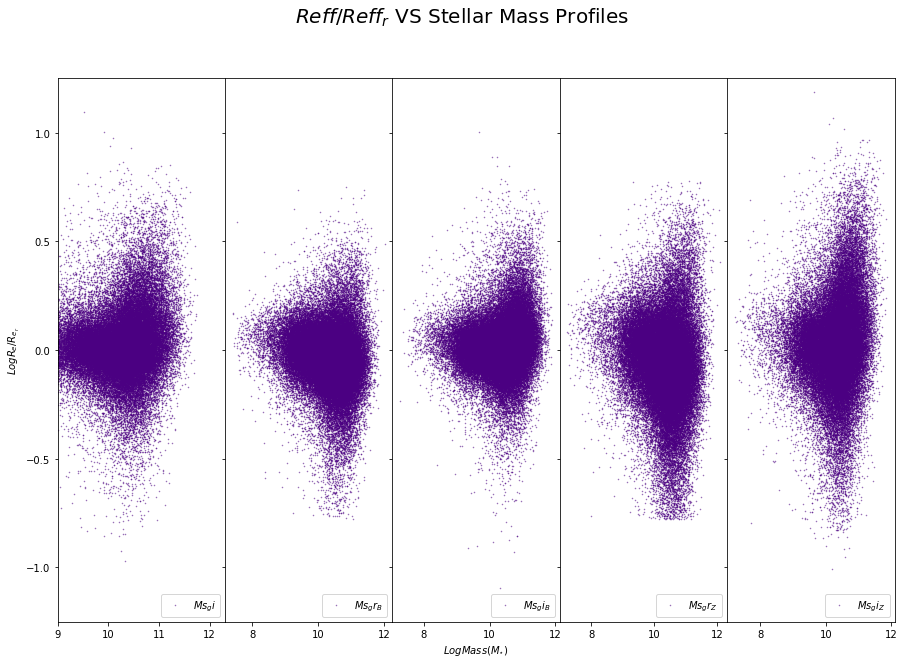

In [42]:

fig, ax = plt.subplots(1, 5, figsize=(15,10), sharey='row', squeeze=False)
# Remove horizontal space between axes
fig.subplots_adjust(wspace=0)
fig.suptitle('$Reff/Reff_r$ VS Stellar Mass Profiles', fontsize=20)


ax[0][2].set_xlabel('$Log Mass (M_{\star})$')
ax[0][0].set_ylabel('$Log R_{e}/R_{e_r}$')
ax[0][0].set_ylim(-1.25, 1.25)


ax[0][0].plot(np.log10(Ms_gi), np.log10(ratio_gi) ,'.', color='indigo' , marker='.', zorder=1, markersize=1, alpha=0.6, label='$Ms_gi$')
ax[0][0].legend(loc='lower right')
ax[0][0].set_xlim(9,12.3)

ax[0][1].plot(np.log10(Ms_gr_B), np.log10(ratio_gr_B) ,'.', color='indigo' , marker='.', markersize=1, alpha=0.6, label='$Ms_gr_B$')
ax[0][1].legend(loc='lower right')
ax[0][0].set_xlim(9,12.3)

ax[0][2].plot(np.log10(Ms_gi_B), np.log10(ratio_gi_B) ,'.', color='indigo' , marker='.', markersize=1, alpha=0.6, label='$Ms_gi_B$')
ax[0][2].legend(loc='lower right')
ax[0][0].set_xlim(9,12.3)

ax[0][3].plot(np.log10(Ms_gr_Z), np.log10(ratio_gr_Z) ,'.', color='indigo' , marker='.', markersize=1, alpha=0.6, label='$Ms_gr_Z$')
ax[0][3].legend(loc='lower right')
ax[0][0].set_xlim(9,12.3)

ax[0][4].plot(np.log10(Ms_gi_Z), np.log10(ratio_gi_Z) ,'.', color='indigo' , marker='.', markersize=1, alpha=0.6, label='$Ms_gi_Z$')
ax[0][4].legend(loc='lower right')
ax[0][0].set_xlim(9,12.3)

label_size = 10
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size



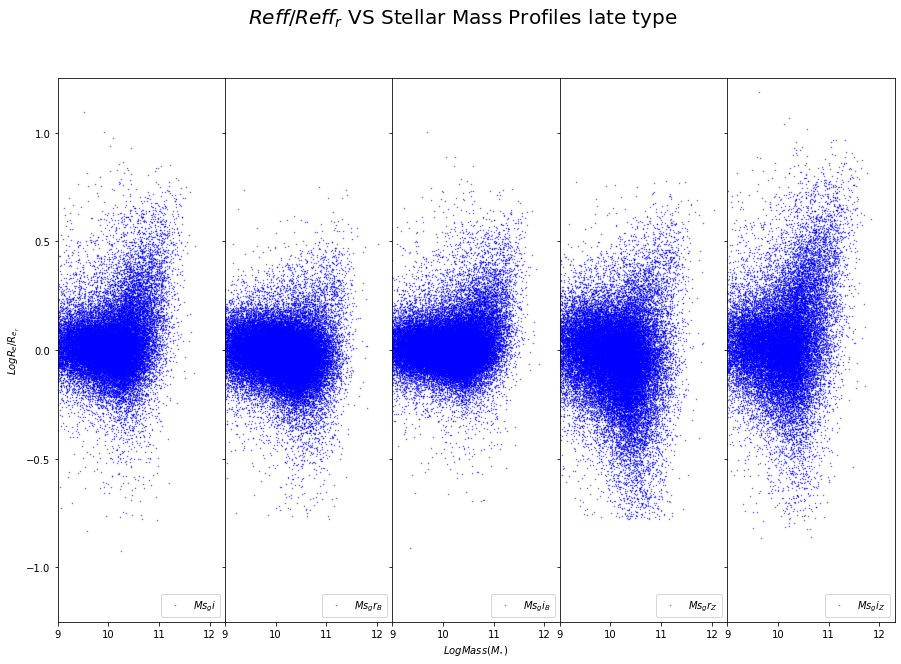

In [43]:


fig, ax = plt.subplots(1, 5, figsize=(15,10), sharey='row', squeeze=False)
# Remove horizontal space between axes
fig.subplots_adjust(wspace=0)
fig.suptitle('$Reff/Reff_r$ VS Stellar Mass Profiles late type', fontsize=20)
# plt.xlabel('Mass', fontsize=10)
# plt.ylabel('Radius', fontsize=10)


ax[0][2].set_xlabel('$Log Mass (M_{\star})$')
ax[0][0].set_ylabel('$Log R_{e}/R_{e_r}$')
ax[0][0].set_ylim(-1.25, 1.25)

ax[0][0].plot(np.log10(Ms_gi_late), np.log10(r_gi_late) ,'.', color='blue' , marker='.', markersize=1, alpha=0.6, label='$Ms_gi$')
ax[0][0].legend(loc='lower right')
ax[0][0].set_xlim(9,12.3)

ax[0][1].plot(np.log10(Ms_gr_B_late), np.log10(r_gr_B_late) ,'.', color='blue' , marker='.', markersize=1, alpha=0.6, label='$Ms_gr_B$')
ax[0][1].legend(loc='lower right')
ax[0][1].set_xlim(9,12.3)

ax[0][2].plot(np.log10(Ms_gi_B_late), np.log10(r_gi_B_late) ,'.', color='blue' , marker='.', markersize=1, alpha=0.6, label='$Ms_gi_B$')
ax[0][2].legend(loc='lower right')
ax[0][2].set_xlim(9,12.3)

ax[0][3].plot(np.log10(Ms_gr_Z_late), np.log10(r_gr_Z_late) ,'.', color='blue' , marker='.', markersize=1, alpha=0.6, label='$Ms_gr_Z$')
ax[0][3].legend(loc='lower right')
ax[0][3].set_xlim(9,12.3)

ax[0][4].plot(np.log10(Ms_gi_Z_late), np.log10(r_gi_Z_late) ,'.', color='blue' , marker='.', markersize=1, alpha=0.6, label='$Ms_gi_Z$')
ax[0][4].legend(loc='lower right')
ax[0][4].set_xlim(9,12.3)

label_size = 10
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

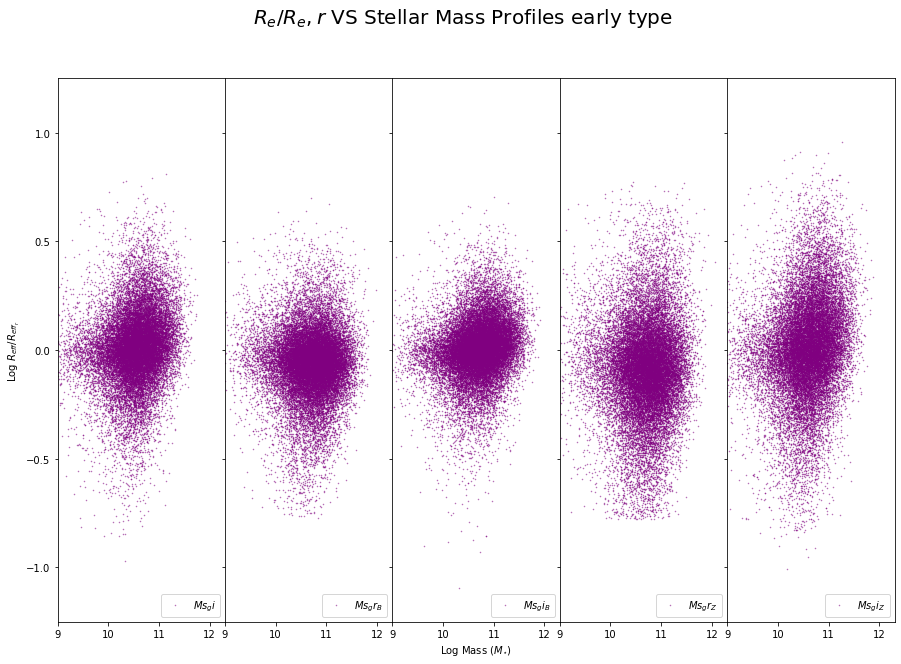

In [44]:
fig, ax = plt.subplots(1, 5, figsize=(15,10), sharey='row', squeeze=False)
# Remove horizontal space between axes
fig.subplots_adjust(wspace=0)
fig.suptitle('$R_e/R_e,r$ VS Stellar Mass Profiles early type', fontsize=20)
# plt.xlabel('Mass', fontsize=10)
# plt.ylabel('Radius', fontsize=10)

ax[0][2].set_xlabel('Log Mass $(M_{\star})$')
ax[0][0].set_ylabel('Log $R_{eff}/R_{eff_r}$')
ax[0][0].set_ylim(-1.25, 1.25)


ax[0][0].plot(np.log10(Ms_gi_early), np.log10(r_gi_early) ,'.', color='purple' , marker='.', markersize=1, alpha=0.6, label='$Ms_gi$')
ax[0][0].legend(loc='lower right')
ax[0][0].set_xlim(9,12.3)

ax[0][1].plot(np.log10(Ms_gr_B_early), np.log10(r_gr_B_early) ,'.', color='purple' , marker='.', markersize=1, alpha=0.6, label='$Ms_gr_B$')
ax[0][1].legend(loc='lower right')
ax[0][1].set_xlim(9,12.3)

ax[0][2].plot(np.log10(Ms_gi_B_early), np.log10(r_gi_B_early) ,'.', color='purple' , marker='.', markersize=1, alpha=0.6, label='$Ms_gi_B$')
ax[0][2].legend(loc='lower right')
ax[0][2].set_xlim(9,12.3)

ax[0][3].plot(np.log10(Ms_gr_Z_early), np.log10(r_gr_Z_early) ,'.', color='purple' , marker='.', markersize=1, alpha=0.6, label='$Ms_gr_Z$')
ax[0][3].legend(loc='lower right')
ax[0][3].set_xlim(9,12.3)

ax[0][4].plot(np.log10(Ms_gi_Z_early), np.log10(r_gi_Z_early) ,'.', color='purple' , marker='.', markersize=1, alpha=0.6, label='$Ms_gi_Z$')
ax[0][4].legend(loc='lower right')
ax[0][4].set_xlim(9,12.3)

label_size = 10
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

(9.0, 12.3)

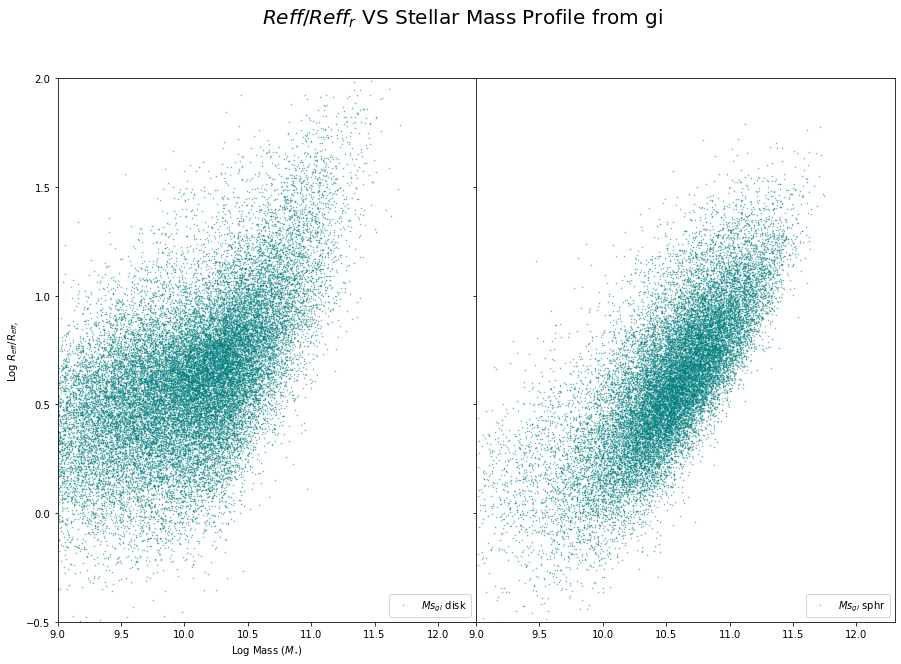

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(15,10), sharey='row', squeeze=False)
# Remove horizontal space between axes
fig.subplots_adjust(wspace=0)
fig.suptitle('$Reff/Reff_r$ VS Stellar Mass Profile from gi', fontsize=20)
# plt.xlabel('Mass', fontsize=10)
# plt.ylabel('Radius', fontsize=10)

ax[0][0].set_xlabel('Log Mass $(M_{\star})$')
ax[0][0].set_ylabel('Log $R_{eff}/R_{eff_r}$')
ax[0][0].set_ylim(-0.5, 2)


ax[0][0].plot(np.log10(Ms_gi_late), np.log10(re_gi_late) ,'.', color='teal' , marker='.', markersize=1, alpha=0.6, label='$Ms_{gi}$ disk')
ax[0][0].legend(loc='lower right')
ax[0][0].set_xlim(9,12.3)

ax[0][1].plot(np.log10(Ms_gi_early), np.log10(re_gi_early) ,'.', color='teal' , marker='.', markersize=1, alpha=0.6, label='$Ms_{gi}$ sphr')
ax[0][1].legend(loc='lower right')
ax[0][1].set_xlim(9,12.3)


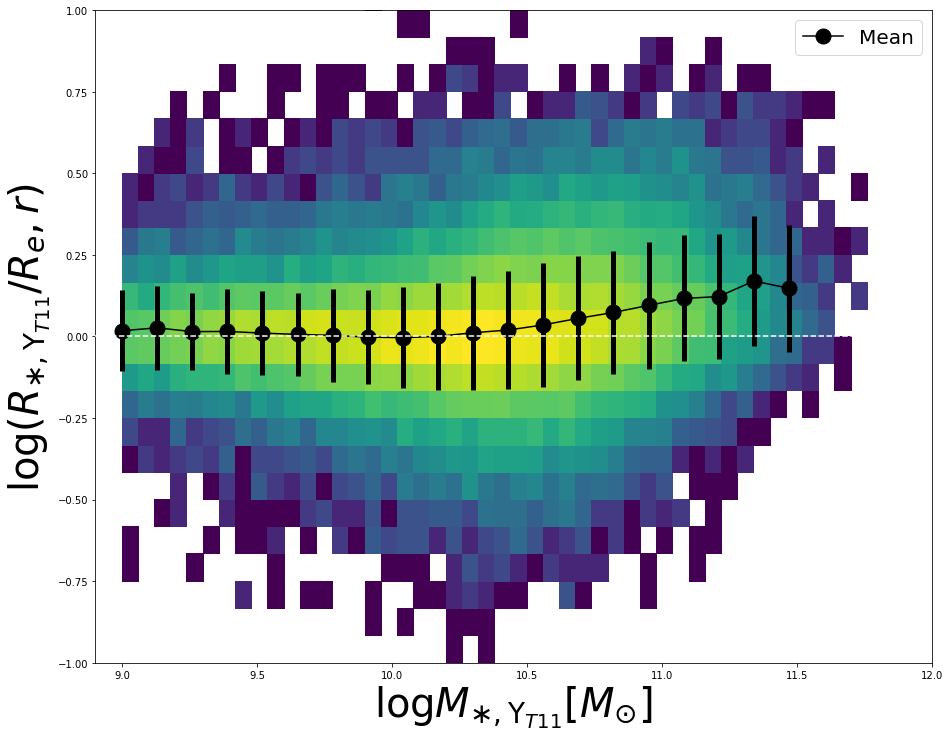

In [46]:
fig, ax= plt.subplots(figsize=(15,12))


# Re/Rer VS Ms_gi 
plt.hist2d(np.log10(Ms_gi), np.log10(ratio_gi), bins=(50,30), range=[[9, 12], [-1.25, 1.25]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(gi_means_bins[:-1], stat_gi_mean, zorder=2, color ='black', marker = 'o', markersize= 15,  label='Mean')
plt.errorbar(gi_means_bins[:-1], stat_gi_mean, yerr=stat_gi_std, xerr=None, ls='None', ecolor='black', elinewidth=5)
x = [8.9,12]
y = [0,0]
plt.plot(x, y, zorder = 3, color='white', linestyle='--')
# Add axis labels

plt.xlabel(r'$\log M_{\ast, \Upsilon_{T11}} [M_{\odot}]$', fontsize=40)
plt.ylabel(r'$\log  (R_{\ast, \Upsilon_{T11}}/R_e,r)$', fontsize=40)

#set axis limits
plt.ylim(-1, 1)
plt.xlim(8.9,12)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/ratio_Msgi.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

 



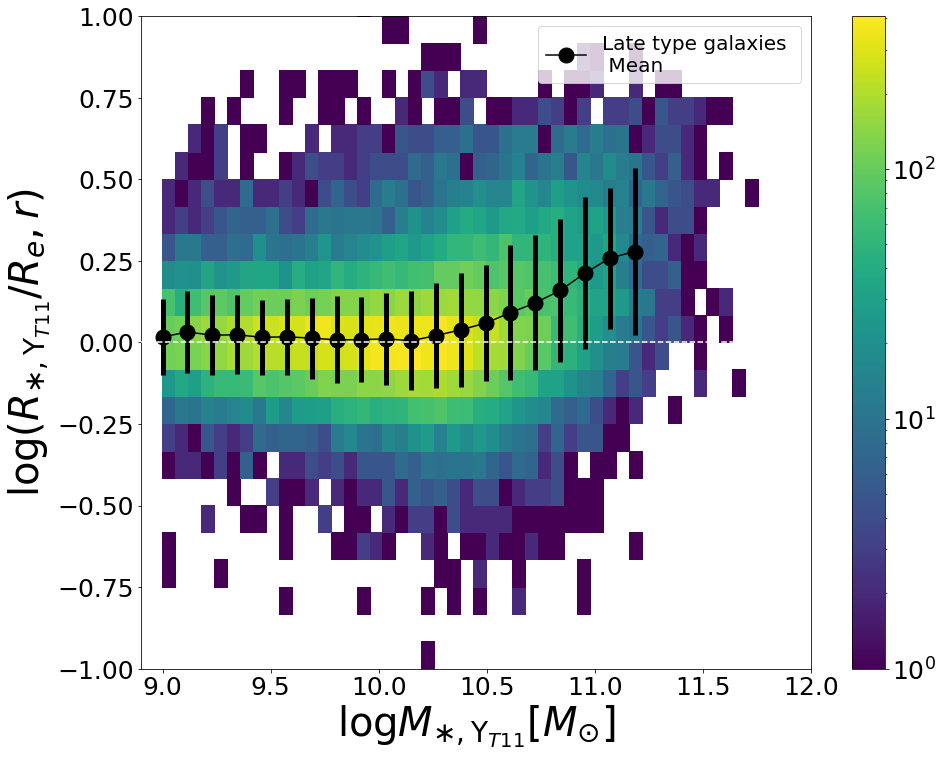

In [47]:
fig, ax= plt.subplots(figsize=(15,12))

# Re/Rer VS Ms_gi late
plt.hist2d(np.log10(Ms_gi_late),np.log10(r_gi_late), bins=(50,30), range=[[9, 12], [-1.25, 1.25]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(gilate_means_bins[:-1], stat_gi_late_mean, zorder=2, color ='black', marker = 'o', markersize= 15,  label='Late type galaxies \n Mean')
plt.errorbar(gilate_means_bins[:-1], stat_gi_late_mean, yerr=stat_gi_std_late, xerr=None, ls='None', ecolor='black', elinewidth=5)
x = [8.9,12]
y = [0,0]
plt.plot(x, y, zorder = 3, color='white', linestyle='--')
plt.colorbar() 

# Add axis labels

plt.xlabel(r'$\log M_{\ast, \Upsilon_{T11}} [M_{\odot}]$', fontsize=40)
plt.ylabel(r'$\log (R_{\ast, \Upsilon_{T11}}/R_e,r)$', fontsize=40)

#set axis limits
plt.ylim(-1, 1)
plt.xlim(8.9,12)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size


plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/ratio_Msgilate.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()


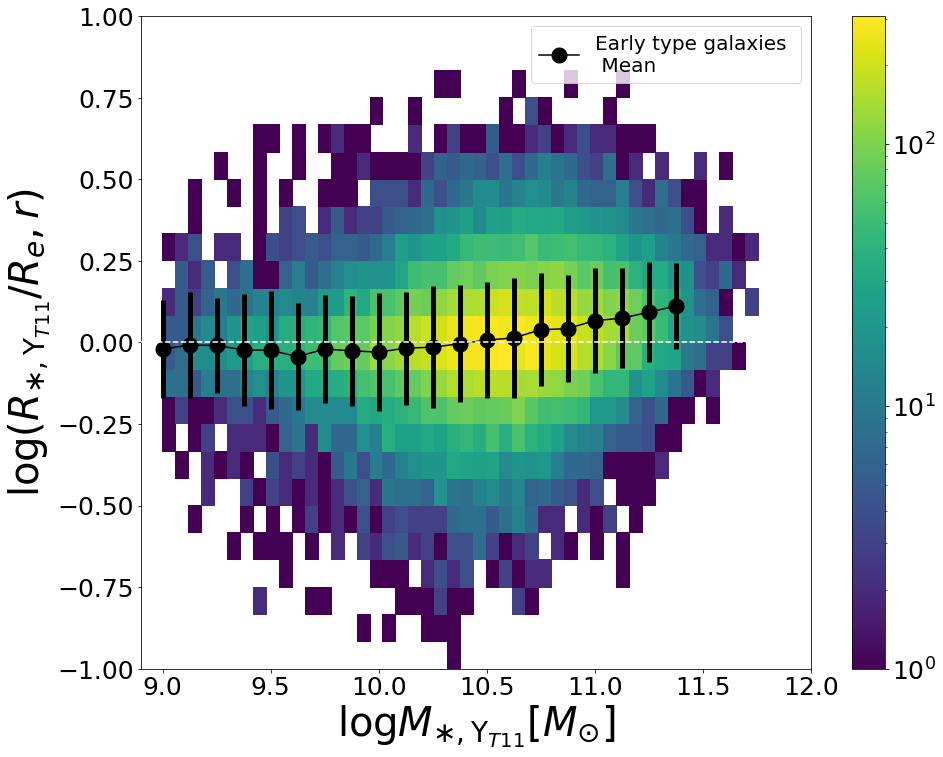

In [48]:
fig, ax= plt.subplots(figsize=(15,12))

# Re/Rer VS Ms_gi early
plt.hist2d(np.log10(Ms_gi_early), np.log10(r_gi_early), bins=(50,30), range=[[9,12], [-1.25,1.25]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(giearly_means_bins[:-1], stat_gi_early_mean, zorder=2, color ='black', marker = 'o', markersize= 15,  label='Early type galaxies \n Mean')
plt.errorbar(giearly_means_bins[:-1], stat_gi_early_mean, yerr=stat_gi_std_early, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.colorbar() 
x = [8.9,12]
y = [0,0]
plt.plot(x, y, zorder = 3, color='white', linestyle='--')

# Add axis labels

plt.xlabel(r'$\log M_{\ast, \Upsilon_{T11}} [M_{\odot}]$', fontsize=40)
plt.ylabel(r'$\log (R_{\ast, \Upsilon_{T11}}/R_e,r)$', fontsize=40)

#set axis limits
plt.ylim(-1, 1)
plt.xlim(8.9,12)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/ratio_Msgiearly.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()


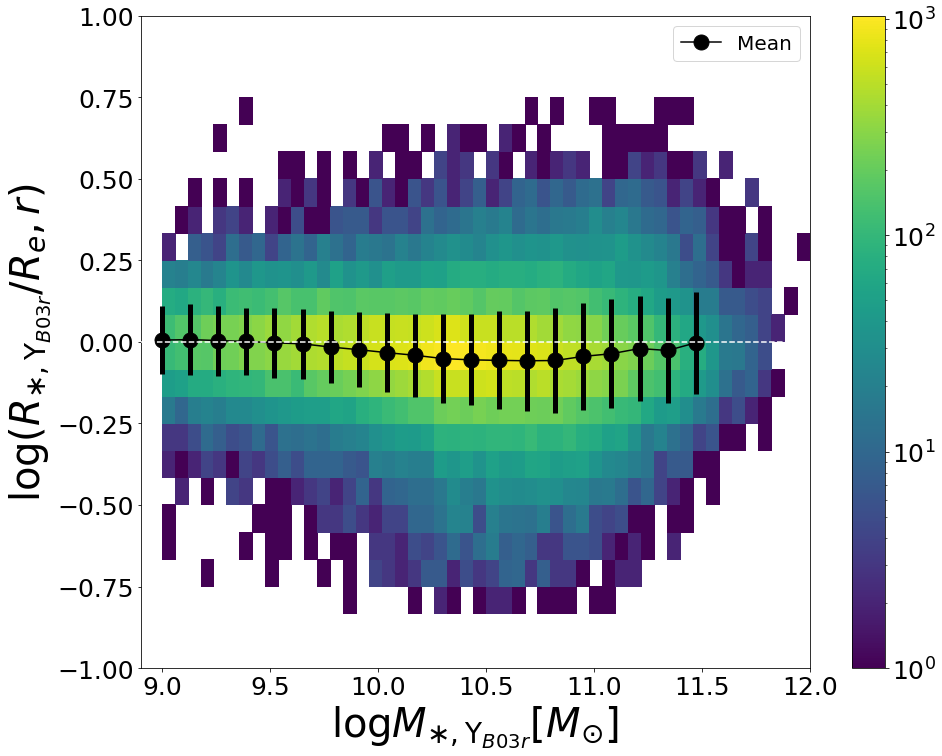

In [49]:
fig, ax= plt.subplots(figsize=(15,12))

# Re/Rer VS Ms_grB

plt.hist2d(np.log10(Ms_gr_B), np.log10(ratio_gr_B), bins=(50,30), range=[[9,12],[-1.25,1.25]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(gr_B_means_bins[:-1], stat_gr_B_mean, zorder=2, color ='black', marker = 'o', markersize= 15,  label='Mean')
plt.errorbar(gr_B_means_bins[:-1], stat_gr_B_mean, yerr=stat_gr_B_std, xerr=None, ls='None', ecolor='black', elinewidth=5)
x = [8.9,12]
y = [0,0]
plt.plot(x, y, zorder = 3, color='white', linestyle='--')
plt.colorbar() 

# Add axis labels

plt.xlabel(r'$\log M_{\ast, \Upsilon_{B03r}} [M_{\odot}]$', fontsize=40)
plt.ylabel(r'$\log (R_{\ast, \Upsilon_{B03r}}/R_e,r)$', fontsize=40)

#set axis limits
plt.ylim(-1, 1)
plt.xlim(8.9,12)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/ratio_MsgrB.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

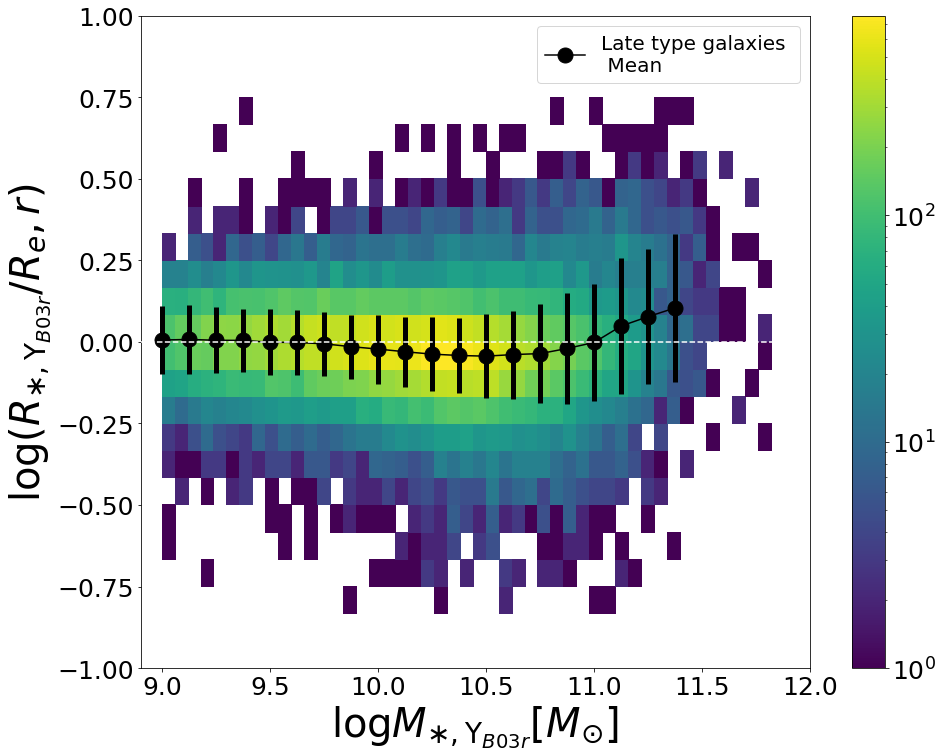

In [50]:
fig, ax= plt.subplots(figsize=(15,12))

# Re/Rer VS Ms_grB late
plt.hist2d(np.log10(Ms_gr_B_late), np.log10(r_gr_B_late), bins=(50,30), range=[[9,12],[-1.25,1.25]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(grBlate_means_bins[:-1], stat_gr_B_late_mean, zorder=2, color ='black', marker = 'o', markersize= 15,  label='Late type galaxies \n Mean')
plt.errorbar(grBlate_means_bins[:-1], stat_gr_B_late_mean, yerr=stat_gr_B_std_late, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.colorbar() 
x = [8.9,12]
y = [0,0]
plt.plot(x, y, zorder = 3, color='white', linestyle='--')


# Add axis labels

plt.xlabel(r'$\log M_{\ast, \Upsilon_{B03r}} [M_{\odot}]$', fontsize=40)
plt.ylabel(r'$\log (R_{\ast, \Upsilon_{B03r}}/R_e,r)$', fontsize=40)

#set axis limits
plt.ylim(-1, 1)
plt.xlim(8.9,12)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/ratio_MsgrBlate.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

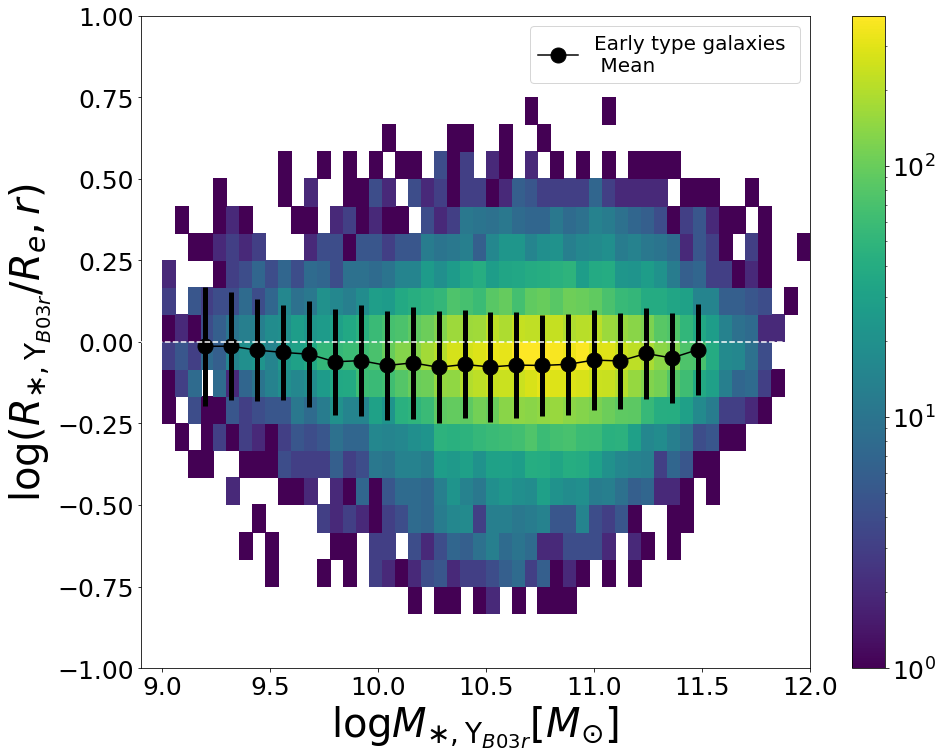

In [51]:
fig, ax= plt.subplots(figsize=(15,12))

# Re/Rer VS Ms_grB early
plt.hist2d(np.log10(Ms_gr_B_early), np.log10(r_gr_B_early), bins=(50,30), range=[[9,12],[-1.25,1.25]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(grBearly_means_bins[:-1], stat_gr_B_early_mean, zorder=2, color ='black', marker = 'o', markersize= 15,  label='Early type galaxies \n Mean')
plt.errorbar(grBearly_means_bins[:-1], stat_gr_B_early_mean, yerr=stat_gr_B_std_early, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.colorbar() 
x = [8.9,12]
y = [0,0]
plt.plot(x, y, zorder = 3, color='white', linestyle='--')
# Add axis labels

plt.xlabel(r'$\log M_{\ast, \Upsilon_{B03r}} [M_{\odot}]$', fontsize=40)
plt.ylabel(r'$\log (R_{\ast, \Upsilon_{B03r}}/R_e,r)$', fontsize=40)


#set axis limits
plt.ylim(-1, 1)
plt.xlim(8.9,12)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/ratio_MsgrBearly.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()


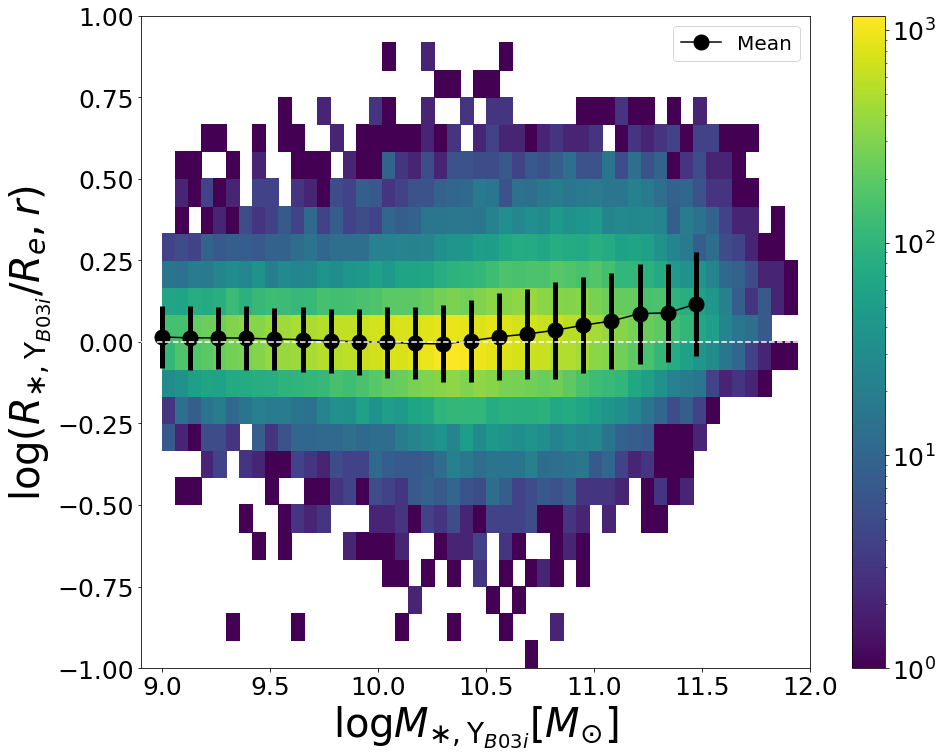

In [52]:
fig, ax= plt.subplots(figsize=(15,12))


# Re/Rer VS Ms_giB
plt.hist2d(np.log10(Ms_gi_B), np.log10(ratio_gi_B), bins=(50,30), range=[[9,12],[-1.25,1.25]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(gi_B_means_bins[:-1], stat_gi_B_mean, zorder=2, color ='black', marker = 'o', markersize= 15,  label='Mean')
plt.errorbar(gi_B_means_bins[:-1], stat_gi_B_mean, yerr=stat_gi_B_std, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.colorbar() 
x = [8.9,12]
y = [0,0]
plt.plot(x, y, zorder = 3, color='white', linestyle='--')
# Add axis labels

plt.xlabel(r'$\log M_{\ast, \Upsilon_{B03i}} [M_{\odot}]$', fontsize=40)
plt.ylabel(r'$\log (R_{\ast, \Upsilon_{B03i}}/R_e,r)$', fontsize=40)

#set axis limits
plt.ylim(-1, 1)
plt.xlim(8.9,12)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/ratio_MsgiB.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

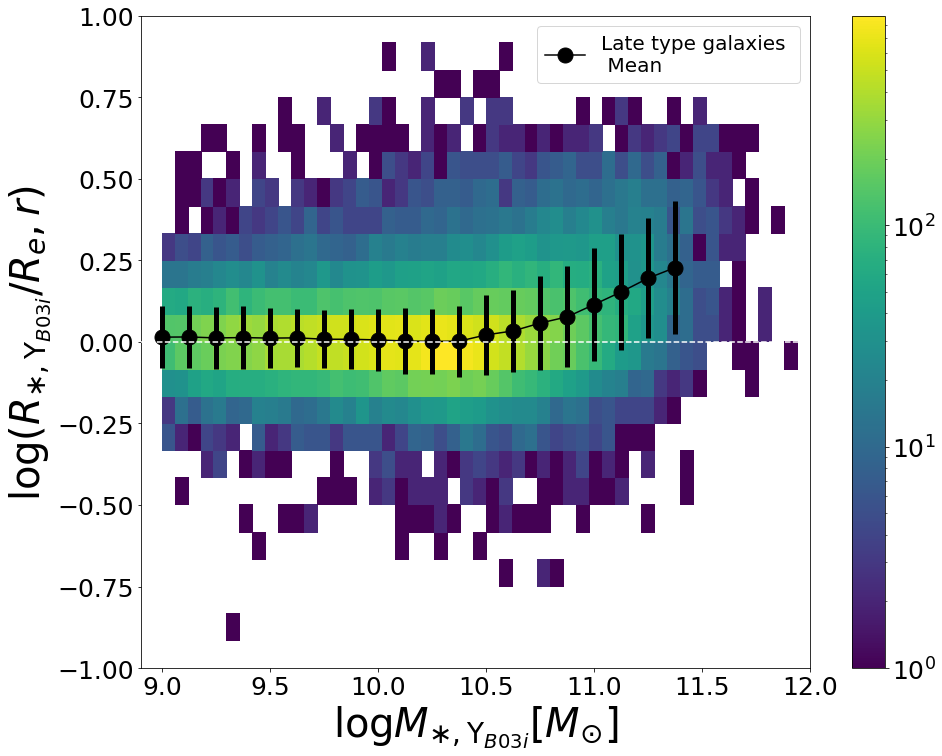

In [53]:
fig, ax= plt.subplots(figsize=(15,12))

# Re/Rer VS Ms_giB late
plt.hist2d(np.log10(Ms_gi_B_late), np.log10(r_gi_B_late), bins=(50,30), range=[[9,12],[-1.25,1.25]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(giBlate_means_bins[:-1], stat_gi_B_late_mean, zorder=2, color ='black', marker = 'o', markersize= 15,  label='Late type galaxies \n Mean')
plt.errorbar(giBlate_means_bins[:-1], stat_gi_B_late_mean, yerr=stat_gi_B_std_late, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.colorbar() 
x = [8.9,12]
y = [0,0]
plt.plot(x, y, zorder = 3, color='white', linestyle='--')

# Add axis labels

plt.xlabel(r'$\log M_{\ast, \Upsilon_{B03i}} [M_{\odot}]$', fontsize=40)
plt.ylabel(r'$\log (R_{\ast, \Upsilon_{B03i}}/R_e,r)$', fontsize=40)

#set axis limits
plt.ylim(-1, 1)
plt.xlim(8.9,12)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/ratio_MsgiBlate.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()


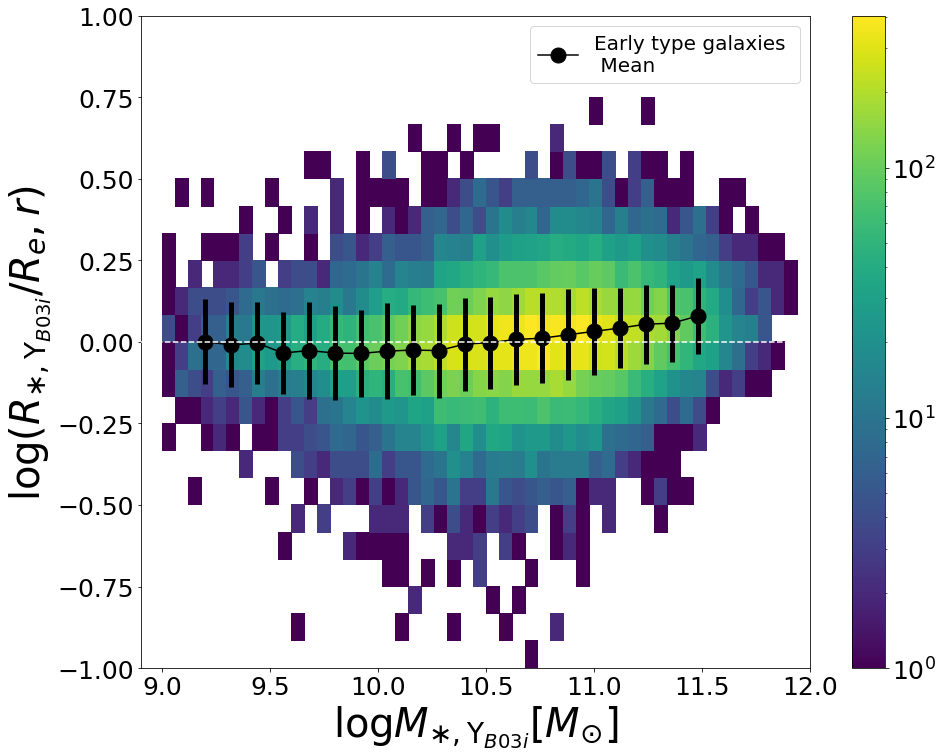

In [54]:
fig, ax= plt.subplots(figsize=(15,12))

# Re/Rer VS Ms_giB early
plt.hist2d(np.log10(Ms_gi_B_early), np.log10(r_gi_B_early), bins=(50,30), range=[[9,12], [-1.25,1.25]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(giBearly_means_bins[:-1], stat_gi_B_early_mean, zorder=2, color ='black', marker = 'o', markersize= 15,  label='Early type galaxies \n Mean')
plt.errorbar(giBearly_means_bins[:-1], stat_gi_B_early_mean, yerr=stat_gi_B_std_early, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.colorbar() 
x = [8.9,12]
y = [0,0]
plt.plot(x, y, zorder = 3, color='white', linestyle='--')

# Add axis labels

plt.xlabel(r'$\log M_{\ast, \Upsilon_{B03i}} [M_{\odot}]$', fontsize=40)
plt.ylabel(r'$\log (R_{\ast, \Upsilon_{B03i}}/R_e,r)$', fontsize=40)

#set axis limits
plt.ylim(-1, 1)
plt.xlim(8.9,12)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/ratio_MsgiBearly.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

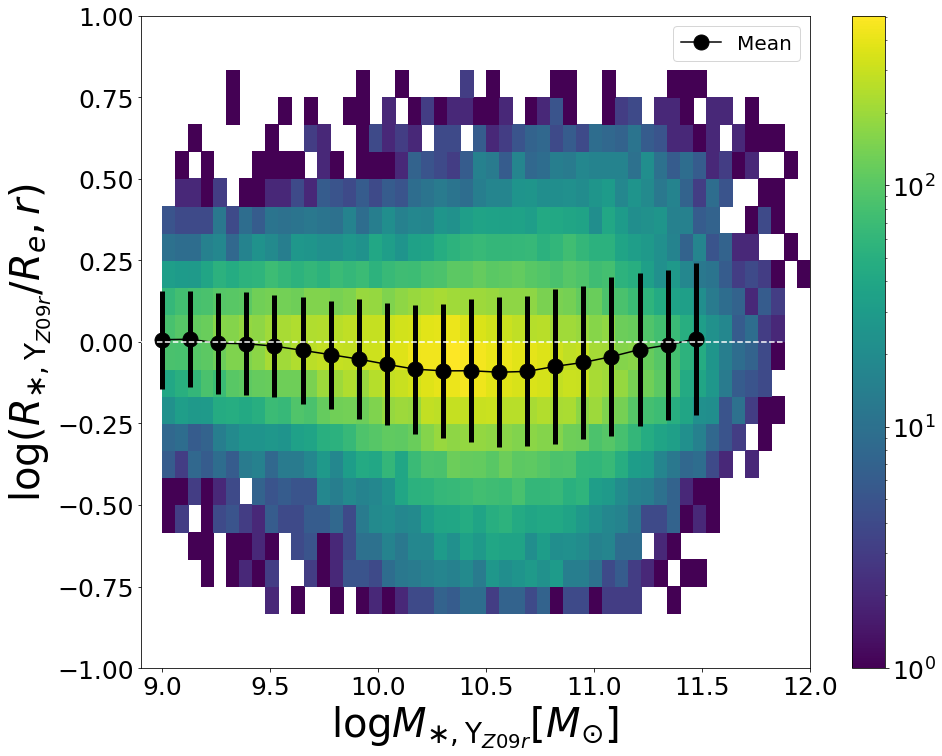

In [55]:
fig, ax= plt.subplots(figsize=(15,12))

# Re/Rer VS Ms_grZ
plt.hist2d(np.log10(Ms_gr_Z), np.log10(ratio_gr_Z), bins=(50,30), range=[[9,12],[-1.25,1.25]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(gr_Z_means_bins[:-1], stat_gr_Z_mean, zorder=2, color ='black', marker = 'o', markersize= 15,  label='Mean')
plt.errorbar(gr_Z_means_bins[:-1], stat_gr_Z_mean, yerr=stat_gr_Z_std, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.colorbar() 
x = [8.9,12]
y = [0,0]
plt.plot(x, y, zorder = 3, color='white', linestyle='--')

# Add axis labels

plt.xlabel(r'$\log M_{\ast, \Upsilon_{Z09r}} [M_{\odot}]$', fontsize=40)
plt.ylabel(r'$\log (R_{\ast, \Upsilon_{Z09r}}/R_e,r)$', fontsize=40)

#set axis limits
plt.ylim(-1, 1)
plt.xlim(8.9,12)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/ratio_MsgrZ.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

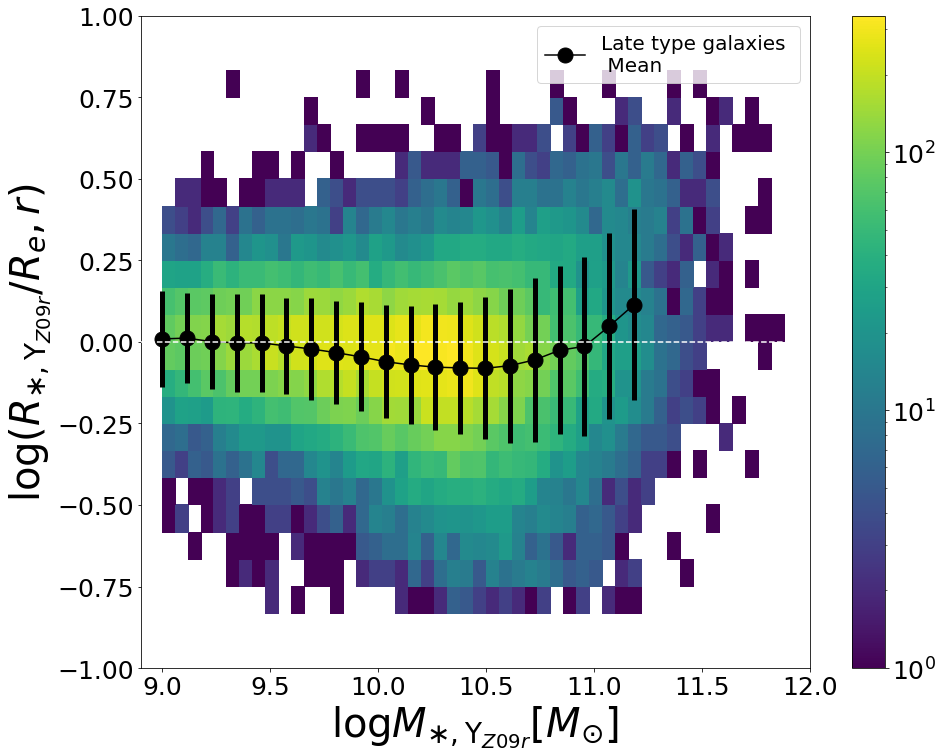

In [54]:
fig, ax= plt.subplots(figsize=(15,12))

# Re/Rer VS Ms_grZ late
plt.hist2d(np.log10(Ms_gr_Z_late), np.log10(r_gr_Z_late), bins=(50,30), range=[[9,12],[-1.25,1.25]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(grZlate_means_bins[:-1], stat_gr_Z_late_mean, zorder=2, color ='black', marker = 'o', markersize= 15,  label='Late type galaxies \n Mean')
plt.errorbar(grZlate_means_bins[:-1], stat_gr_Z_late_mean, yerr=stat_gr_Z_std_late, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.colorbar() 
x = [8.9,12]
y = [0,0]
plt.plot(x, y, zorder = 3, color='white', linestyle='--')

# Add axis labels

plt.xlabel(r'$\log M_{\ast, \Upsilon_{Z09r}} [M_{\odot}]$', fontsize=40)
plt.ylabel(r'$\log (R_{\ast, \Upsilon_{Z09r}}/R_e,r)$', fontsize=40)

#set axis limits
plt.ylim(-1, 1)
plt.xlim(8.9,12)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/ratio_MsgrZlate.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

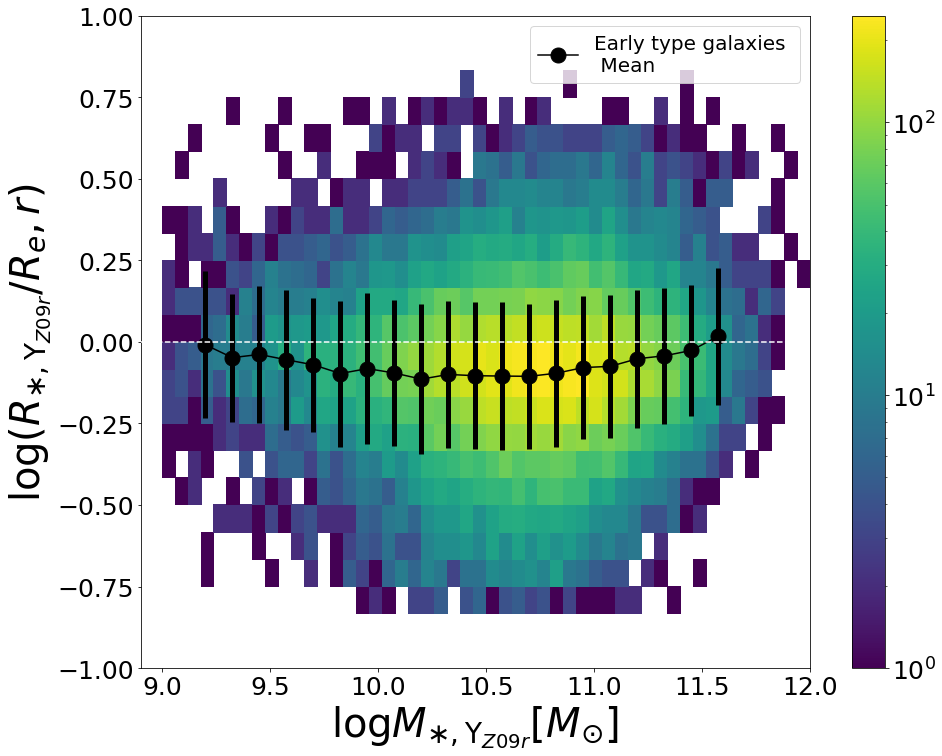

In [55]:
fig, ax= plt.subplots(figsize=(15,12))

# Re/Rer VS Ms_grZ early
plt.hist2d(np.log10(Ms_gr_Z_early), np.log10(r_gr_Z_early), bins=(50,30), range=[[9,12],[-1.25,1.25]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(grZearly_means_bins[:-1], stat_gr_Z_early_mean, zorder=2, color ='black', marker = 'o', markersize= 15,  label='Early type galaxies \n Mean')
plt.errorbar(grZearly_means_bins[:-1], stat_gr_Z_early_mean, yerr=stat_gr_Z_std_early, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.colorbar() 
x = [8.9,12]
y = [0,0]
plt.plot(x, y, zorder = 3, color='white', linestyle='--')

# Add axis labels

plt.xlabel(r'$\log M_{\ast, \Upsilon_{Z09r}} [M_{\odot}]$', fontsize=40)
plt.ylabel(r'$\log (R_{\ast, \Upsilon_{Z09r}}/R_e,r)$', fontsize=40)

#set axis limits
plt.ylim(-1, 1)
plt.xlim(8.9,12)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/ratio_MsgrZearly.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

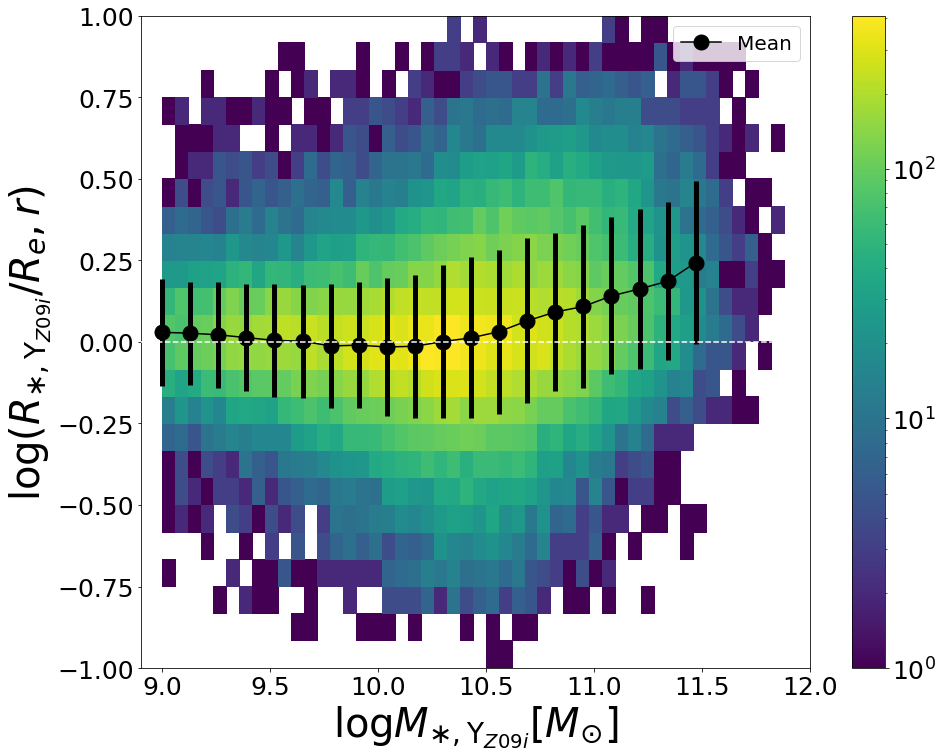

In [106]:
fig, ax= plt.subplots(figsize=(15,12))

# Re/Rer VS Ms_giZ 
plt.hist2d(np.log10(Ms_gi_Z), np.log10(ratio_gi_Z), bins=(50, 30), range=[[9,12],[-1.25,1.25]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(gi_Z_means_bins[:-1], stat_gi_Z_mean, zorder=2, color ='black', marker = 'o', markersize= 15,  label='Mean')
plt.errorbar(gi_Z_means_bins[:-1], stat_gi_Z_mean, yerr=stat_gi_Z_std, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.colorbar() 
x = [8.9,12]
y = [0,0]
plt.plot(x, y, zorder = 3, color='white', linestyle='--')

# Add axis labels

plt.xlabel(r'$\log M_{\ast, \Upsilon_{Z09i}} [M_{\odot}]$', fontsize=40)
plt.ylabel(r'$\log (R_{\ast, \Upsilon_{Z09i}}/R_e,r)$', fontsize=40)

#set axis limits
plt.ylim(-1, 1)
plt.xlim(8.9,12)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/ratio_MsgiZ.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

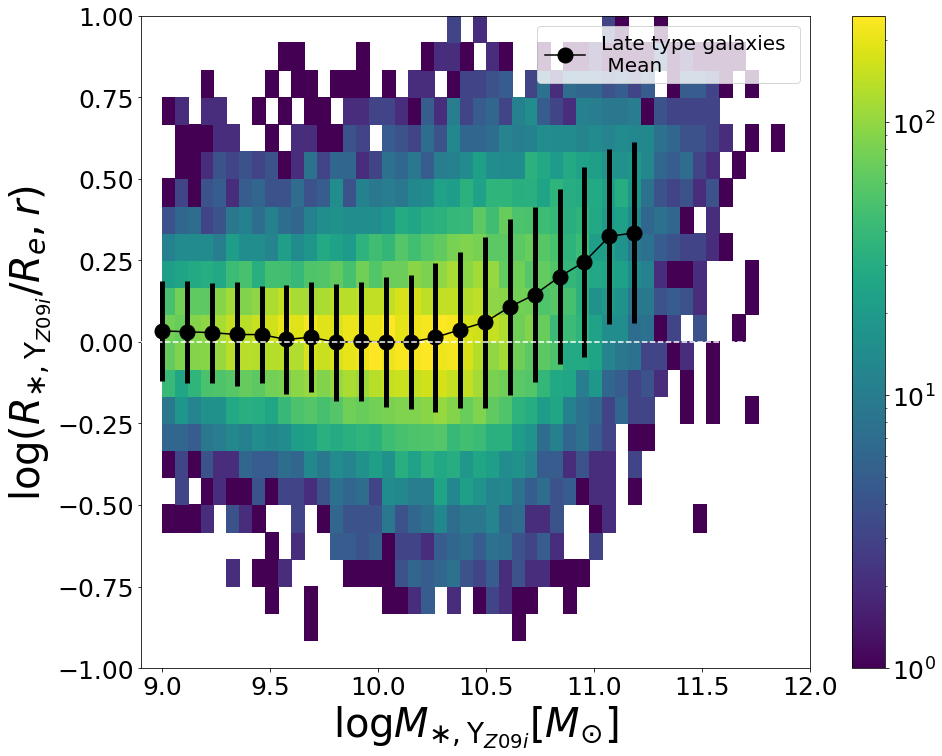

In [57]:
fig, ax= plt.subplots(figsize=(15,12))

# Re/Rer VS Ms_giZ late
plt.hist2d(np.log10(Ms_gi_Z_late), np.log10(r_gi_Z_late), bins=(50,30), range=[[9,12],[-1.25,1.25]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(giZlate_means_bins[:-1], stat_gi_Z_late_mean, zorder=2, color ='black', marker = 'o', markersize= 15,  label='Late type galaxies \n Mean')
plt.errorbar(giZlate_means_bins[:-1], stat_gi_Z_late_mean, yerr=stat_gi_Z_std_late, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.colorbar() 
x = [8.9,12]
y = [0,0]
plt.plot(x, y, zorder = 3, color='white', linestyle='--')
# Add axis labels

plt.xlabel(r'$\log M_{\ast, \Upsilon_{Z09i}} [M_{\odot}]$', fontsize=40)
plt.ylabel(r'$\log (R_{\ast, \Upsilon_{Z09i}}/R_e,r)$', fontsize=40)

#set axis limits
plt.ylim(-1, 1)
plt.xlim(8.9,12)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/ratio_MsgiZlate.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

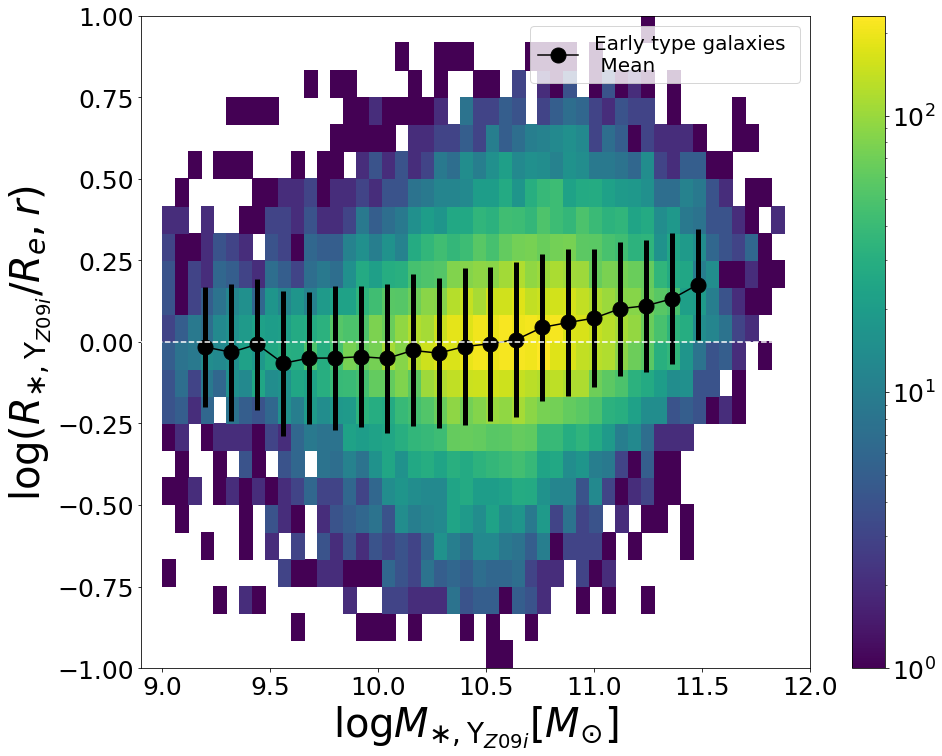

In [58]:
fig, ax= plt.subplots(figsize=(15,12))

# Re/Rer VS Ms_grZ early
plt.hist2d(np.log10(Ms_gi_Z_early), np.log10(r_gi_Z_early), bins=(50,30), range=[[9,12], [-1.25,1.25]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(giZearly_means_bins[:-1], stat_gi_Z_early_mean, zorder=2, color ='black', marker = 'o', markersize= 15,  label='Early type galaxies \n Mean')
plt.errorbar(giZearly_means_bins[:-1], stat_gi_Z_early_mean, yerr=stat_gi_Z_std_early, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.colorbar() 
x = [8.9,12]
y = [0,0]
plt.plot(x, y, zorder = 3, color='white', linestyle='--')

# Add axis labels

plt.xlabel(r'$\log M_{\ast, \Upsilon_{Z09i}} [M_{\odot}]$', fontsize=40)
plt.ylabel(r'$\log (R_{\ast, \Upsilon_{Z09i}}/R_e,r)$', fontsize=40)

#set axis limits
plt.ylim(-1, 1)
plt.xlim(8.9,12)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/ratio_MsgiZearly.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

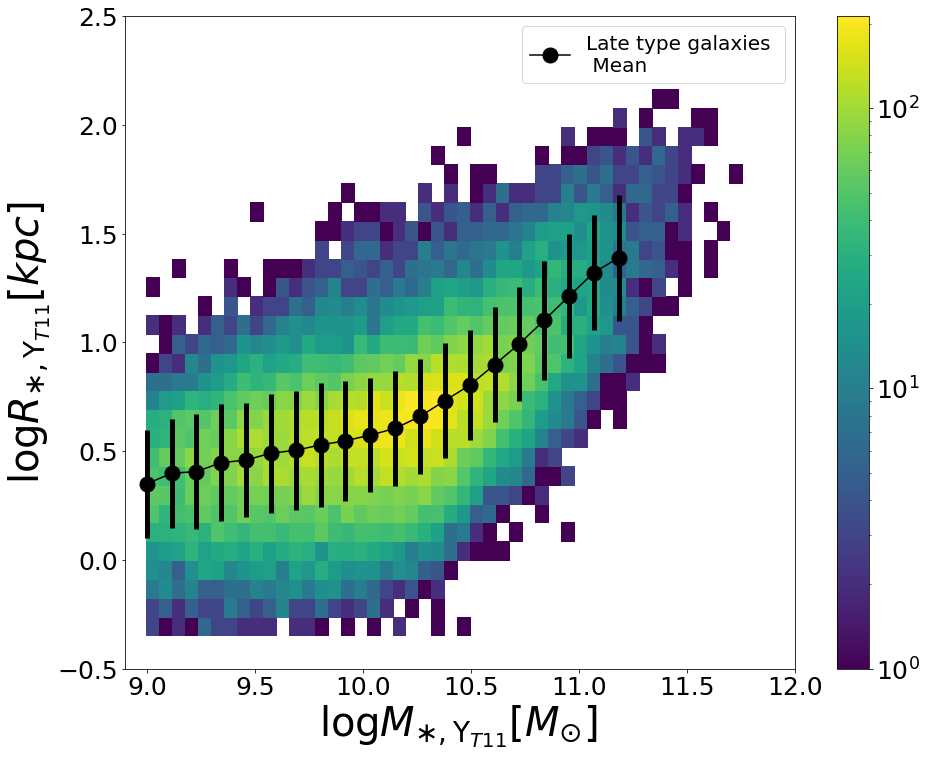

In [59]:
fig, ax= plt.subplots(figsize=(15,12))

# Re_gi VS Ms_gi late Taylor
plt.hist2d(np.log10(Ms_gi_late), np.log10(re_gi_late), bins=(50,30), range=[[9,12],[-.35,2.25]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(gilateT_mean_bins[:-1], stat_gilateT_mean, zorder=2, color ='black', marker = 'o', markersize= 15,  label='Late type galaxies \n Mean')
plt.errorbar(gilateT_mean_bins[:-1], stat_gilateT_mean, yerr=stat_gilateT_std, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.colorbar() 


# Add axis labels

plt.xlabel(r'$\log M_{\ast, \Upsilon_{T11}} [M_{\odot}]$ ', fontsize=40)
plt.ylabel(r'$\log R_{\ast, \Upsilon_{T11}}[kpc]$', fontsize=40)

#set axis limits
plt.ylim(-0.5, 2.5)
plt.xlim(8.9,12)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/reff_MsgilateT.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()


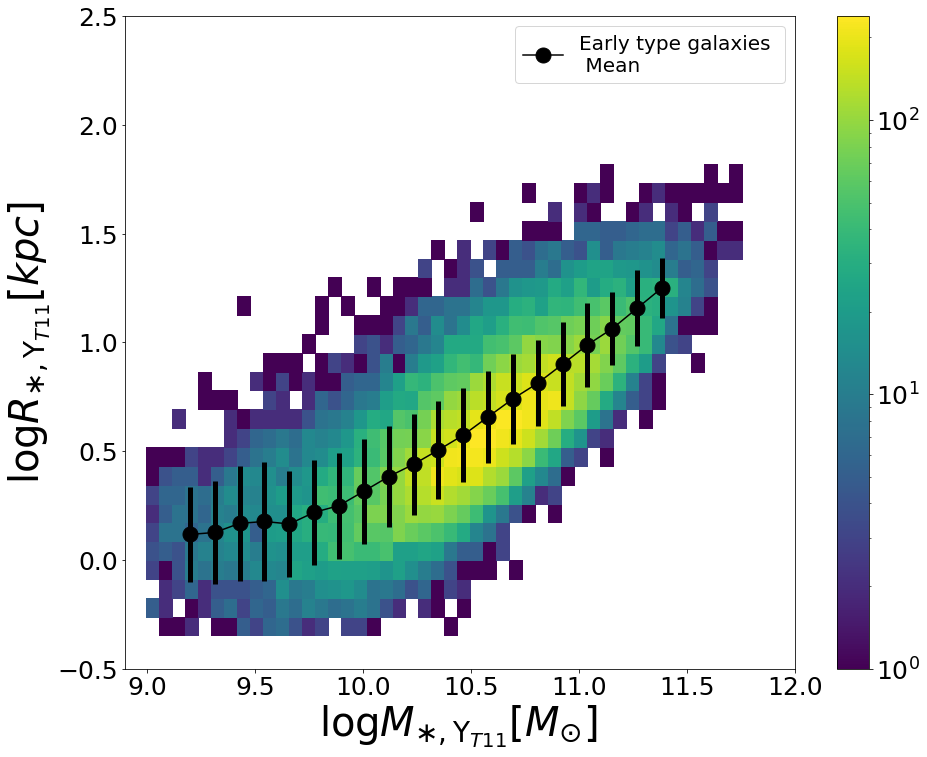

In [60]:
fig, ax= plt.subplots(figsize=(15,12))

# Re_gi VS Ms_gi early Taylor
plt.hist2d(np.log10(Ms_gi_early), np.log10(re_gi_early), bins=(50,30), range=[[9,12],[-.35,2.25]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(giearlyT_mean_bins[:-1], stat_giearlyT_mean, zorder=2, color ='black', marker = 'o', markersize= 15,  label='Early type galaxies \n Mean')
plt.errorbar(giearlyT_mean_bins[:-1], stat_giearlyT_mean, yerr=stat_giearlyT_std, xerr=None, ls='None', ecolor='black', elinewidth=5)

plt.colorbar() 

# Add axis labels

plt.xlabel(r'$\log M_{\ast, \Upsilon_{T11}} [M_{\odot}]$ ', fontsize=40)
plt.ylabel(r'$\log R_{\ast, \Upsilon_{T11}}[kpc]$', fontsize=40)

#set axis limits
plt.ylim(-0.5, 2.5)
plt.xlim(8.9,12)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/reff_MsgiearlyT.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

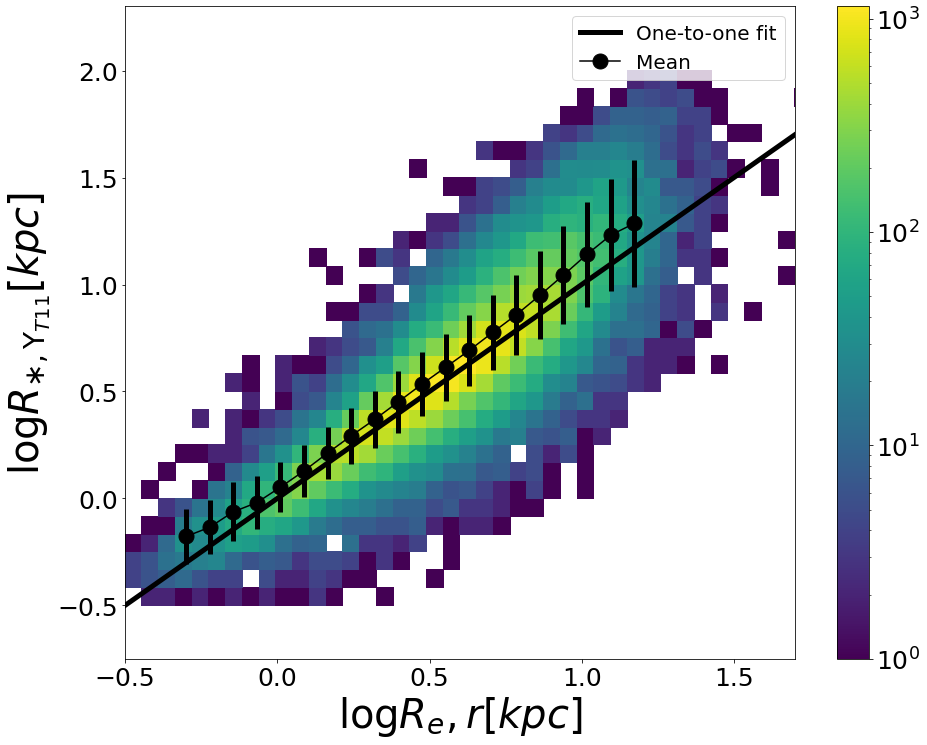

In [61]:
fig, ax= plt.subplots(figsize=(15,12))
    
x = np.linspace(-0.5,2.5)

# Re_r VS Re_gi
plt.hist2d(np.log10(Re_r_gi), np.log10(Re_ste_gi), bins=(50,30), range=[[-0.5,2.25], [-0.5, 2]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(x, x + 0, linestyle='solid', linewidth=5, zorder=2, color ='black',  label='One-to-one fit')
plt.plot(gi_rer_means_bins[:-1], stat_gi_rer_mean, zorder=2, color ='black', marker = 'o', markersize= 15,  label='Mean')
plt.errorbar(gi_rer_means_bins[:-1], stat_gi_rer_mean, yerr=stat_gi_rer_std, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.colorbar()  

# Add axis labels

plt.xlabel( r'$\log R_e,r [kpc]$', fontsize=40)
plt.ylabel(r'$\log R_{\ast, \Upsilon_{T11}}[kpc]$', fontsize=40)

#set axis limits
plt.xlim(-0.5, 1.7)
plt.ylim(-0.75,2.3)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/reffr_Reffgi.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

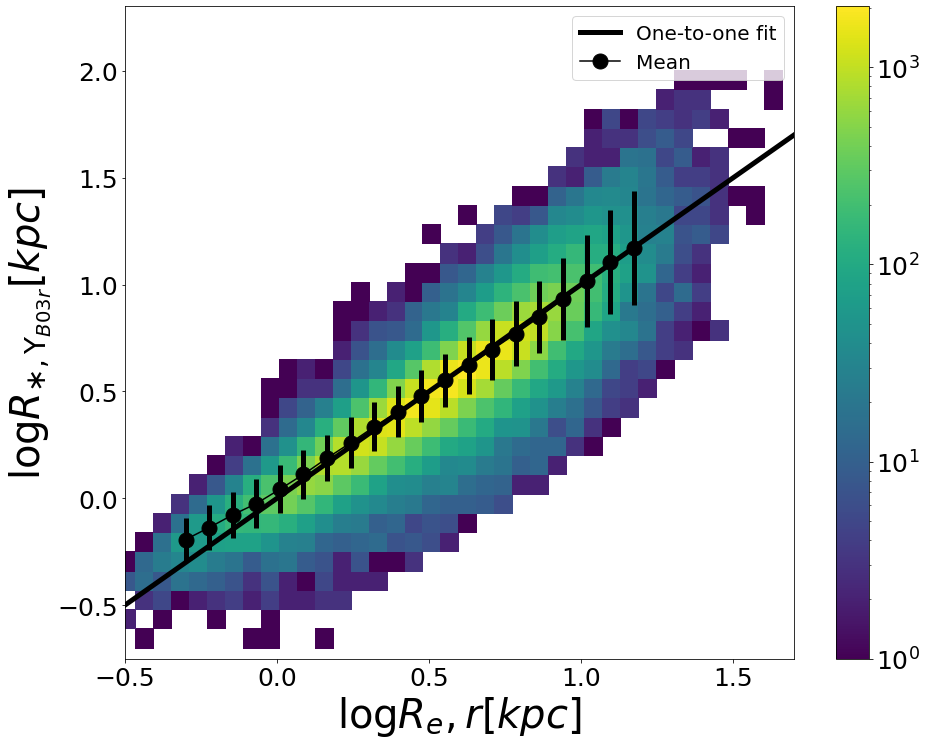

In [62]:
fig, ax= plt.subplots(figsize=(15,12))

x = np.linspace(-0.75,2.5)

# Re_r VS Re_grB
plt.hist2d(np.log10(Re_r_grB), np.log10(Re_ste_gr_B), bins=(50,30), range=[[-0.7,2.25], [-0.7, 2]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(x, x + 0, linestyle='solid', linewidth=5, zorder=2, color ='black',  label='One-to-one fit')
plt.plot(gr_B_rer_means_bins[:-1], stat_gr_B_rer_mean, zorder=2, color ='black', marker = 'o', markersize= 15,  label='Mean')
plt.errorbar(gr_B_rer_means_bins[:-1], stat_gr_B_rer_mean, yerr=stat_gr_B_rer_std, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.colorbar()  


# Add axis labels

plt.ylabel(r'$\log R_{\ast, \Upsilon_{B03r}} [kpc]$', fontsize=40)
plt.xlabel(r'$\log R_e,r [kpc]$', fontsize=40)

#set axis limits
plt.xlim(-0.5, 1.7)
plt.ylim(-0.75,2.3)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/reffr_ReffgrB.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

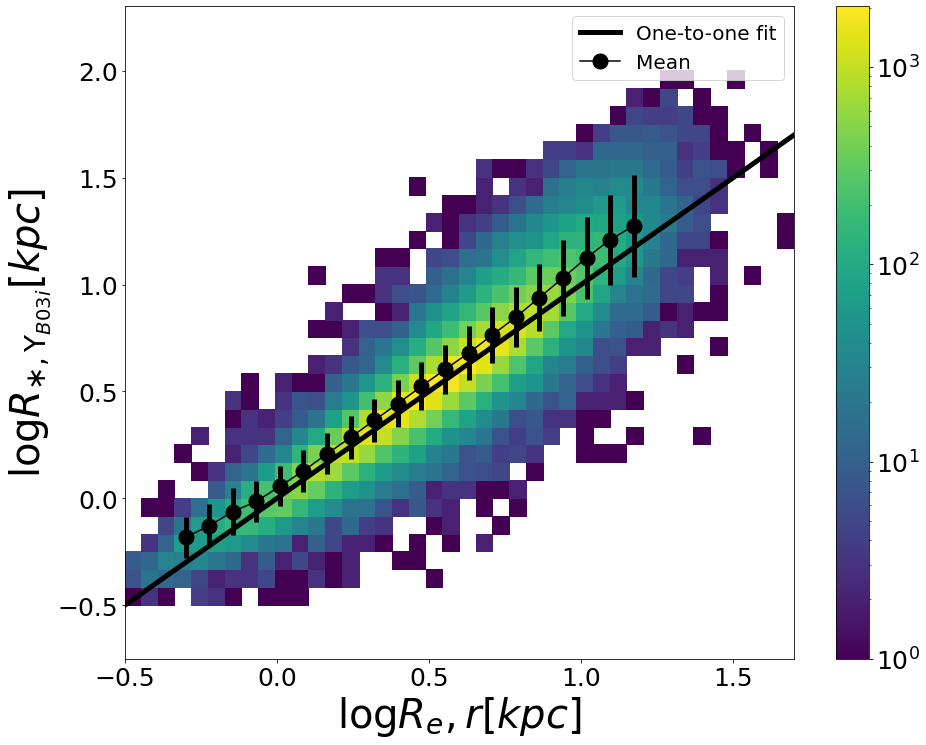

In [63]:
fig, ax= plt.subplots(figsize=(15,12))
    
x = np.linspace(-0.75,2.5)

# Re_r VS Re_giB
plt.hist2d(np.log10(Re_r_giB ), np.log10(Re_ste_gi_B), bins=(50,30), range=[[-0.5,2.25], [-0.5, 2]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(x, x + 0, linestyle='solid', linewidth=5, zorder=2, color ='black',  label='One-to-one fit')
plt.plot(gi_B_rer_means_bins[:-1], stat_gi_B_rer_mean, zorder=2, color ='black', marker = 'o', markersize= 15,  label='Mean')
plt.errorbar(gi_B_rer_means_bins[:-1], stat_gi_B_rer_mean, yerr=stat_gi_B_rer_std, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.colorbar()  

# Add axis labels

plt.ylabel(r'$\log R_{\ast, \Upsilon_{B03i}} [kpc]$', fontsize=40)
plt.xlabel(r'$\log R_e,r [kpc]$', fontsize=40)

#set axis limits
plt.xlim(-0.5, 1.7)
plt.ylim(-0.75,2.3)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/reffr_ReffgiB.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

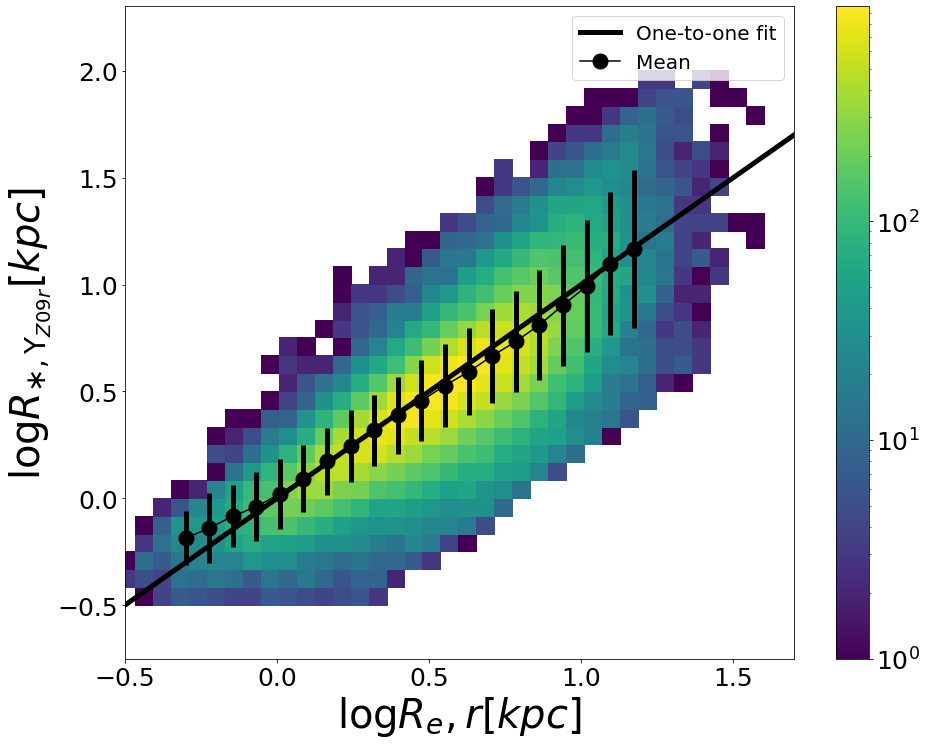

In [64]:
fig, ax= plt.subplots(figsize=(15,12))

x = np.linspace(-0.75,2.5)

# Re_r VS Re_grZ
plt.hist2d(np.log10(Re_r_grZ), np.log10(Re_ste_gr_Z), bins=(50,30), range=[[-0.7,2.25], [-0.5, 2]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(x, x + 0, linestyle='solid', linewidth=5, zorder=2, color ='black',  label='One-to-one fit')
plt.plot(gr_Z_rer_means_bins[:-1], stat_gr_Z_rer_mean, zorder=2, color ='black', marker = 'o', markersize= 15,  label='Mean')
plt.errorbar(gr_Z_rer_means_bins[:-1], stat_gr_Z_rer_mean, yerr=stat_gr_Z_rer_std, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.colorbar()  

# Add axis labels

plt.ylabel(r'$\log R_{\ast, \Upsilon_{Z09r}} [kpc]$', fontsize=40)
plt.xlabel(r'$\log R_e,r [kpc]$', fontsize=40)

#set axis limits
plt.xlim(-0.5, 1.7)
plt.ylim(-0.75,2.3)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/reffr_ReffgrZ.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

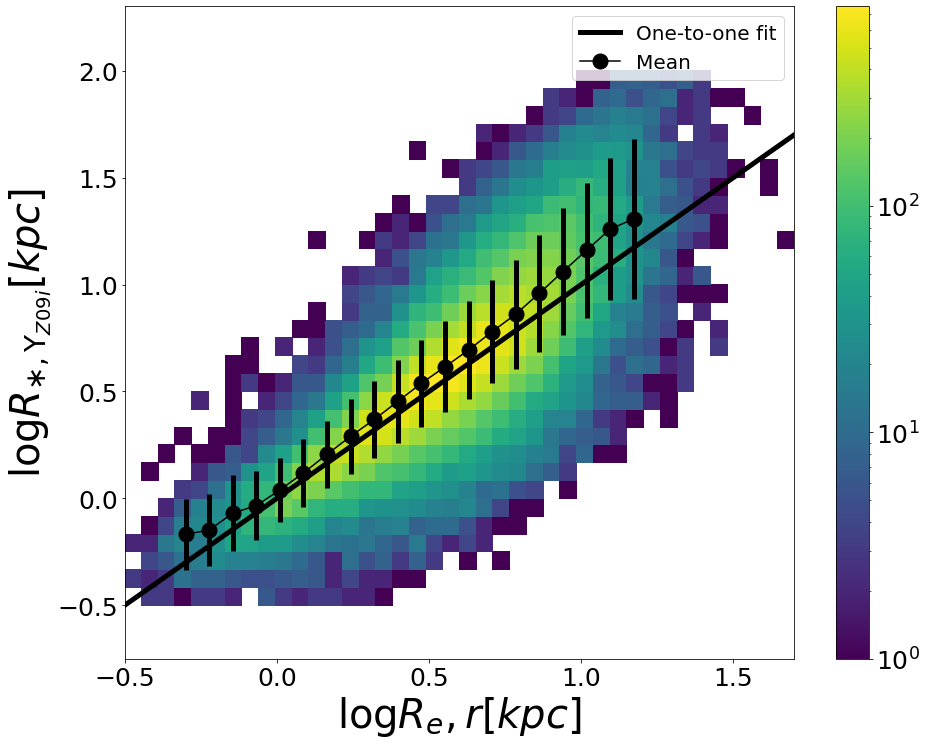

In [65]:
fig, ax= plt.subplots(figsize=(15,12))

x = np.linspace(-0.75,2.5)

# Re_r VS Re_giZ
plt.hist2d(np.log10(Re_r_giZ), np.log10(Re_ste_gi_Z), bins=(50,30), range=[[-0.5,2.25], [-0.5, 2]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(x, x + 0, linestyle='solid', linewidth=5, zorder=2, color ='black',  label='One-to-one fit')
plt.plot(gi_Z_rer_means_bins[:-1], stat_gi_Z_rer_mean, zorder=2, color ='black', marker = 'o', markersize= 15,  label='Mean')
plt.errorbar(gi_Z_rer_means_bins[:-1], stat_gi_Z_rer_mean, yerr=stat_gi_Z_rer_std, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.colorbar()  

# Add axis labels

plt.ylabel(r'$\log R_{\ast, \Upsilon_{Z09i}} [kpc]$', fontsize=40)
plt.xlabel(r'$\log R_e,r [kpc]$', fontsize=40)

#set axis limits
plt.xlim(-0.5, 1.7)
plt.ylim(-0.75,2.3)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/reffr_ReffgiZ.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

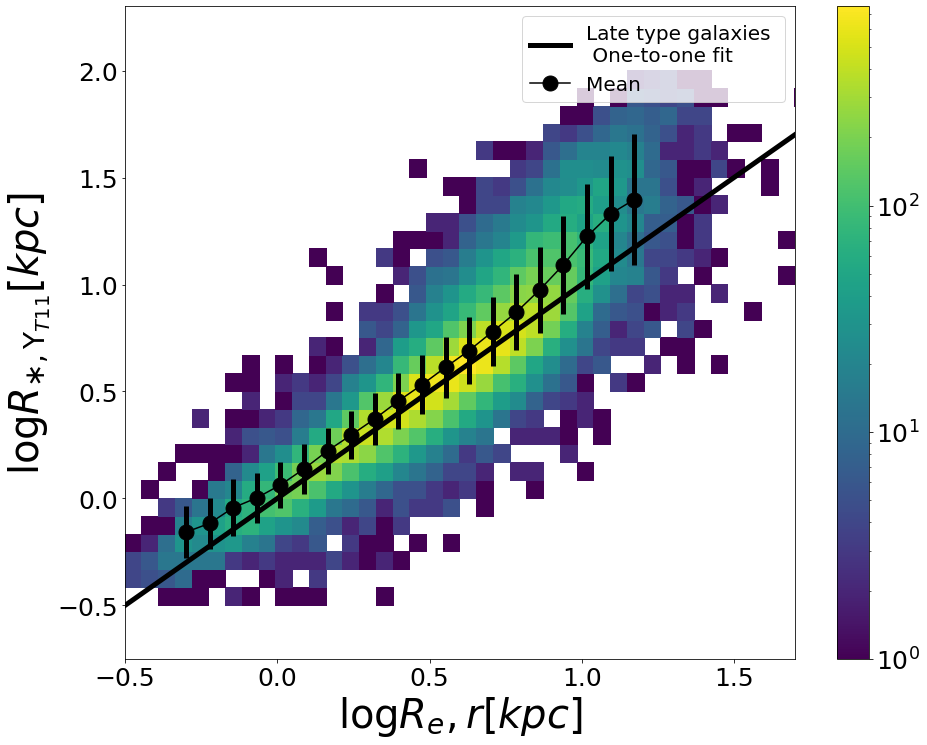

In [66]:
fig, ax= plt.subplots(figsize=(15,12))

x = np.linspace(-0.75,2.5)

# Re_r VS Re_gi late
plt.hist2d(np.log10(re_r_late), np.log10(re_gi_late), bins=(50,30), range=[[-0.5,2.25], [-0.5, 2]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(x, x + 0, linestyle='solid', linewidth=5, zorder=2, color ='black',  label='Late type galaxies \n One-to-one fit')
plt.plot(gi_rer_late_means_bins[:-1], stat_gi_rer_late_mean, zorder=2, color ='black', marker = 'o', markersize= 15,  label='Mean')
plt.errorbar(gi_rer_late_means_bins[:-1], stat_gi_rer_late_mean, yerr=stat_gi_rer_late_std, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.colorbar()  

# Add axis labels

plt.ylabel(r'$\log R_{\ast, \Upsilon_{T11}}[kpc]$', fontsize=40)
plt.xlabel(r'$\log R_e,r [kpc]$', fontsize=40)

#set axis limits
plt.xlim(-0.5, 1.7)
plt.ylim(-0.75,2.3)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/reffr_Reffgilate.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()


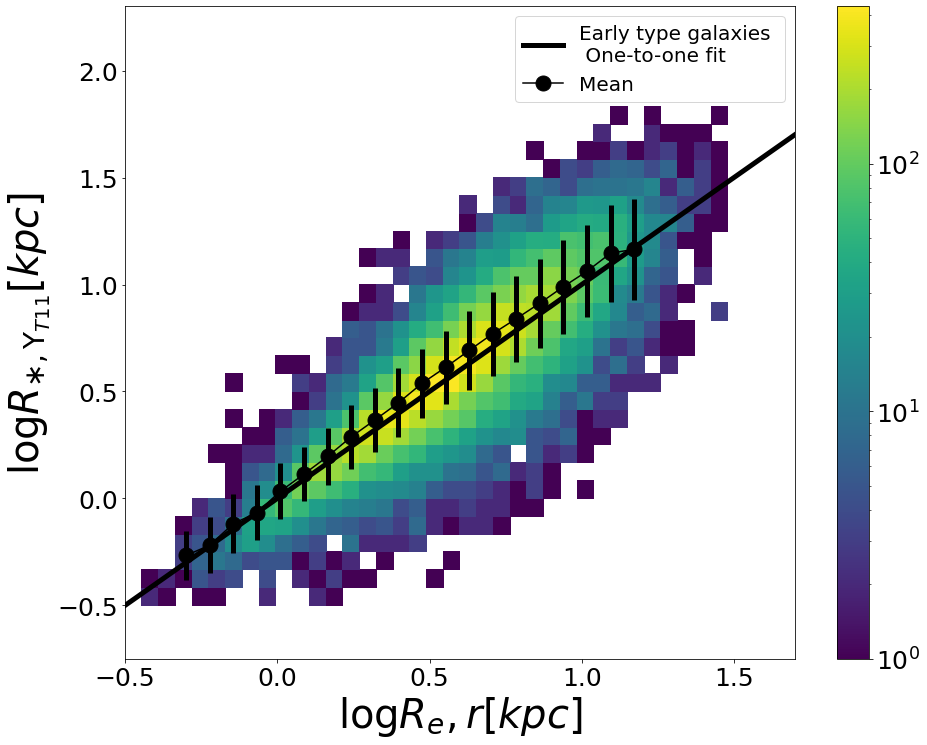

In [67]:
fig, ax= plt.subplots(figsize=(15,12))

x = np.linspace(-0.75,2.5)

# Re_r VS Re_gi early
plt.hist2d(np.log10(re_r_early), np.log10(re_gi_early),bins=(50,30), range=[[-0.5,2.25], [-0.5, 2]], zorder=1,norm=LogNorm(), cmap='viridis')
plt.plot(x, x + 0, linestyle='solid', linewidth=5, zorder=2, color ='black',  label='Early type galaxies \n One-to-one fit')
plt.plot(gi_rer_early_means_bins[:-1], stat_gi_rer_early_mean, zorder=2, color ='black', marker = 'o', markersize= 15,  label='Mean')
plt.errorbar(gi_rer_early_means_bins[:-1], stat_gi_rer_early_mean, yerr=stat_gi_rer_early_std, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.colorbar() 

# Add axis labels

plt.ylabel(r'$\log R_{\ast, \Upsilon_{T11}}[kpc]$', fontsize=40)
plt.xlabel(r'$\log R_e,r [kpc]$', fontsize=40)

#set axis limits
plt.xlim(-0.5, 1.7)
plt.ylim(-0.75,2.3)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/reffr_Reffgiearly.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

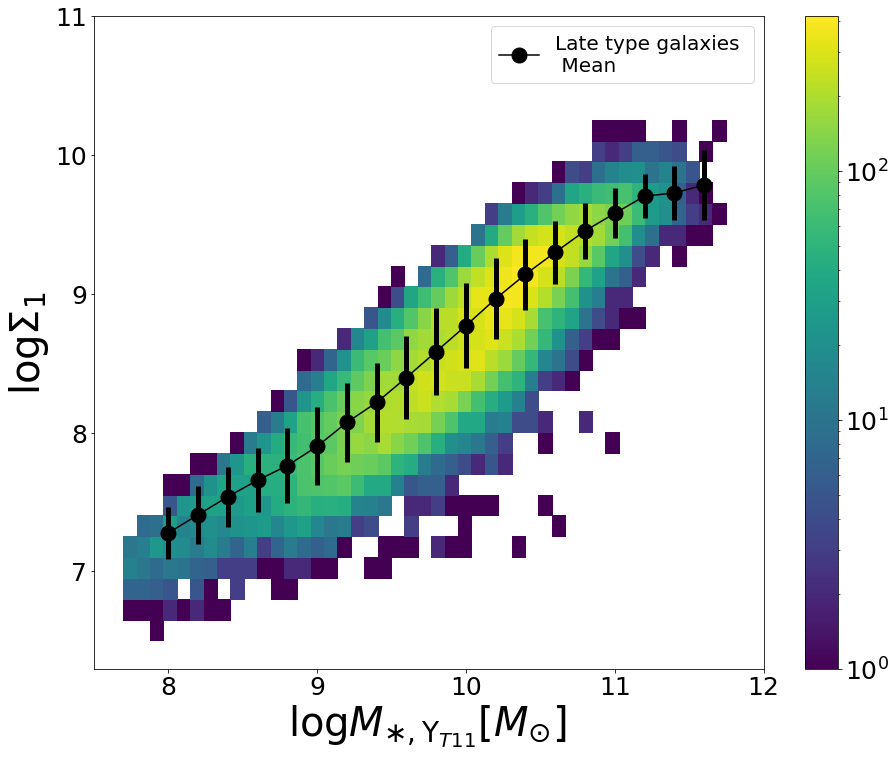

In [68]:
fig, ax= plt.subplots(figsize=(15,12))

# Sigma1 VS Ms_gi late Taylor
plt.hist2d(np.log10(Ms_gi_late), np.log10(S1_gi_late), bins=(50,30), range=[[7.7,12.2],[6.5,11]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(giS1late_mean_bins[:-1], stat_giS1_late_mean, zorder=2, color ='black', marker = 'o', markersize= 15,  label='Late type galaxies \n Mean')
plt.errorbar(giS1late_mean_bins[:-1], stat_giS1_late_mean, yerr=stat_giS1_late_std, xerr=None, ls='None', ecolor='black', elinewidth=5)

plt.colorbar() 

# Add axis labels

plt.xlabel(r'$\log M_{\ast, \Upsilon_{T11}} [M_{\odot}]$ ', fontsize=40)
plt.ylabel(r'$\log \Sigma_{1}$', fontsize=40)

#set axis limits
plt.ylim(6.3, 11)
plt.xlim(7.5,12)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/sgm1_MsgilateT.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

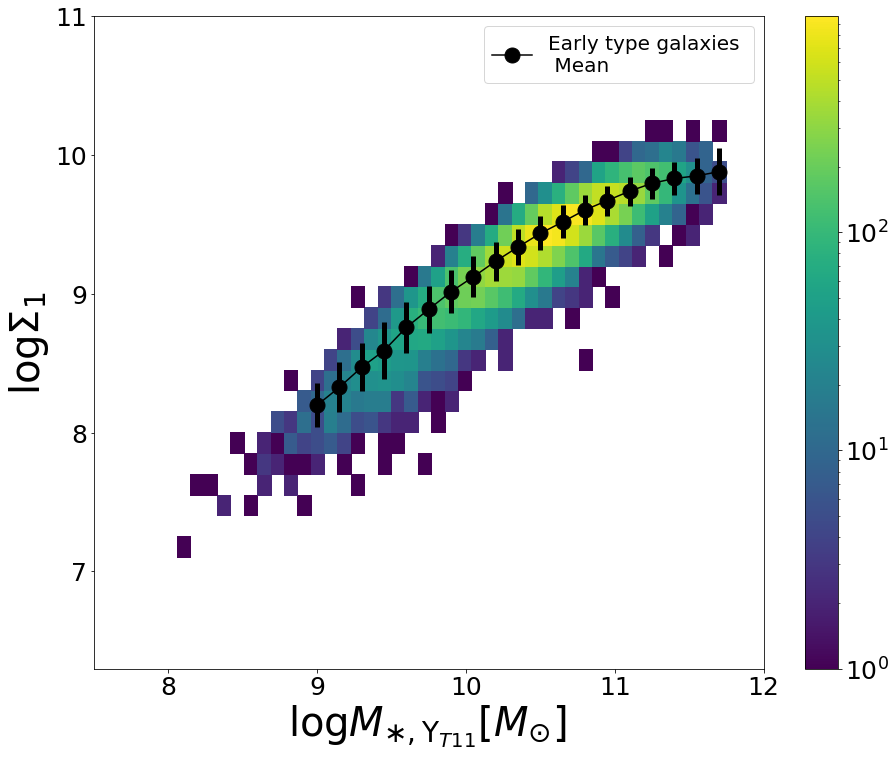

In [69]:
fig, ax= plt.subplots(figsize=(15,12))

# Sigma VS Ms_gi early Taylor
plt.hist2d(np.log10(Ms_gi_early), np.log10(S1_gi_early), bins=(50,30), range=[[7.7,12.2],[6.5,11]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(giS1early_mean_bins[:-1], stat_giS1_early_mean, zorder=2, color ='black', marker = 'o', markersize= 15,  label='Early type galaxies \n Mean')
plt.errorbar(giS1early_mean_bins[:-1], stat_giS1_early_mean, yerr=stat_giS1_early_std, xerr=None, ls='None', ecolor='black', elinewidth=5)

plt.colorbar() 

# Add axis labels

plt.xlabel(r'$\log M_{\ast, \Upsilon_{T11}} [M_{\odot}]$ ', fontsize=40)
plt.ylabel(r'$\log \Sigma_{1}$', fontsize=40)

#set axis limits
plt.ylim(6.3, 11)
plt.xlim(7.5,12)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/sgm1_MsgiearlyT.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

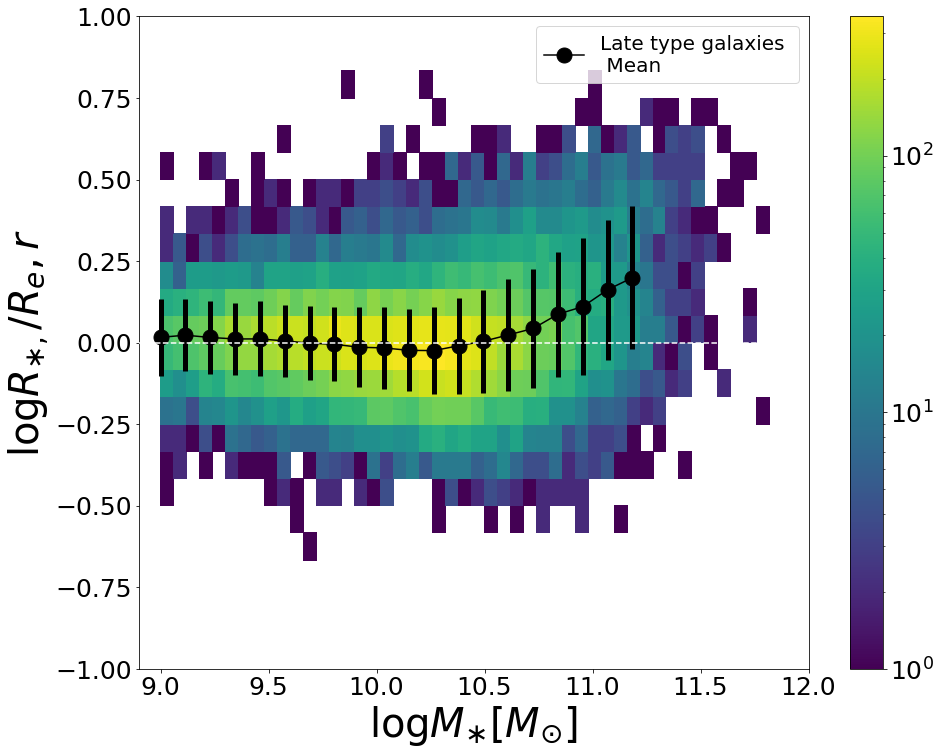

In [70]:
fig, ax= plt.subplots(figsize=(15,12))

# Re/Rer VS Ms_d late Diamond
plt.hist2d(np.log10(Ms_d_late),np.log10(r_d_late), bins=(50,30), range=[[9, 12], [-1.25, 1.25]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(dlate_means_bins[:-1], stat_d_late_mean, zorder=2, color ='black', marker = 'o', markersize= 15,  label='Late type galaxies \n Mean')
plt.errorbar(dlate_means_bins[:-1], stat_d_late_mean, yerr=stat_d_std_late, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.colorbar() 
x = [8.9,12]
y = [0,0]
plt.plot(x, y, zorder = 3, color='white', linestyle='--')

# Add axis labels

plt.xlabel(r'$\log M_{\ast} [M_{\odot}]$', fontsize=40)
plt.ylabel(r'$\log R_{\ast,}/R_e,r$', fontsize=40)

#set axis limits
plt.ylim(-1, 1)
plt.xlim(8.9,12)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size


plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/ratio_Msdlate.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()


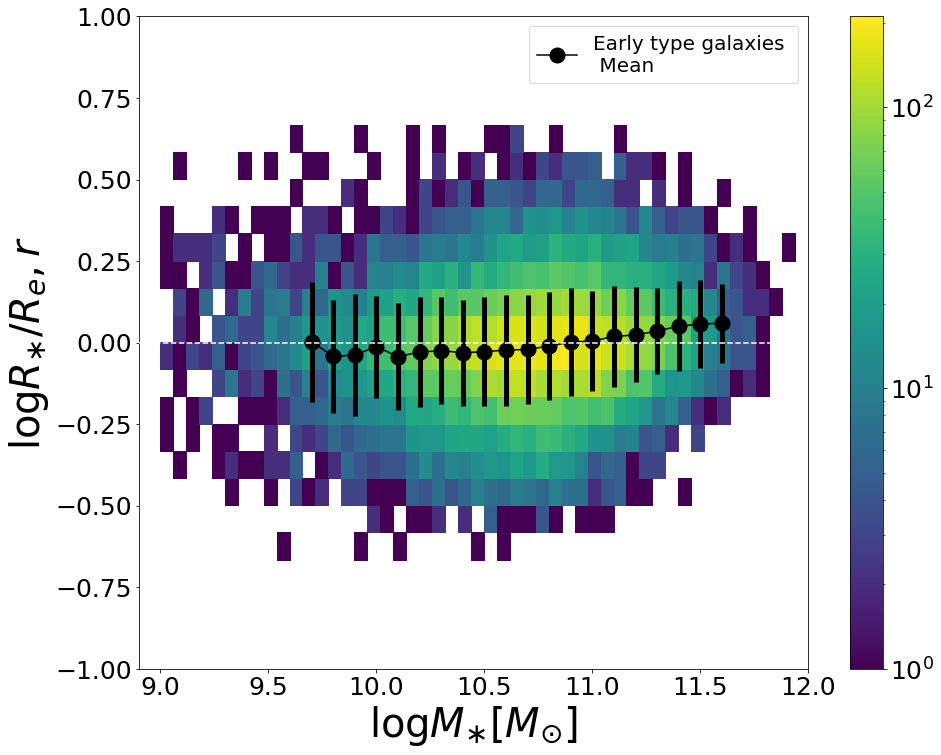

In [71]:
fig, ax= plt.subplots(figsize=(15,12))

# Re/Rer VS Ms_d early Diamond
plt.hist2d(np.log10(Ms_d_early), np.log10(r_d_early), bins=(50,30), range=[[9,12], [-1.25,1.25]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(dearly_means_bins[:-1], stat_d_early_mean, zorder=2, color ='black', marker = 'o', markersize= 15,  label='Early type galaxies \n Mean')
plt.errorbar(dearly_means_bins[:-1], stat_d_early_mean, yerr=stat_d_std_early, xerr=None, ls='None', ecolor='black', elinewidth=5)
x = [8.9,12]
y = [0,0]
plt.plot(x, y, zorder = 3, color='white', linestyle='--')
plt.colorbar() 

# Add axis labels

plt.xlabel(r'$\log M_{\ast} [M_{\odot}]$', fontsize=40)
plt.ylabel(r'$\log R_{\ast}/R_e,r$', fontsize=40)

#set axis limits
plt.ylim(-1, 1)
plt.xlim(8.9,12)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/ratio_Msdearly.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()


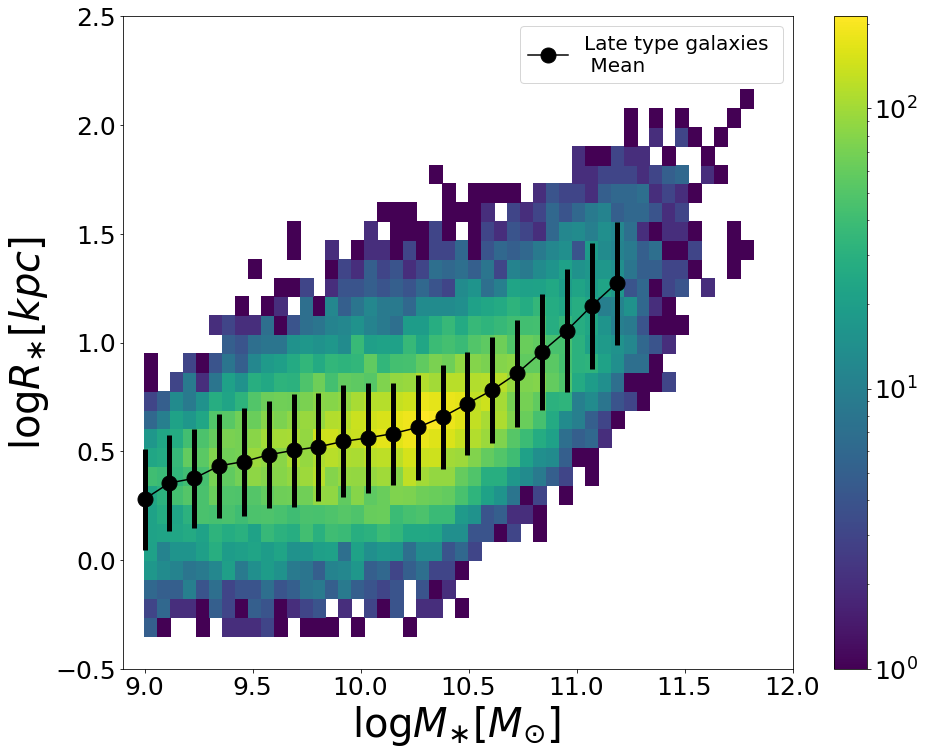

In [72]:
fig, ax= plt.subplots(figsize=(15,12))

# Re_d VS Ms_d late Diamond
plt.hist2d(np.log10(Ms_d_late), np.log10(re_d_late), bins=(50,30), range=[[9,12],[-.35,2.25]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(dlate_nr_mean_bins[:-1], stat_dlate_nr_mean, zorder=2, color ='black', marker = 'o', markersize= 15,  label='Late type galaxies \n Mean')
plt.errorbar(dlate_nr_mean_bins[:-1], stat_dlate_nr_mean, yerr=stat_dlate_nr_std, xerr=None, ls='None', ecolor='black', elinewidth=5)

plt.colorbar() 

# Add axis labels

plt.xlabel(r'$\log M_{\ast} [M_{\odot}]$ ', fontsize=40)
plt.ylabel(r'$\log R_{\ast}[kpc]$', fontsize=40)

#set axis limits
plt.ylim(-0.5, 2.5)
plt.xlim(8.9,12)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/reff_Msdlate.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()


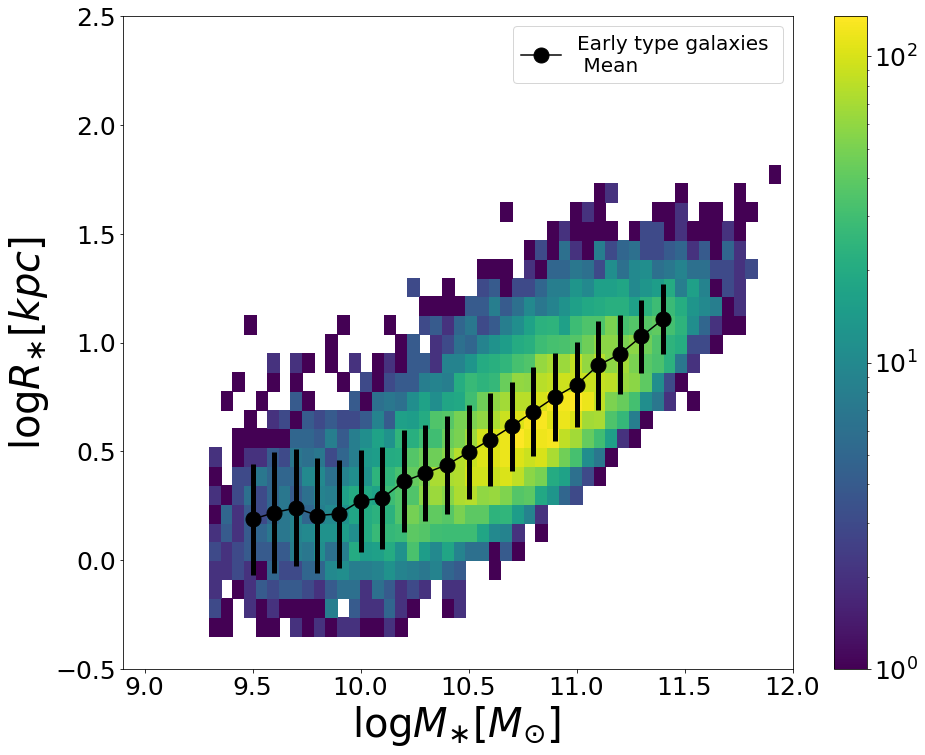

In [103]:
fig, ax= plt.subplots(figsize=(15,12))

# Re_d VS Ms_d early  Diamond
plt.hist2d(np.log10(Ms_d_early), np.log10(re_d_early), bins=(50,30), range=[[9.3,12],[-.35,2.25]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(dearly_nr_mean_bins[:-1], stat_dearly_nr_mean, zorder=2, color ='black', marker = 'o', markersize= 15,  label='Early type galaxies \n Mean ')
plt.errorbar(dearly_nr_mean_bins[:-1], stat_dearly_nr_mean, yerr=stat_dearly_nr_std, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.colorbar() 

# Add axis labels

plt.xlabel(r'$\log M_{\ast} [M_{\odot}]$ ', fontsize=40)
plt.ylabel(r'$\log R_{\ast}[kpc]$', fontsize=40)

#set axis limits
plt.ylim(-0.5, 2.5)
plt.xlim(8.9,12)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/reff_Msdearly.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

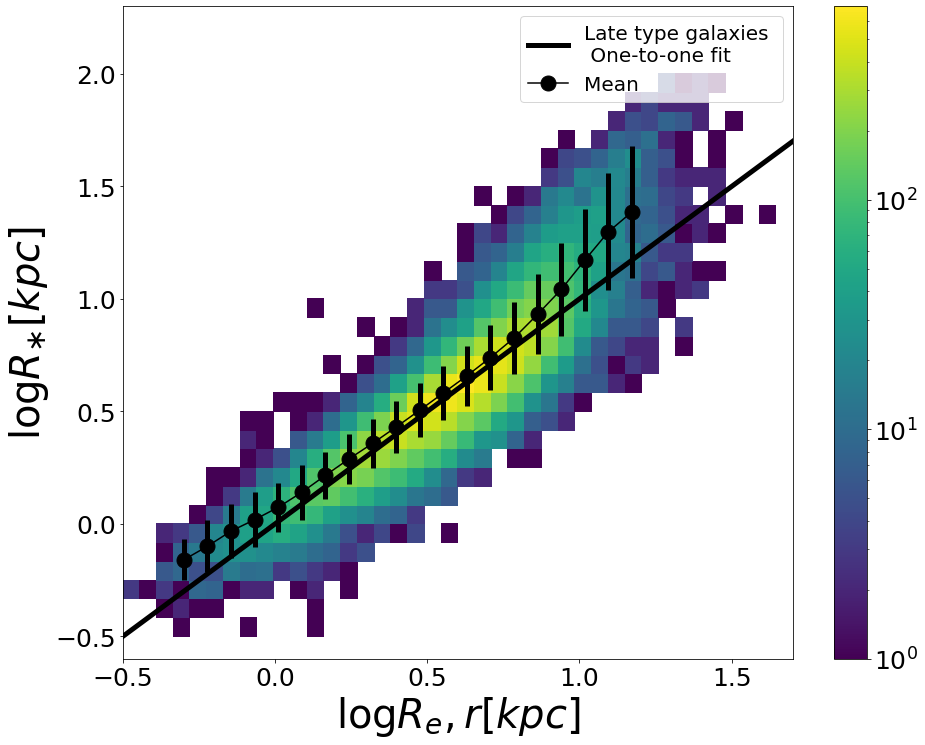

In [74]:
fig, ax= plt.subplots(figsize=(15,12))

x = np.linspace(-0.75,2.5)

# Re_r VS Re_d late Diamond
plt.hist2d(np.log10(re_r_d_late), np.log10(re_d_late), bins=(50,30), range=[[-0.5,2.25], [-0.5, 2]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(x, x + 0, linestyle='solid', linewidth=5, zorder=2, color ='black',  label='Late type galaxies \n One-to-one fit')
plt.plot(d_rer_late_means_bins[:-1], stat_d_rer_late_mean, zorder=2, color ='black', marker = 'o', markersize= 15,  label='Mean')
plt.errorbar(d_rer_late_means_bins[:-1], stat_d_rer_late_mean, yerr=stat_d_rer_late_std, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.colorbar()  

# Add axis labels

plt.ylabel(r'$\log R_{\ast}[kpc]$', fontsize=40)
plt.xlabel(r'$\log R_e,r [kpc]$', fontsize=40)

#set axis limits
plt.xlim(-0.5, 1.7)
plt.ylim(-0.6,2.3)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/reffr_Reffdlate.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()


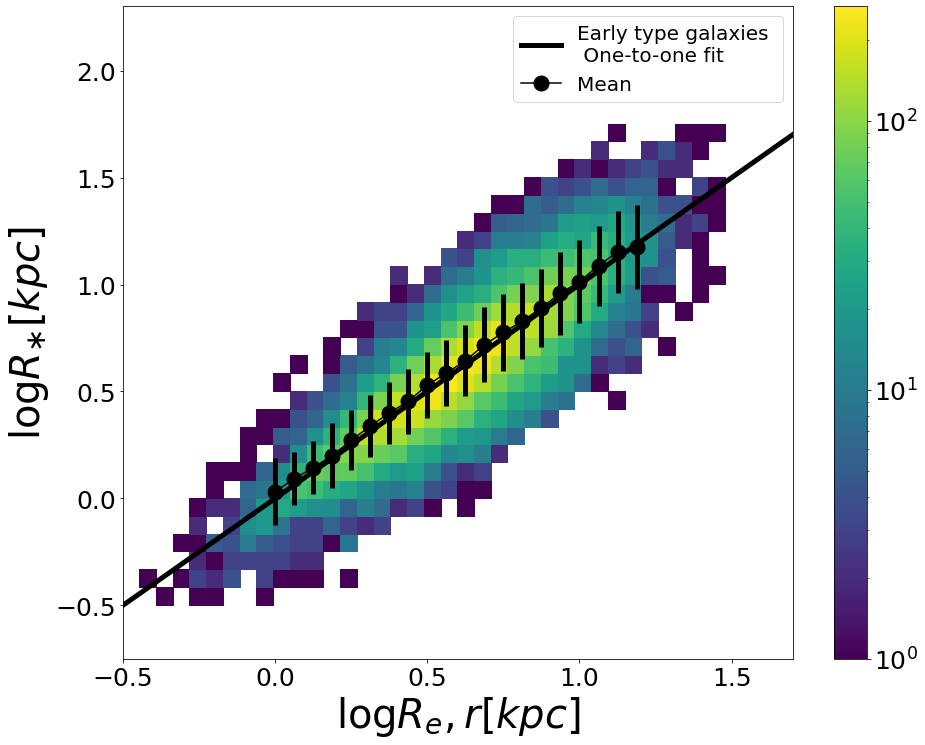

In [75]:
fig, ax= plt.subplots(figsize=(15,12))

x = np.linspace(-0.75,2.5)

# Re_r VS Re_gi early Diamond
plt.hist2d(np.log10(re_r_d_early), np.log10(re_d_early),bins=(50,30), range=[[-0.5,2.25], [-0.5, 2]], zorder=1,norm=LogNorm(), cmap='viridis')
plt.plot(x, x + 0, linestyle='solid', linewidth=5, zorder=2, color ='black',  label='Early type galaxies \n One-to-one fit')
plt.plot(d_rer_early_means_bins[:-1], stat_d_rer_early_mean, zorder=2, color ='black', marker = 'o', markersize= 15,  label='Mean')
plt.errorbar(d_rer_early_means_bins[:-1], stat_d_rer_early_mean, yerr=stat_d_rer_early_std, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.colorbar()  

# Add axis labels

plt.ylabel(r'$\log R_{\ast}[kpc]$', fontsize=40)
plt.xlabel(r'$\log R_e,r [kpc]$', fontsize=40)

#set axis limits
plt.xlim(-0.5, 1.7)
plt.ylim(-0.75,2.3)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/reffr_Reffdearly.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

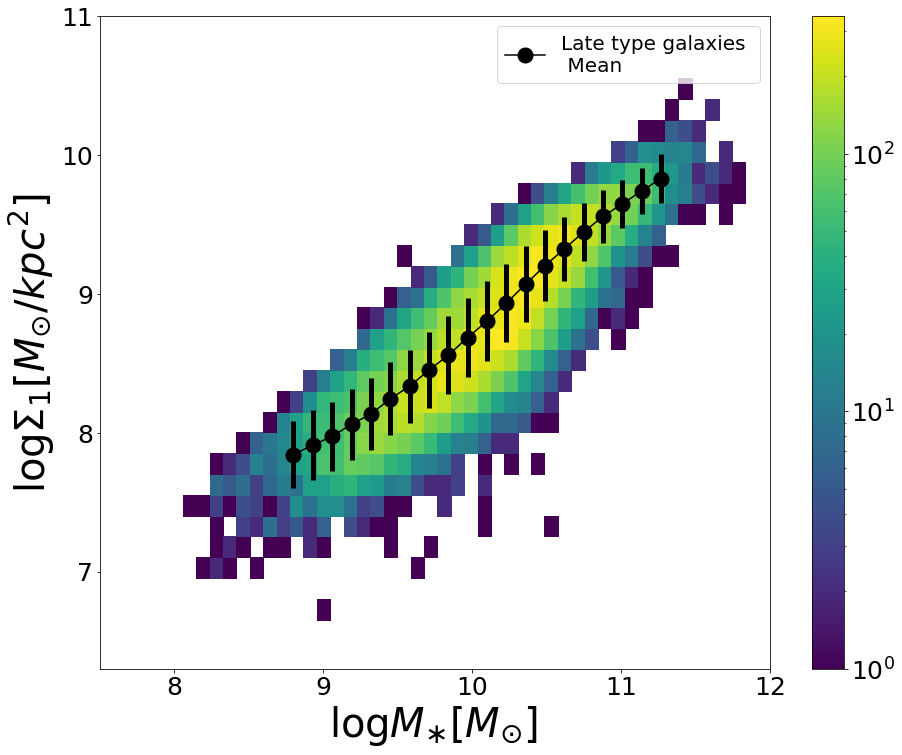

In [76]:
fig, ax= plt.subplots(figsize=(15,12))

# Sigma1 VS Ms_d late Diamond
plt.hist2d(np.log10(Ms_d_late), np.log10(S1_d_late), bins=(50,30), range=[[7.7,12.2],[6.5,11]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(dS1late_mean_bins[:-1], stat_dS1_late_mean, zorder=2, color ='black', marker = 'o', markersize= 15,  label='Late type galaxies \n Mean ')
plt.errorbar(dS1late_mean_bins[:-1], stat_dS1_late_mean, yerr=stat_dS1_late_std, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.colorbar() 

# Add axis labels

plt.xlabel(r'$\log M_{\ast} [M_{\odot}]$ ', fontsize=40)
plt.ylabel(r'$\log \Sigma_{1} [M_{\odot}/ kpc^{2}]$', fontsize=40)

#set axis limits
plt.ylim(6.3, 11)
plt.xlim(7.5,12)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/sgm1_MsdlateD.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

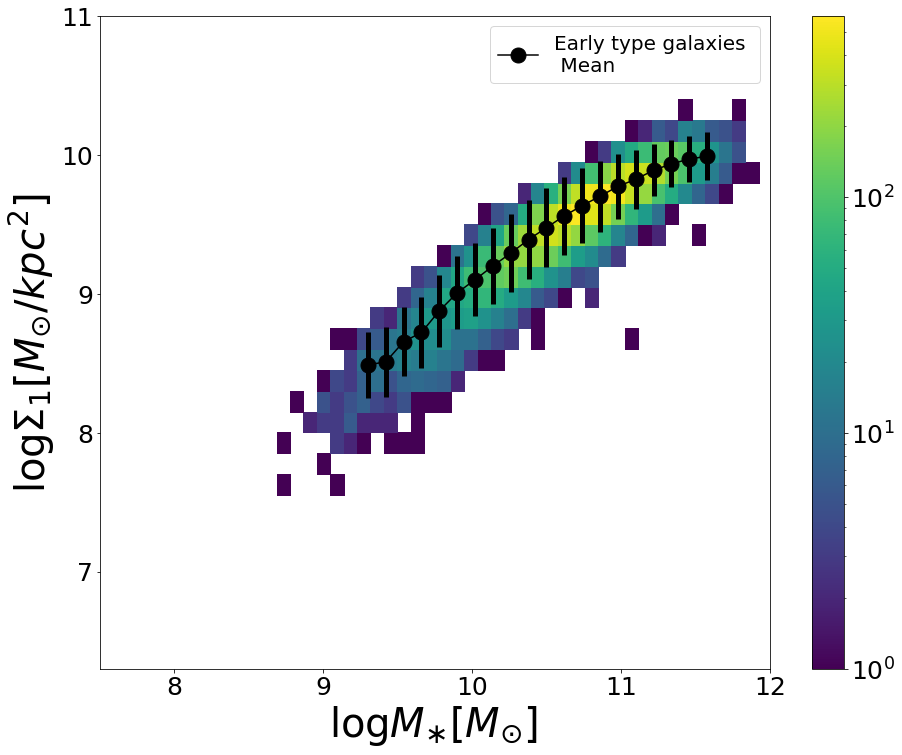

In [77]:
fig, ax= plt.subplots(figsize=(15,12))


# Sigma VS Ms_d early Diamond
plt.hist2d(np.log10(Ms_d_early), np.log10(S1_d_early), bins=(50,30), range=[[7.7,12.2],[6.5,11]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(dS1early_mean_bins[:-1], stat_dS1_early_mean, zorder=2, color ='black', marker = 'o', markersize= 15,  label='Early type galaxies \n Mean')
plt.errorbar(dS1early_mean_bins[:-1], stat_dS1_early_mean, yerr=stat_dS1_late_std, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.colorbar() 

# Add axis labels

plt.xlabel(r'$\log M_{\ast} [M_{\odot}]$ ', fontsize=40)
plt.ylabel(r'$\log \Sigma_{1} [M_{\odot}/ kpc^{2}]$', fontsize=40)

#set axis limits
plt.ylim(6.3, 11)
plt.xlim(7.5,12)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/sgm1_MsdearlyD.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

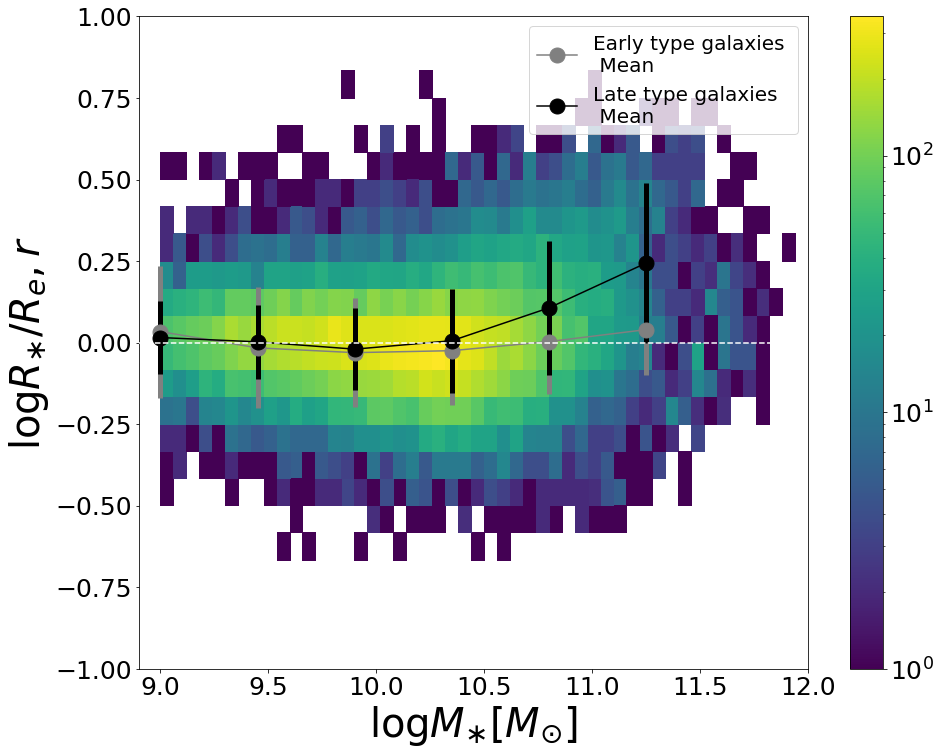

In [89]:
fig, ax= plt.subplots(figsize=(15,12))

# Re/Rer VS Ms_d early/late Diamond
plt.hist2d(np.log10(Ms_d_early), np.log10(r_d_early), bins=(50,30), range=[[9,12], [-1.25,1.25]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(dearlyS_means_bins[:-1], stat_d_earlyS_mean, zorder=2, color ='gray', marker = 'o', markersize= 15,  label='Early type galaxies \n Mean')
plt.errorbar(dearlyS_means_bins[:-1], stat_d_earlyS_mean, yerr=stat_d_std_earlyS, xerr=None, ls='None', ecolor='gray', elinewidth=5)
plt.hist2d(np.log10(Ms_d_late), np.log10(r_d_late), bins=(50,30), range=[[9,12], [-1.25,1.25]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(dlateS_means_bins[:-1], stat_d_lateS_mean, zorder=2, color ='black', marker = 'o', markersize= 15,  label='Late type galaxies \n Mean')
plt.errorbar(dlateS_means_bins[:-1], stat_d_lateS_mean, yerr=stat_d_std_lateS, xerr=None, ls='None', ecolor='black', elinewidth=5)
x = [8.9,12]
y = [0,0]
plt.plot(x, y, zorder = 3, color='white', linestyle='--')
plt.colorbar() 

# Add axis labels

plt.xlabel(r'$\log M_{\ast} [M_{\odot}]$', fontsize=40)
plt.ylabel(r'$\log R_{\ast}/R_e,r$', fontsize=40)

#set axis limits
plt.ylim(-1, 1)
plt.xlim(8.9,12)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/rat_Msd.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

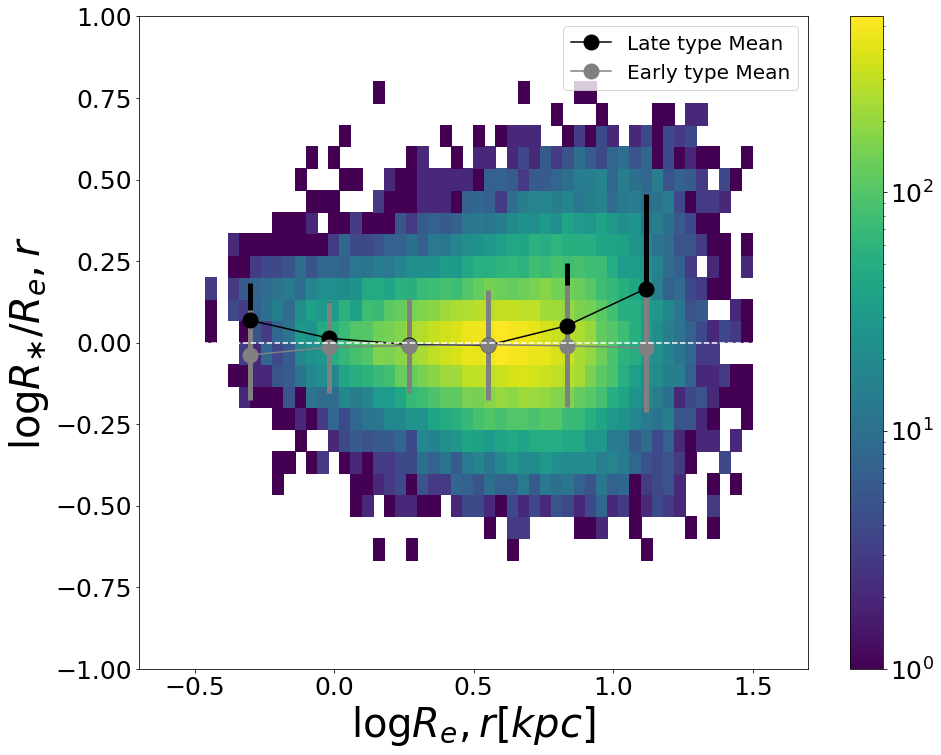

In [95]:
fig, ax= plt.subplots(figsize=(15,12))

# Re/Rer Diamond vs Re_r
plt.hist2d(np.log10(Re_r_d), np.log10(ratio_d), bins=(50,30), range=[[-0.5,1.5], [-1, 1]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(d_rat_rer_late_means_bins[:-1], stat_d_rat_rer_late_mean, zorder=2, color ='black', marker = 'o', markersize= 15,  label='Late type Mean')
plt.errorbar(d_rat_rer_late_means_bins[:-1], stat_d_rat_rer_late_mean, yerr=stat_d_rat_rer_late_std, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.plot(d_rat_rer_early_means_bins[:-1], stat_d_rat_rer_early_mean, zorder=2, color ='gray', marker = 'o', markersize= 15,  label='Early type Mean')
plt.errorbar(d_rat_rer_early_means_bins[:-1], stat_d_rat_rer_early_mean, yerr=stat_d_rat_rer_early_std, xerr=None, ls='None', ecolor='gray', elinewidth=5)
x = [-0.5,1.5]
y = [0,0]
plt.plot(x, y, zorder = 3, color='white', linestyle='--')

plt.colorbar() 

# Add axis labels

plt.xlabel(r'$\log R_e,r [kpc]$', fontsize=40)
plt.ylabel(r'$\log R_{\ast}/R_e,r$', fontsize=40)

#set axis limits
plt.xlim(-.7,1.7)
plt.ylim(-1, 1)


#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/rat_rerD.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()



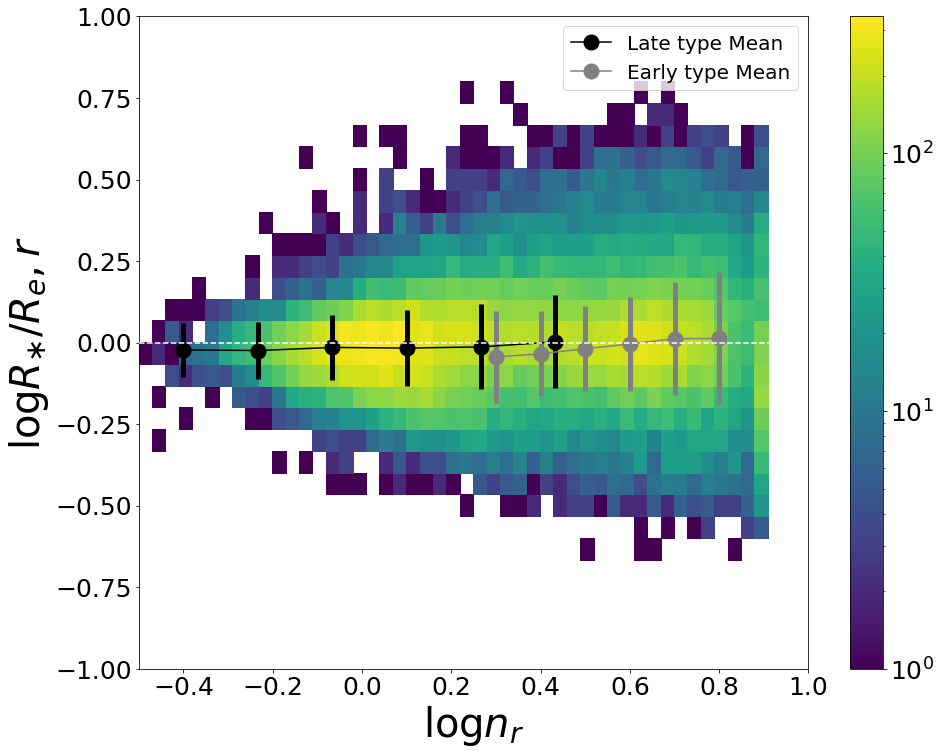

In [96]:
fig, ax= plt.subplots(figsize=(15,12))

# Re/Rer Diamond vs n_r
plt.hist2d(np.log10(n_r_d), np.log10(ratio_d), bins=(50,30), range=[[-0.5,1], [-1, 1]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(d_rat_nr_late_means_bins[:-1], stat_d_rat_nr_late_mean, zorder=2, color ='black', marker = 'o', markersize= 15,  label='Late type Mean')
plt.errorbar(d_rat_nr_late_means_bins[:-1], stat_d_rat_nr_late_mean, yerr=stat_d_rat_nr_late_std, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.plot(d_rat_nr_early_means_bins[:-1], stat_d_rat_nr_early_mean, zorder=2, color ='gray', marker = 'o', markersize= 15,  label='Early type Mean')
plt.errorbar(d_rat_nr_early_means_bins[:-1], stat_d_rat_nr_early_mean, yerr=stat_d_rat_nr_early_std, xerr=None, ls='None', ecolor='gray', elinewidth=5)
plt.colorbar() 
x = [-0.5,1]
y = [0,0]
plt.plot(x, y, zorder = 3, color='white', linestyle='--')

# Add axis labels

plt.xlabel(r'$\log n_r $', fontsize=40)
plt.ylabel(r'$\log R_{\ast}/R_e,r$', fontsize=40)

#set axis limits
plt.xlim(-0.5,1)
plt.ylim(-1, 1)


#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/rat_nrD.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

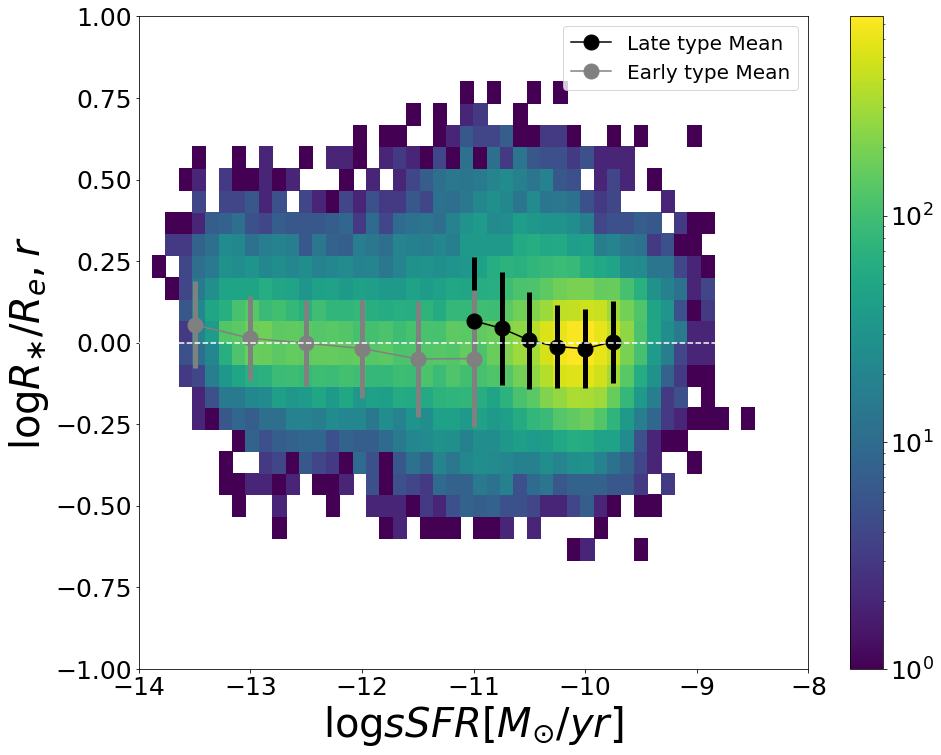

In [97]:
fig, ax= plt.subplots(figsize=(15,12))

# Re/Rer Diamond vs sSFR
plt.hist2d(log_sSFR, np.log10(ratio_d), bins=(50,30), range=[[-14,-8], [-1, 1]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(d_rat_sfr_late_means_bins[:-1], stat_d_rat_sfr_late_mean, zorder=2, color ='black', marker = 'o', markersize= 15,  label='Late type Mean')
plt.errorbar(d_rat_sfr_late_means_bins[:-1], stat_d_rat_sfr_late_mean, yerr=stat_d_rat_sfr_late_std, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.plot(d_rat_sfr_early_means_bins[:-1], stat_d_rat_sfr_early_mean, zorder=2, color ='gray', marker = 'o', markersize= 15,  label='Early type Mean')
plt.errorbar(d_rat_sfr_early_means_bins[:-1], stat_d_rat_sfr_early_mean, yerr=stat_d_rat_sfr_early_std, xerr=None, ls='None', ecolor='gray', elinewidth=5)
plt.colorbar() 
x = [-14,-8]
y = [0,0]
plt.plot(x, y, zorder = 3, color='white', linestyle='--')

# Add axis labels

plt.xlabel(r'$\log sSFR [M_{\odot}/yr]$', fontsize=40)
plt.ylabel(r'$\log R_{\ast}/R_e,r$', fontsize=40)

#set axis limits
plt.xlim(-14,-8)
plt.ylim(-1, 1)


#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/rat_sfrD.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

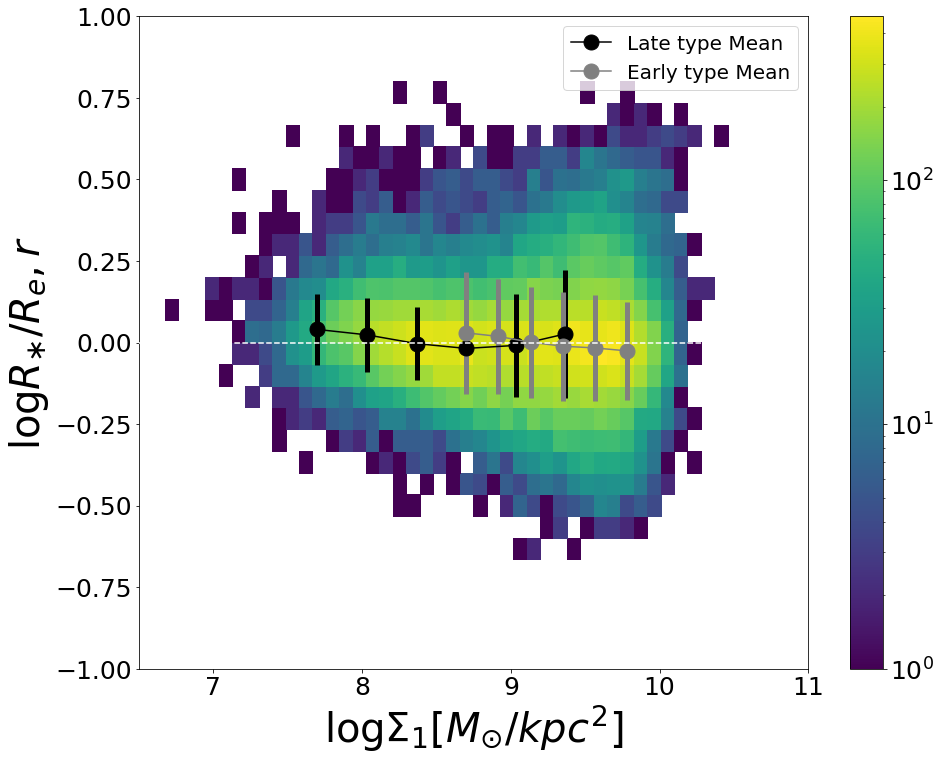

In [98]:
fig, ax= plt.subplots(figsize=(15,12))

# Re/Rer Diamond vs sSFR
plt.hist2d(np.log10(S1_d), np.log10(ratio_d), bins=(50,30), range=[[6.5,11], [-1, 1]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(d_rat_S1_late_means_bins[:-1], stat_d_rat_S1_late_mean, zorder=2, color ='black', marker = 'o', markersize= 15,  label='Late type Mean')
plt.errorbar(d_rat_S1_late_means_bins[:-1], stat_d_rat_S1_late_mean, yerr=stat_d_rat_S1_late_std, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.plot(d_rat_S1_early_means_bins[:-1], stat_d_rat_S1_early_mean, zorder=2, color ='gray', marker = 'o', markersize= 15,  label='Early type Mean')
plt.errorbar(d_rat_S1_early_means_bins[:-1], stat_d_rat_S1_early_mean, yerr=stat_d_rat_S1_early_std, xerr=None, ls='None', ecolor='gray', elinewidth=5)
plt.colorbar() 
x = [6.5,11]
y = [0,0]
plt.plot(x, y, zorder = 3, color='white', linestyle='--')

# Add axis labels

plt.xlabel(r'$\log \Sigma_{1} [M_{\odot}/ kpc^{2}]$', fontsize=40)
plt.ylabel(r'$\log R_{\ast}/R_e,r$', fontsize=40)

#set axis limits
plt.xlim(6.5,11)
plt.ylim(-1, 1)


#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/rat_S1D.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

TypeError: __init__() got an unexpected keyword argument 'labelcolor'

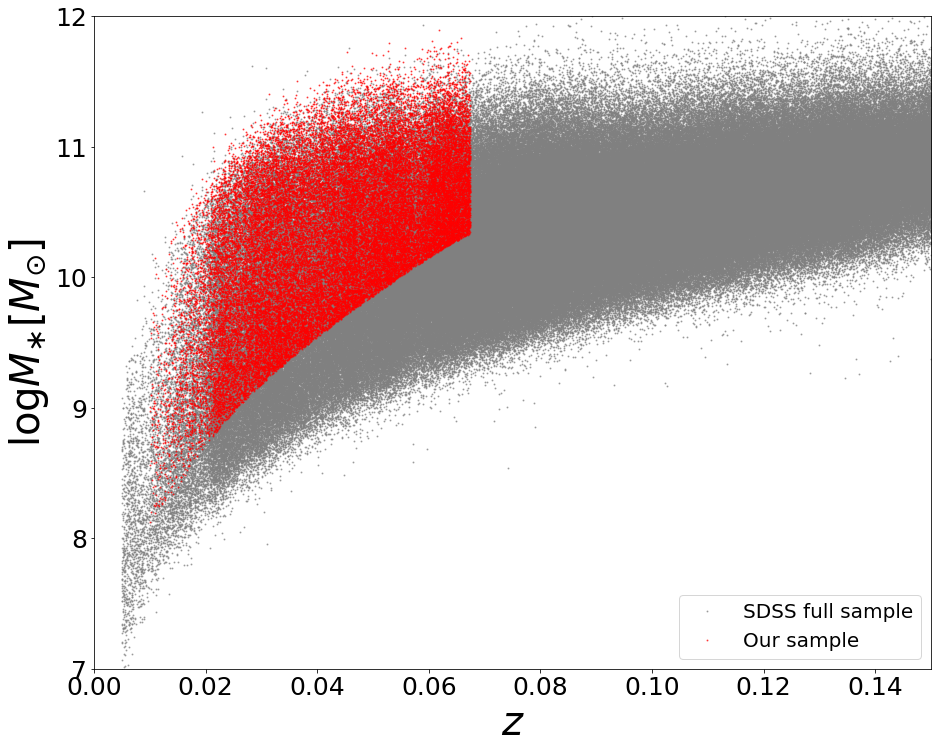

In [44]:
fig, ax= plt.subplots(figsize=(15,12))


# Ms VS z
plt.plot(z_full, np.log10(Ms_gi_full) ,'.', color='grey' , markersize=2, alpha=0.6, label='SDSS full sample')
plt.plot(z_d, np.log10(Ms_d) ,'.', color='red' , markersize=2, alpha=0.6, label='Our sample')



# Add axis labels

plt.xlabel(r'$z $', fontsize=40)
plt.ylabel(r'$\log M_{\ast} [M_{\odot}]$', fontsize=40)

#set axis limits
plt.ylim(7, 12)
plt.xlim(0,0.15)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.legend(labelcolor='linecolor')   
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/Ms_vs_Z.png',format='pdf',dpi=100, bbox_inches = 'tight')
plt.show()


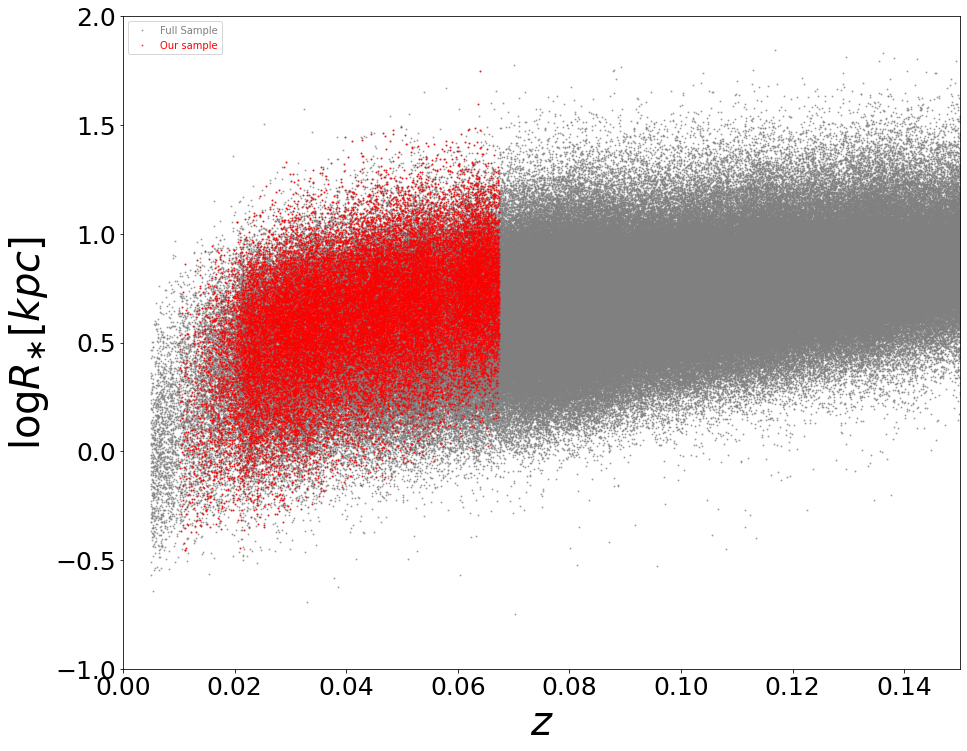

In [230]:
fig, ax= plt.subplots(figsize=(15,12))


# Rer VS z
plt.plot(z_full, np.log10(Re_r_full) ,'.', color='gray' , markersize=2, alpha=0.6, label='Full Sample')
plt.plot(z_d, np.log10(Re_r_d) ,'.', color='red' , markersize=2, alpha=0.6, label='Our sample')

# plt.legend(labelcolor='linecolor')


# Add axis labels

plt.xlabel(r'$z $', fontsize=40)
plt.ylabel(r'$\log R_{\ast} [kpc]$', fontsize=40)

#set axis limits
plt.ylim(-1, 2)
plt.xlim(0,0.15)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.legend(labelcolor='linecolor')   
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/Rer_vs_Z.png',format='pdf',dpi=100, bbox_inches = 'tight')
plt.show()

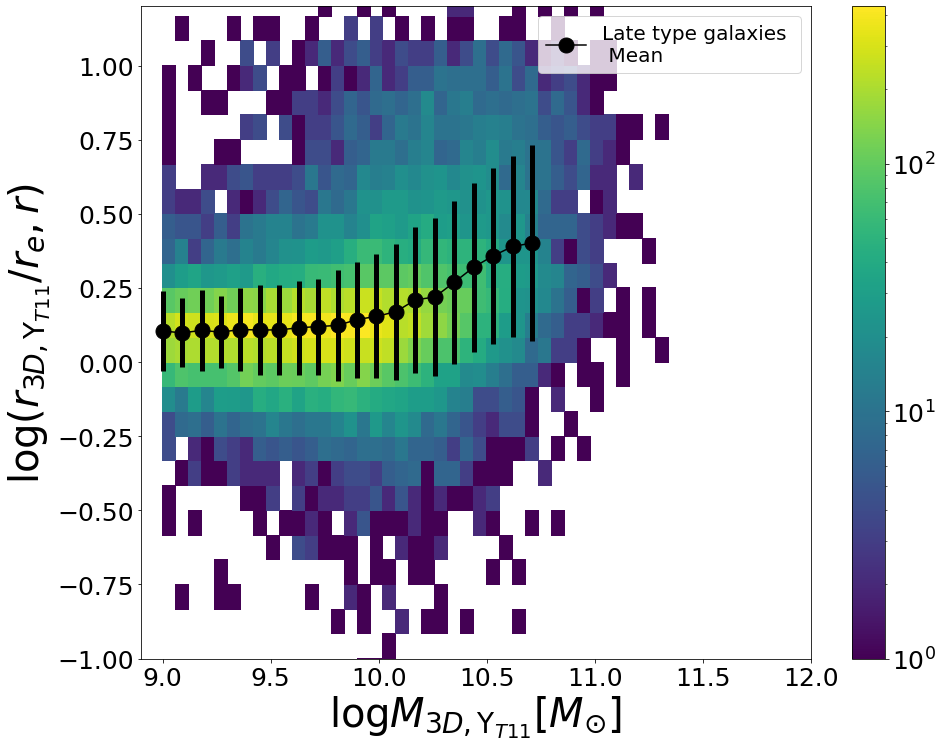

In [246]:
fig, ax= plt.subplots(figsize=(15,12))

# 3D Re/Rer VS Ms_gi late
plt.hist2d(np.log10(Ms_gi_late_3d),np.log10(r_gi_late_3d), bins=(50,30), range=[[9, 12], [-1.25, 1.25]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(gilate_3d_means_bins[:-1], stat_gi_late_3d_mean, zorder=2, color ='black', marker = 'o', markersize= 15,  label='Late type galaxies \n Mean')
plt.errorbar(gilate_3d_means_bins[:-1], stat_gi_late_3d_mean, yerr=stat_gi_std_3d_late, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.colorbar() 

# Add axis labels

plt.xlabel(r'$\log M_{3D, \Upsilon_{T11}} [M_{\odot}]$', fontsize=40)
plt.ylabel(r'$\log (r_{3D, \Upsilon_{T11}}/r_e,r)$', fontsize=40)

#set axis limits
plt.ylim(-1, 1.2)
plt.xlim(8.9,12)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size


plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/ratio3D_Msgilate.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()


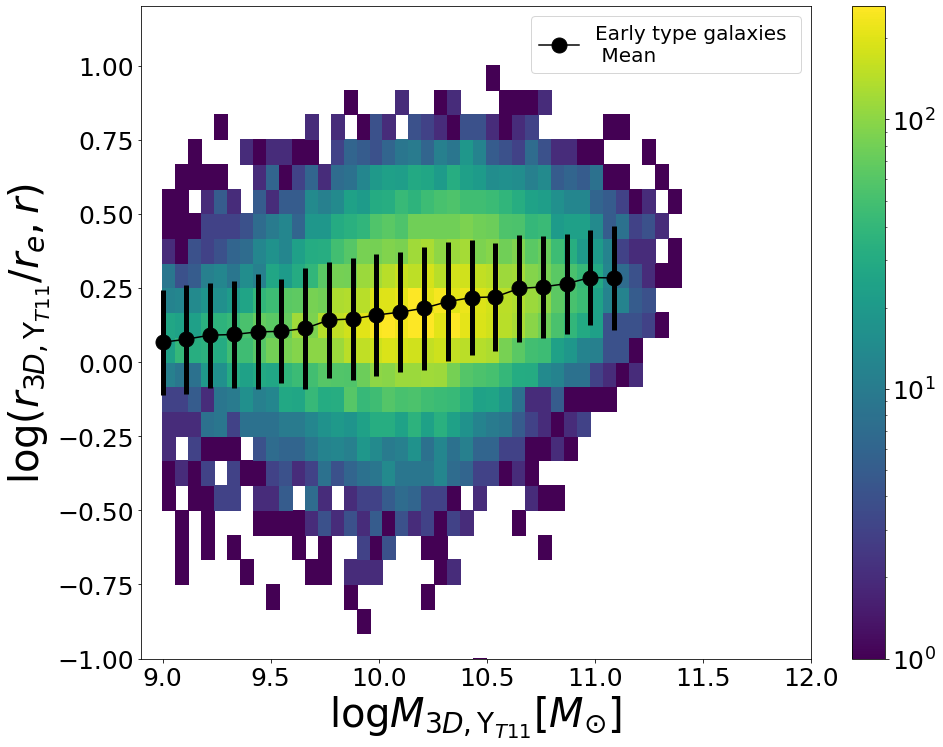

In [247]:
fig, ax= plt.subplots(figsize=(15,12))

# 3D Re/Rer VS Ms_gi early
plt.hist2d(np.log10(Ms_gi_early_3d),np.log10(r_gi_early_3d), bins=(50,30), range=[[9, 12], [-1.25, 1.25]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(giearly_3d_means_bins[:-1], stat_gi_early_3d_mean, zorder=2, color ='black', marker = 'o', markersize= 15,  label='Early type galaxies \n Mean')
plt.errorbar(giearly_3d_means_bins[:-1], stat_gi_early_3d_mean, yerr=stat_gi_std_3d_early, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.colorbar() 

# Add axis labels

plt.xlabel(r'$\log M_{3D, \Upsilon_{T11}} [M_{\odot}]$', fontsize=40)
plt.ylabel(r'$\log (r_{3D, \Upsilon_{T11}}/r_e,r)$', fontsize=40)

#set axis limits
plt.ylim(-1, 1.2)
plt.xlim(8.9,12)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size


plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/ratio3D_Msgiearly.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()


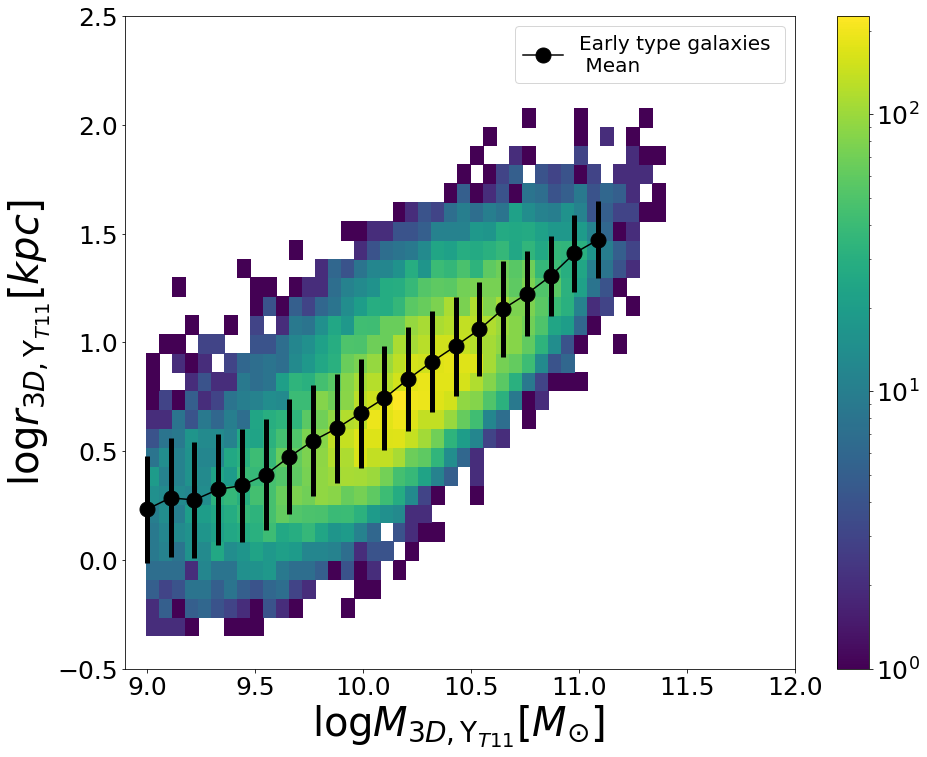

In [243]:
fig, ax= plt.subplots(figsize=(15,12))

# 3D Re_gi VS Ms_gi early Taylor
plt.hist2d(np.log10(Ms_gi_early_3d), np.log10(re_gi_early_3d), bins=(50,30), range=[[9,12],[-.35,2.25]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(giearly3d_mean_bins[:-1], stat_giearly3d_mean, zorder=2, color ='black', marker = 'o', markersize= 15,  label='Early type galaxies \n Mean')
plt.errorbar(giearly3d_mean_bins[:-1], stat_giearly3d_mean, yerr=stat_giearly3d_std, xerr=None, ls='None', ecolor='black', elinewidth=5)

plt.colorbar() 

# Add axis labels

plt.xlabel(r'$\log M_{3D, \Upsilon_{T11}} [M_{\odot}]$ ', fontsize=40)
plt.ylabel(r'$\log r_{3D, \Upsilon_{T11}}[kpc]$', fontsize=40)
#set axis limits
plt.ylim(-0.5, 2.5)
plt.xlim(8.9,12)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/reff_Msgiearly3d.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

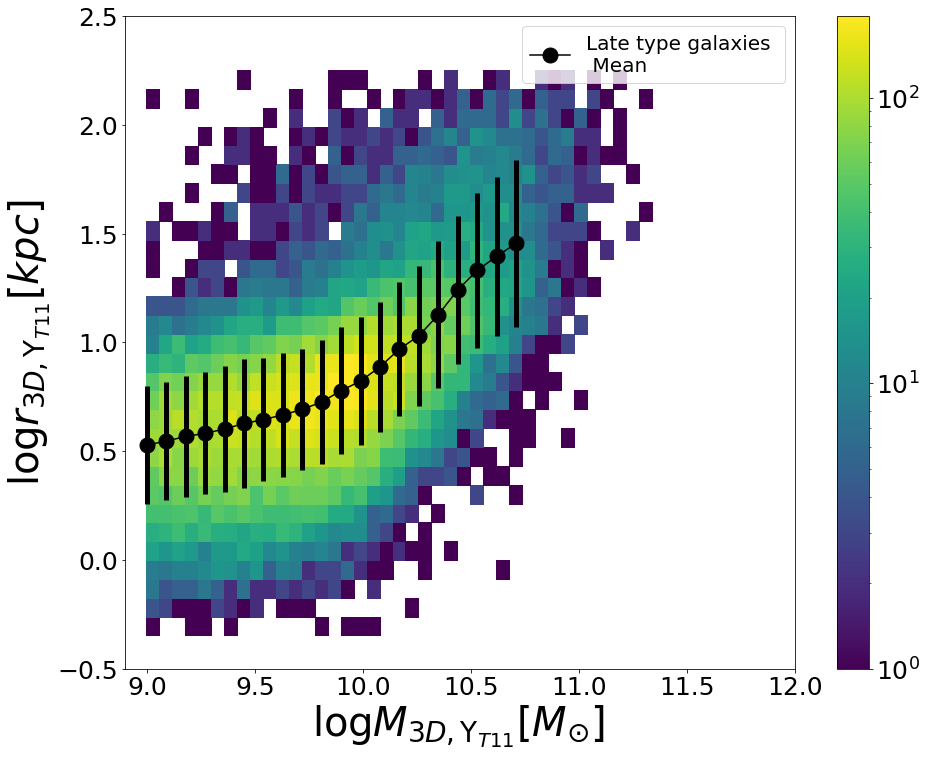

In [242]:
fig, ax= plt.subplots(figsize=(15,12))

# 3D Re_gi VS Ms_gi late Taylor
plt.hist2d(np.log10(Ms_gi_late_3d), np.log10(re_gi_late_3d), bins=(50,30), range=[[9,12],[-.35,2.25]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(gilate3d_mean_bins[:-1], stat_gilate3d_mean, zorder=2, color ='black', marker = 'o', markersize= 15,  label='Late type galaxies \n Mean')
plt.errorbar(gilate3d_mean_bins[:-1], stat_gilate3d_mean, yerr=stat_gilate3d_std, xerr=None, ls='None', ecolor='black', elinewidth=5)

plt.colorbar() 

# Add axis labels

plt.xlabel(r'$\log M_{3D, \Upsilon_{T11}} [M_{\odot}]$ ', fontsize=40)
plt.ylabel(r'$\log r_{3D, \Upsilon_{T11}}[kpc]$', fontsize=40)

#set axis limits
plt.ylim(-0.5, 2.5)
plt.xlim(8.9,12)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/reff_Msgilate3d.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

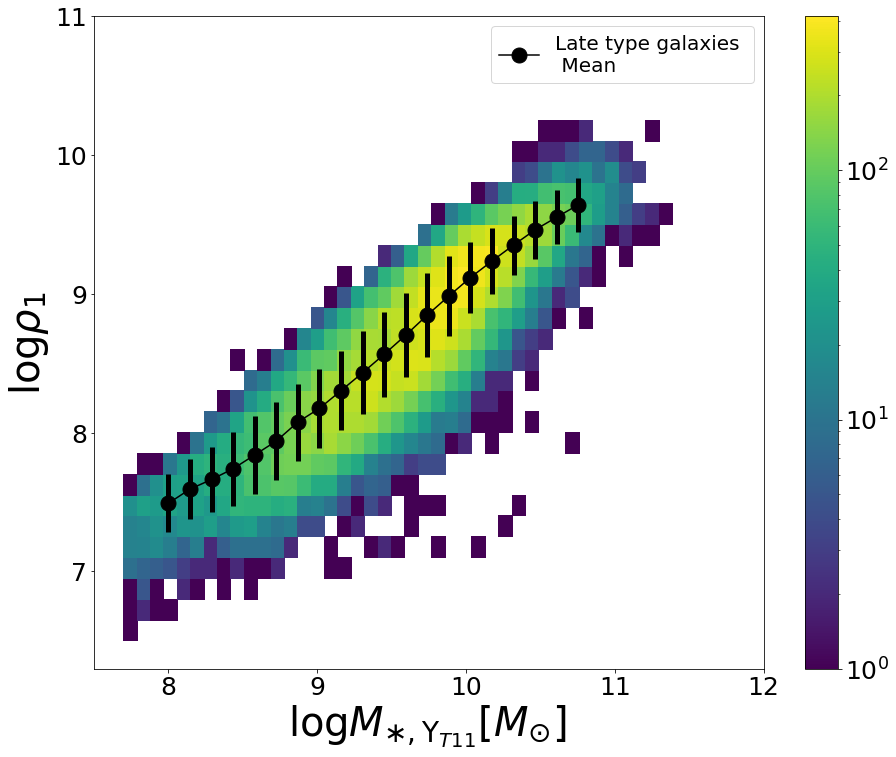

In [237]:
fig, ax= plt.subplots(figsize=(15,12))

# 3D Sigma1 VS Ms_gi late Taylor
plt.hist2d(np.log10(Ms_gi_late_3d), np.log10(S1_gi_late), bins=(50,30), range=[[7.7,12.2],[6.5,11]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(giS1late3d_mean_bins[:-1], stat_giS1_late3d_mean, zorder=2, color ='black', marker = 'o', markersize= 15,  label='Late type galaxies \n Mean')
plt.errorbar(giS1late3d_mean_bins[:-1], stat_giS1_late3d_mean, yerr=stat_giS1_late3d_std, xerr=None, ls='None', ecolor='black', elinewidth=5)

plt.colorbar() 

# Add axis labels

plt.xlabel(r'$\log M_{\ast, \Upsilon_{T11}} [M_{\odot}]$ ', fontsize=40)
plt.ylabel(r'$\log \rho_{1}$', fontsize=40)

#set axis limits
plt.ylim(6.3, 11)
plt.xlim(7.5,12)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/sgm1_Msgilate3D.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

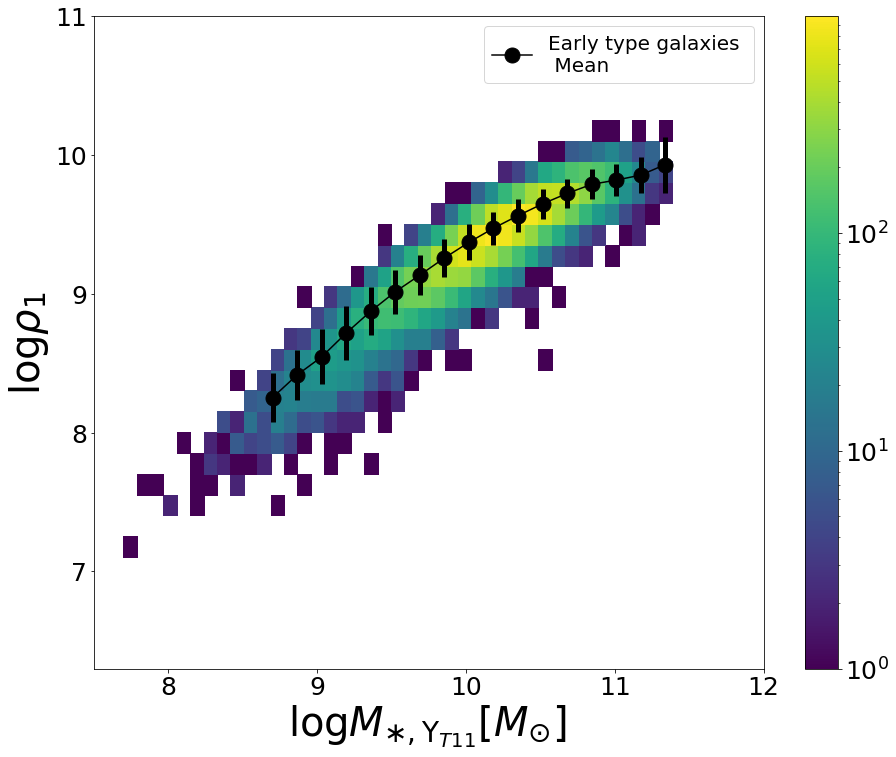

In [238]:
fig, ax= plt.subplots(figsize=(15,12))

# 3D Sigma1 VS Ms_gi early Taylor
plt.hist2d(np.log10(Ms_gi_early_3d), np.log10(S1_gi_early), bins=(50,30), range=[[7.7,12.2],[6.5,11]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(giS1early3d_mean_bins[:-1], stat_giS1_early3d_mean, zorder=2, color ='black', marker = 'o', markersize= 15,  label='Early type galaxies \n Mean')
plt.errorbar(giS1early3d_mean_bins[:-1], stat_giS1_early3d_mean, yerr=stat_giS1_early3d_std, xerr=None, ls='None', ecolor='black', elinewidth=5)

plt.colorbar() 

# Add axis labels

plt.xlabel(r'$\log M_{\ast, \Upsilon_{T11}} [M_{\odot}]$ ', fontsize=40)
plt.ylabel(r'$\log \rho_{1}$', fontsize=40)

#set axis limits
plt.ylim(6.3, 11)
plt.xlim(7.5,12)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/sgm1_Msgiearly3D.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

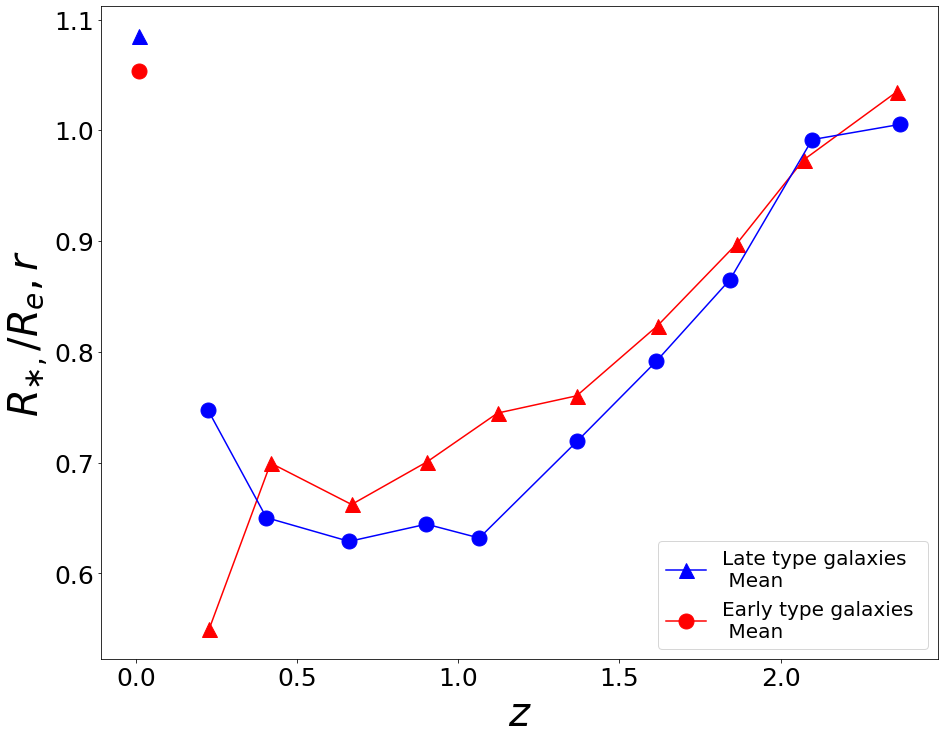

In [100]:
fig, ax= plt.subplots(figsize=(15,12))

# Re/Rer VS z Diamond r band

plt.plot(S_mass_late_means_bins[:-1], stat_S_mass_late_mean, color ='blue', marker = '^', markersize= 15,  label='Late type galaxies \n Mean')
plt.plot(S_mass_early_means_bins[:-1], stat_S_mass_early_mean, color ='red', marker = 'o', markersize= 15,  label='Early type galaxies \n Mean')
#plt.errorbar(S_mass_late_means_bins[:-1], stat_S_mass_late_mean, yerr=stat_S_mass_late_std, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.plot(z_Suess_q, Re_Suess_q , color='red' , marker='^', markersize=15)
plt.plot(z_Suess_sf, Re_Suess_sf , color='blue' , marker='o', markersize=15)
# Add axis labels

plt.xlabel(r'$ z$', fontsize=40)
plt.ylabel(r'$R_{\ast,}/R_e,r$', fontsize=40)

#set axis limits
# plt.ylim(-1, 1)
# plt.xlim(0.005,0.07)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size


plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/ratio_z_S.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()


In [241]:
print(stat_S_mass_late_mean)

[1.0849904]


In [113]:
print(stat_S_mass_early_mean)

[1.0538543]


In [115]:
np.log10(1.0849904)

0.035425895561994464

In [116]:
np.log10(1.0538543)

0.02278057190123993

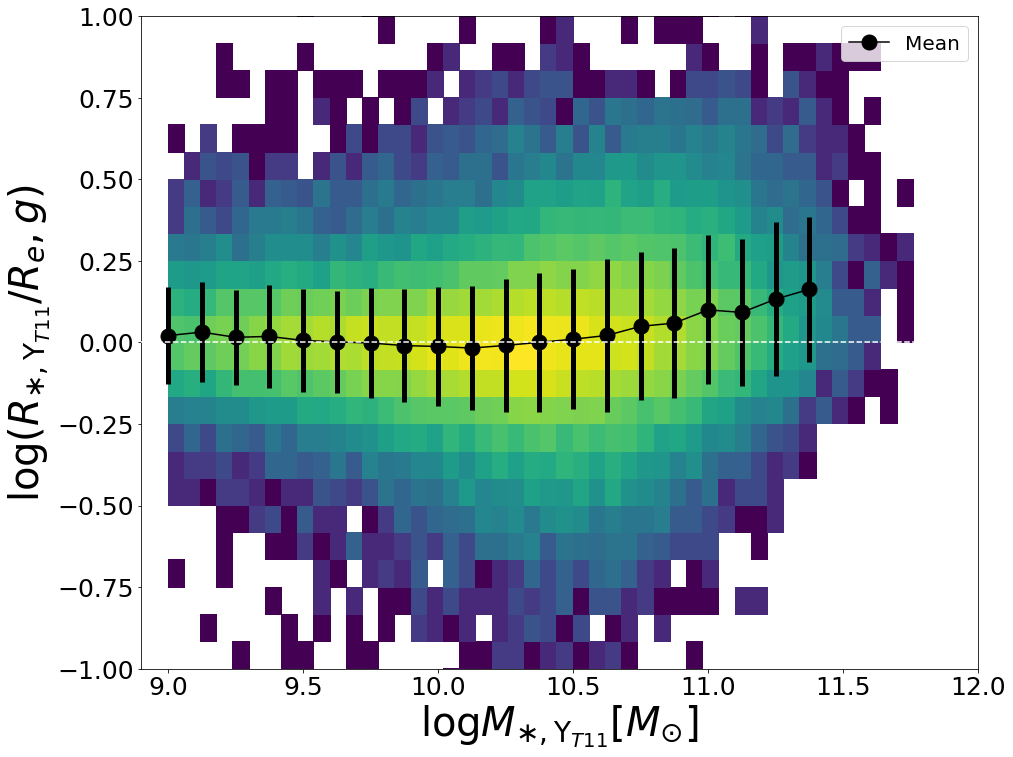

In [127]:
fig, ax= plt.subplots(figsize=(15,12))


# Re/Rer VS Ms_gr 
plt.hist2d(np.log10(Ms_gi), np.log10(ratio_g_gi), bins=(50,30), range=[[9, 12], [-1.25, 1.25]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(gi_g_means_bins[:-1], stat_gi_g_mean, zorder=2, color ='black', marker = 'o', markersize= 15,  label='Mean')
plt.errorbar(gi_g_means_bins[:-1], stat_gi_g_mean, yerr=stat_gi_g_std, xerr=None, ls='None', ecolor='black', elinewidth=5)
x = [8.9,12]
y = [0,0]
plt.plot(x, y, zorder = 3, color='white', linestyle='--')
# Add axis labels

plt.xlabel(r'$\log M_{\ast, \Upsilon_{T11}} [M_{\odot}]$', fontsize=40)
plt.ylabel(r'$\log  (R_{\ast, \Upsilon_{T11}}/R_e,g)$', fontsize=40)

#set axis limits
plt.ylim(-1, 1)
plt.xlim(8.9,12)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/ratiog_Msgi.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()


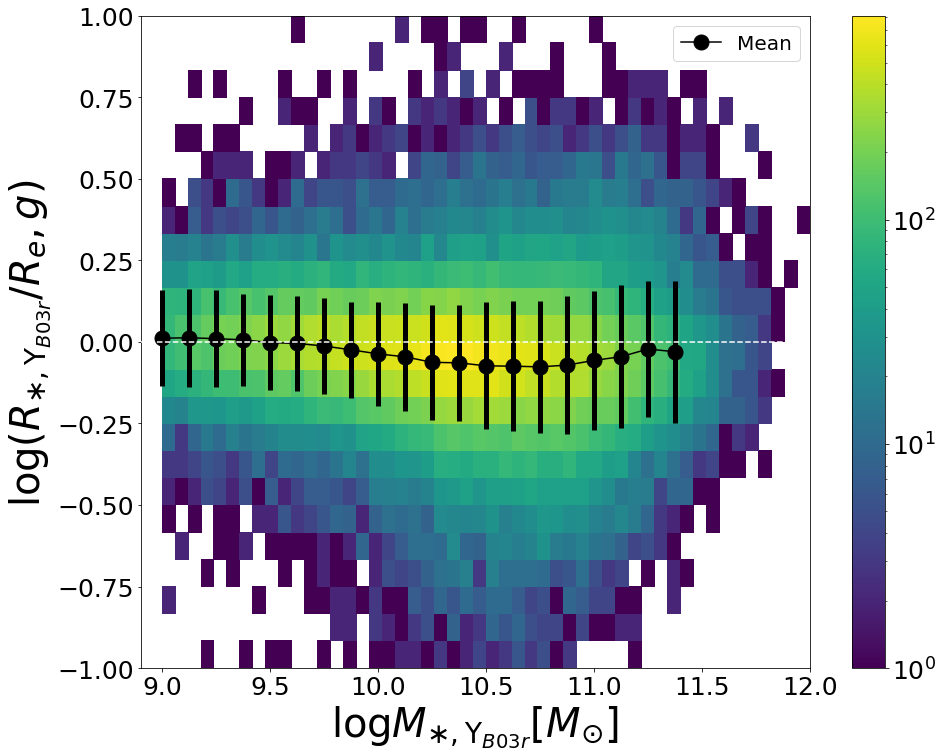

In [126]:
fig, ax= plt.subplots(figsize=(15,12))

# Re/Reg VS Ms_grB

plt.hist2d(np.log10(Ms_gr_B), np.log10(ratio_g_gr_B), bins=(50,30), range=[[9,12],[-1.25,1.25]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(gr_B_g_means_bins[:-1], stat_gr_B_g_mean, zorder=2, color ='black', marker = 'o', markersize= 15,  label='Mean')
plt.errorbar(gr_B_g_means_bins[:-1], stat_gr_B_g_mean, yerr=stat_gr_B_g_std, xerr=None, ls='None', ecolor='black', elinewidth=5)
x = [8.9,12]
y = [0,0]
plt.plot(x, y, zorder = 3, color='white', linestyle='--')
plt.colorbar() 

# Add axis labels

plt.xlabel(r'$\log M_{\ast, \Upsilon_{B03r}} [M_{\odot}]$', fontsize=40)
plt.ylabel(r'$\log (R_{\ast, \Upsilon_{B03r}}/R_e,g)$', fontsize=40)

#set axis limits
plt.ylim(-1, 1)
plt.xlim(8.9,12)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/ratiog_MsgrB.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

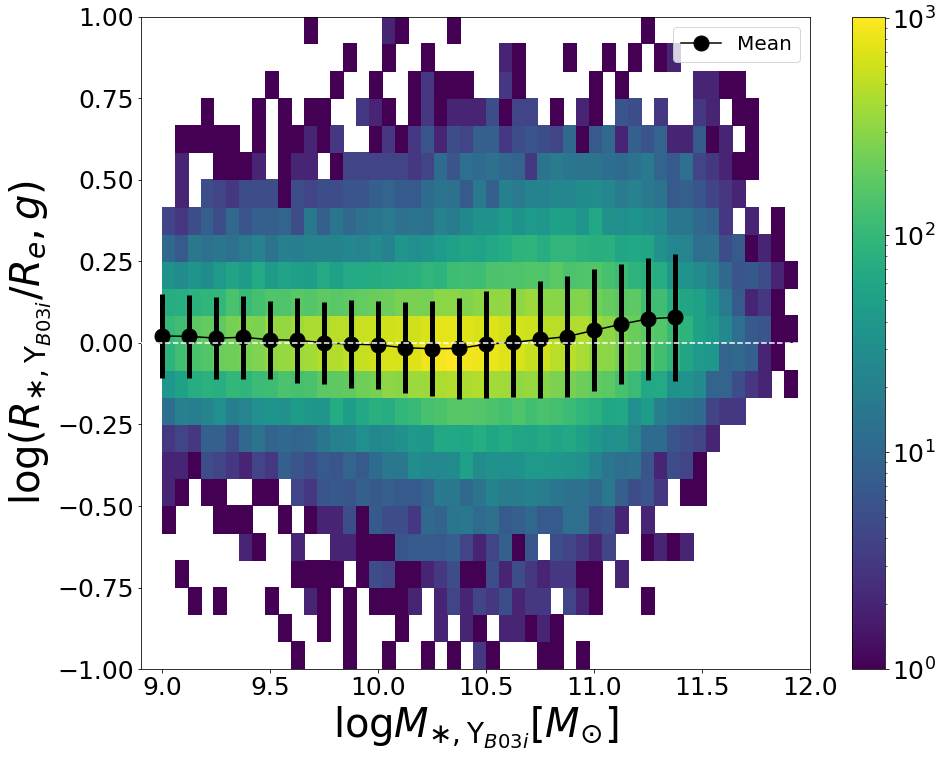

In [129]:
fig, ax= plt.subplots(figsize=(15,12))


# Re/Reg VS Ms_giB
plt.hist2d(np.log10(Ms_gi_B), np.log10(ratio_g_gi_B), bins=(50,30), range=[[9,12],[-1.25,1.25]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(gi_B_g_means_bins[:-1], stat_gi_B_g_mean, zorder=2, color ='black', marker = 'o', markersize= 15,  label='Mean')
plt.errorbar(gi_B_g_means_bins[:-1], stat_gi_B_g_mean, yerr=stat_gi_B_g_std, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.colorbar() 
x = [8.9,12]
y = [0,0]
plt.plot(x, y, zorder = 3, color='white', linestyle='--')
# Add axis labels

plt.xlabel(r'$\log M_{\ast, \Upsilon_{B03i}} [M_{\odot}]$', fontsize=40)
plt.ylabel(r'$\log (R_{\ast, \Upsilon_{B03i}}/R_e,g)$', fontsize=40)

#set axis limits
plt.ylim(-1, 1)
plt.xlim(8.9,12)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/ratiog_MsgiB.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

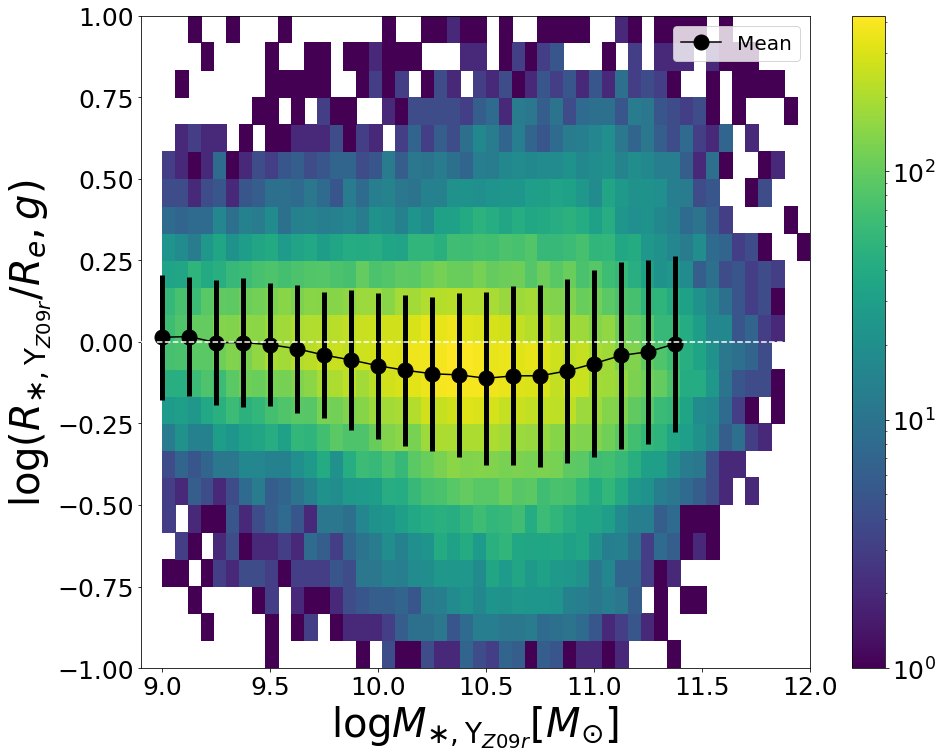

In [130]:
fig, ax= plt.subplots(figsize=(15,12))

# Re/Reg VS Ms_grZ
plt.hist2d(np.log10(Ms_gr_Z), np.log10(ratio_g_gr_Z), bins=(50,30), range=[[9,12],[-1.25,1.25]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(gr_Z_g_means_bins[:-1], stat_gr_Z_g_mean, zorder=2, color ='black', marker = 'o', markersize= 15,  label='Mean')
plt.errorbar(gr_Z_g_means_bins[:-1], stat_gr_Z_g_mean, yerr=stat_gr_Z_g_std, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.colorbar() 
x = [8.9,12]
y = [0,0]
plt.plot(x, y, zorder = 3, color='white', linestyle='--')

# Add axis labels

plt.xlabel(r'$\log M_{\ast, \Upsilon_{Z09r}} [M_{\odot}]$', fontsize=40)
plt.ylabel(r'$\log (R_{\ast, \Upsilon_{Z09r}}/R_e,g)$', fontsize=40)

#set axis limits
plt.ylim(-1, 1)
plt.xlim(8.9,12)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/ratiog_MsgrZ.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

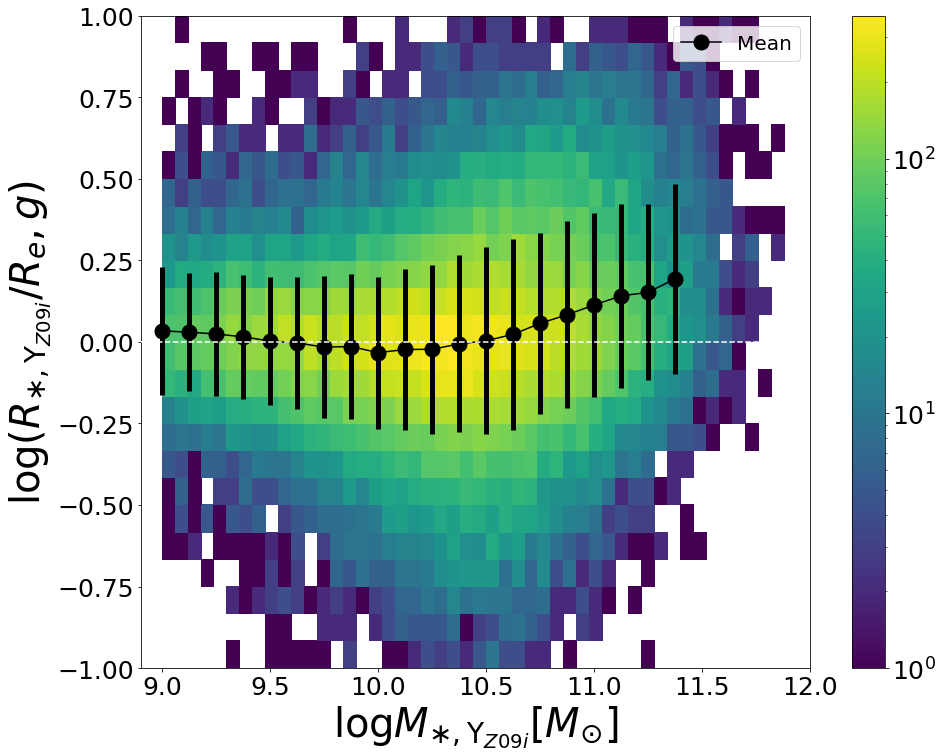

In [131]:
fig, ax= plt.subplots(figsize=(15,12))

# Re/Reg VS Ms_giZ 
plt.hist2d(np.log10(Ms_gi_Z), np.log10(ratio_g_gi_Z), bins=(50, 30), range=[[9,12],[-1.25,1.25]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(gi_Z_g_means_bins[:-1], stat_gi_Z_g_mean, zorder=2, color ='black', marker = 'o', markersize= 15,  label='Mean')
plt.errorbar(gi_Z_g_means_bins[:-1], stat_gi_Z_g_mean, yerr=stat_gi_Z_g_std, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.colorbar() 
x = [8.9,12]
y = [0,0]
plt.plot(x, y, zorder = 3, color='white', linestyle='--')

# Add axis labels

plt.xlabel(r'$\log M_{\ast, \Upsilon_{Z09i}} [M_{\odot}]$', fontsize=40)
plt.ylabel(r'$\log (R_{\ast, \Upsilon_{Z09i}}/R_e,g)$', fontsize=40)

#set axis limits
plt.ylim(-1, 1)
plt.xlim(8.9,12)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/ratiog_MsgiZ.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

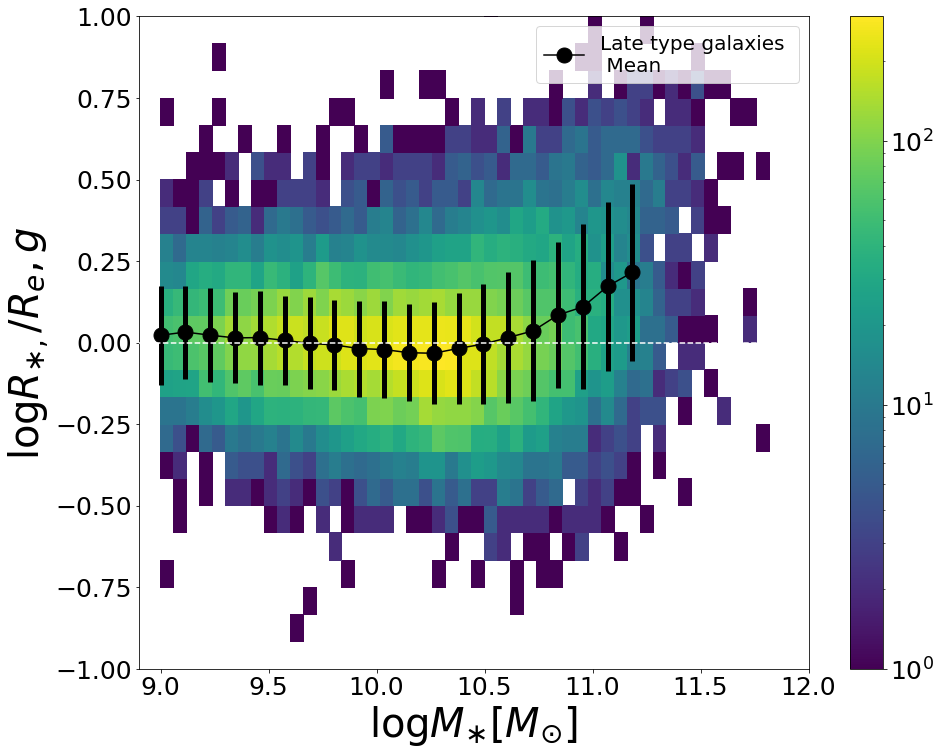

In [138]:
fig, ax= plt.subplots(figsize=(15,12))

# Re/Reg VS Ms_d late Diamond
plt.hist2d(np.log10(Ms_d_late),np.log10(r_g_d_late), bins=(50,30), range=[[9, 12], [-1.25, 1.25]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(dlate_g_means_bins[:-1], stat_d_g_late_mean, zorder=2, color ='black', marker = 'o', markersize= 15,  label='Late type galaxies \n Mean')
plt.errorbar(dlate_g_means_bins[:-1], stat_d_g_late_mean, yerr=stat_d_g_std_late, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.colorbar() 
x = [8.9,12]
y = [0,0]
plt.plot(x, y, zorder = 3, color='white', linestyle='--')

# Add axis labels

plt.xlabel(r'$\log M_{\ast} [M_{\odot}]$', fontsize=40)
plt.ylabel(r'$\log R_{\ast,}/R_e,g$', fontsize=40)

#set axis limits
plt.ylim(-1, 1)
plt.xlim(8.9,12)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size


plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/ratiog_Msdlate.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()


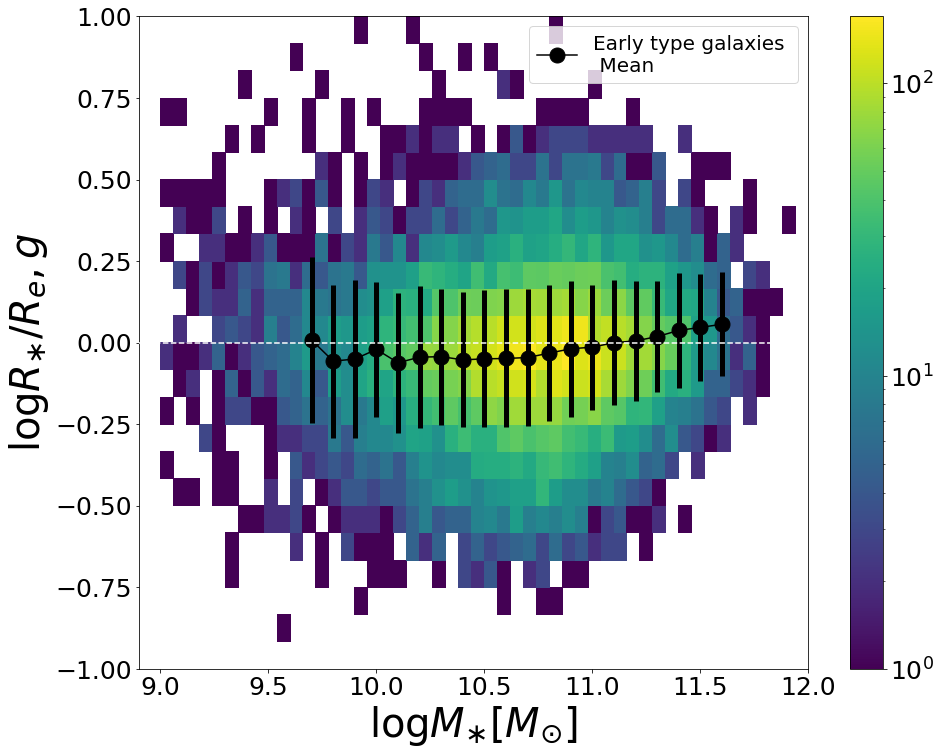

In [147]:
fig, ax= plt.subplots(figsize=(15,12))

# Re/Reg VS Ms_d early Diamond
plt.hist2d(np.log10(Ms_d_early), np.log10(r_g_d_early), bins=(50,30), range=[[9,12], [-1.25,1.25]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(dearly_g_means_bins[:-1], stat_d_g_early_mean, zorder=2, color ='black', marker = 'o', markersize= 15,  label='Early type galaxies \n Mean')
plt.errorbar(dearly_g_means_bins[:-1], stat_d_g_early_mean, yerr=stat_d_g_std_early, xerr=None, ls='None', ecolor='black', elinewidth=5)
x = [8.9,12]
y = [0,0]
plt.plot(x, y, zorder = 3, color='white', linestyle='--')
plt.colorbar() 

# Add axis labels

plt.xlabel(r'$\log M_{\ast} [M_{\odot}]$', fontsize=40)
plt.ylabel(r'$\log R_{\ast}/R_e,g$', fontsize=40)

#set axis limits
plt.ylim(-1, 1)
plt.xlim(8.9,12)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/ratiog_Msdearly.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()
